In [249]:
# Basic Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from collections import Counter

# Data Preprocessing
import scipy.sparse as sps
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn import metrics

# Surprise (For RS1)
from surprise import (
    BaselineOnly,
    KNNBasic,
    KNNWithMeans,
    KNNBaseline,
    SVD,
    SVDpp,
    NMF,
    SlopeOne,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader
import myfm

# LibRecommender (For RS2)
from libreco.data import random_split, DatasetFeat
from libreco.evaluation import evaluate
from libreco.algorithms import NCF

import tensorflow as tf
import optuna

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use("ggplot")
image_path = "images/"

# Data exploration


## New Movielens-100k


In [31]:
data_path = "ml-latest-small/"
df_rating = pd.read_csv(f"{data_path}ratings.csv")
df = df_rating

In [12]:
sparsity = 1 - len(df_rating) / (
    df_rating["movieId"].unique().shape[0] * df_rating["userId"].unique().shape[0]
)
print(f"sparsity: {sparsity:.4%}")
df_rating

sparsity: 98.3000%


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


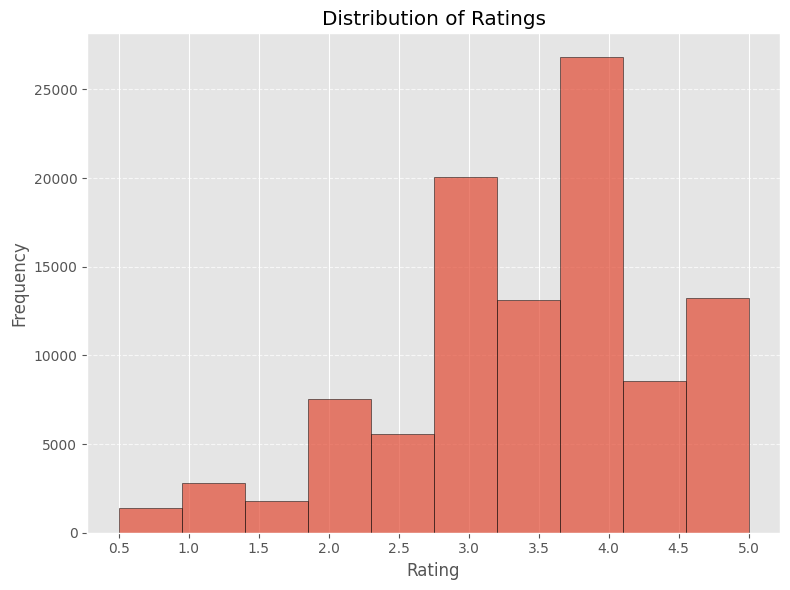

In [46]:
# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_rating["rating"], bins=10, edgecolor="black", alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{image_path}rating_distribution.png")
plt.show()

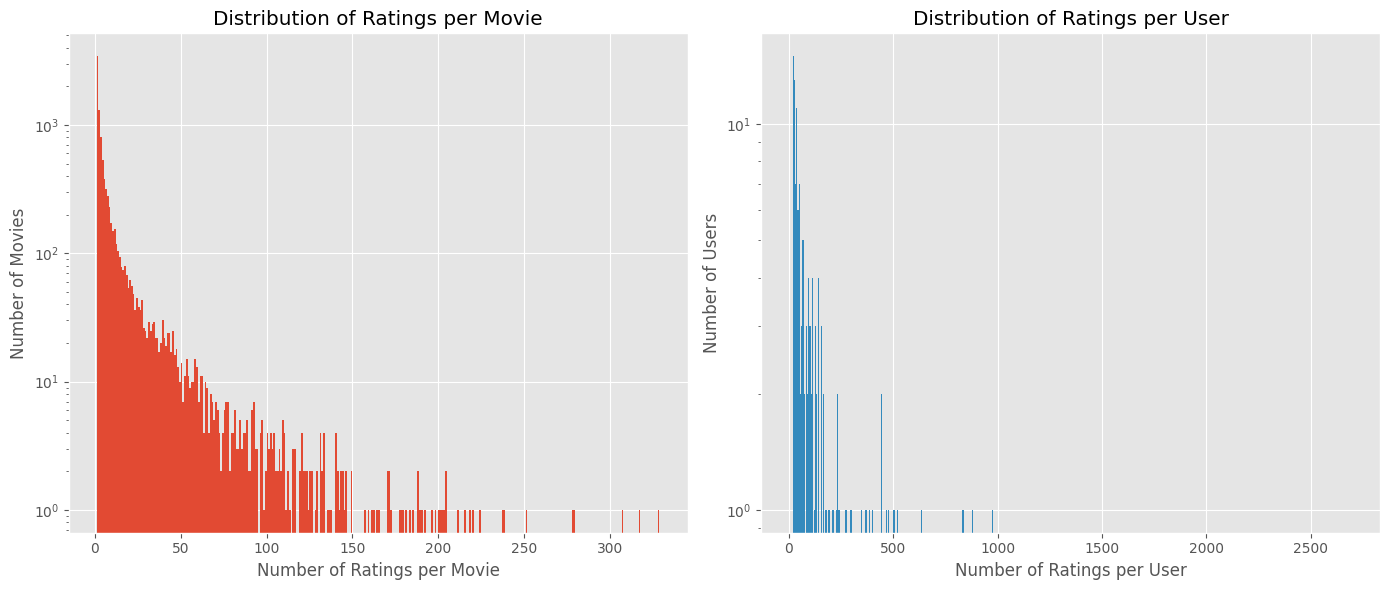

In [50]:
rating_count = df_rating["movieId"].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rating_count, bins=range(1, rating_count.max() + 1), color="C0", log=True)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Distribution of Ratings per Movie")
plt.grid(True)

user_rating_count = df_rating["userId"].value_counts()
plt.subplot(1, 2, 2)
plt.hist(
    user_rating_count,
    bins=range(1, user_rating_count.max() + 1),
    log=True,
    color="C1",
)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratings per User")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{image_path}rating_per_user_movie.png")
plt.show()

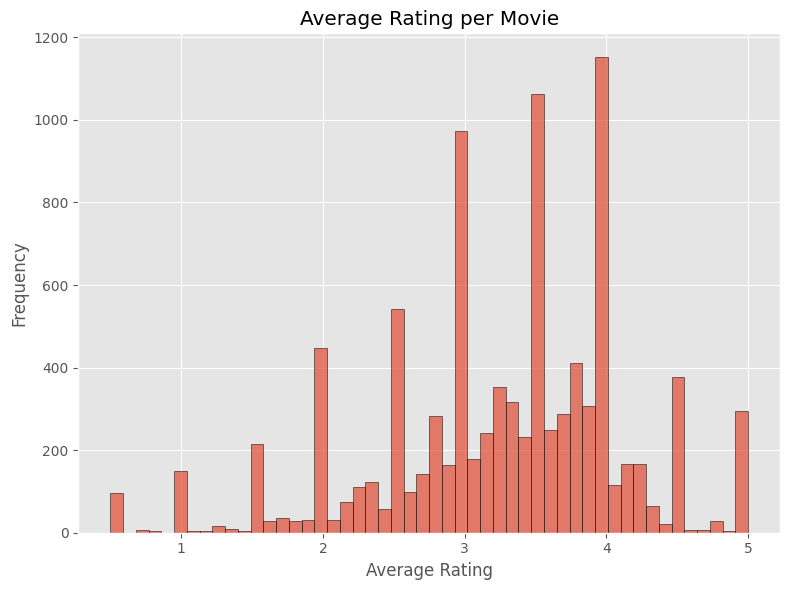

In [64]:
plt.figure(figsize=(8, 6))
avg_rating_per_movie = df.groupby("movieId")["rating"].mean()
plt.hist(avg_rating_per_movie, bins=50, edgecolor="black", alpha=0.7)
plt.title("Average Rating per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"{image_path}avg_rating_per_movie.png")
plt.show()

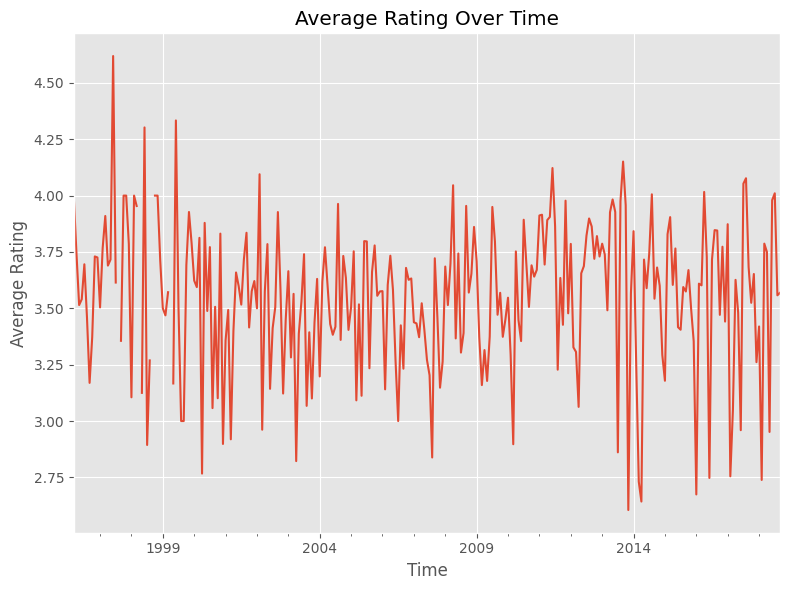

In [69]:
df = df_rating.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
plt.figure(figsize=(8, 6))
df.set_index("timestamp")["rating"].resample("ME").mean().plot()
plt.title("Average Rating Over Time")
plt.xlabel("Time")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.savefig(f"{image_path}avg_rating_over_time.png")
plt.show()

### Additional metadata


In [84]:
df_movie = pd.read_csv(f"{data_path}movies.csv")
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [85]:
df_movie["release_year"] = df_movie["title"].str.extract(r"\((\d{4})\)")
df_movie["title"] = df_movie["title"].str.replace(r"\s*\(\d{4}\)$", "", regex=True)
df_movie["release_year"] = df_movie["release_year"].astype(str)
print(df_movie["release_year"].isnull().sum())
df_movie

0


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


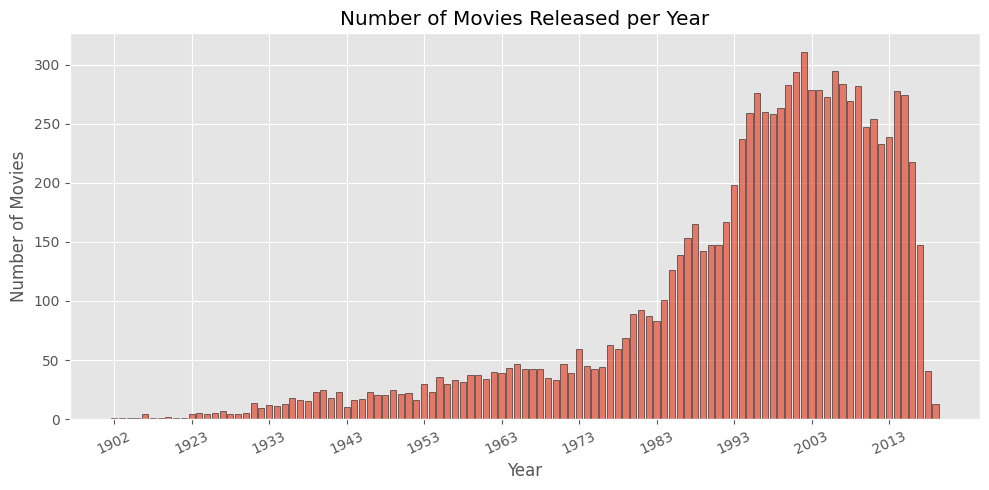

In [86]:
plt.figure(figsize=(10, 5))
movies_per_year = df_movie["release_year"].value_counts().sort_index()
plt.bar(movies_per_year.index, movies_per_year.values, edgecolor="black", alpha=0.7)
plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.xticks(ticks=movies_per_year.index[::10], rotation=25)
plt.tight_layout()
plt.savefig(f"{image_path}movies_per_year.png")
plt.show()

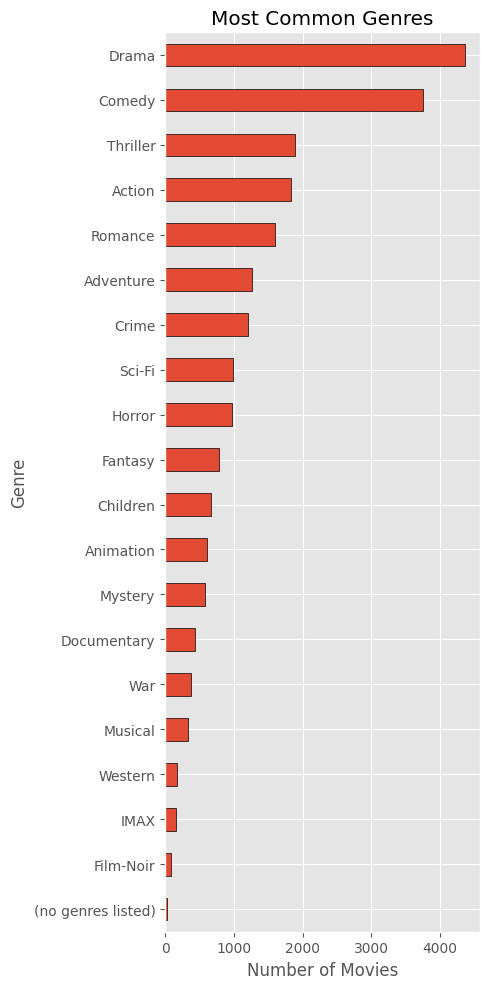

In [109]:
df_movie_genre = df_movie.copy()
df_movie_genre["genre_list"] = df_movie_genre["genres"].str.split("|")
genres = df_movie_genre.explode("genre_list")["genre_list"]
genre_counts = genres.value_counts().sort_values()

plt.figure(figsize=(5, 10))
genre_counts.plot(kind="barh", edgecolor="black")
plt.title("Most Common Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.savefig(f"{image_path}most_common_genres.png")
plt.show()

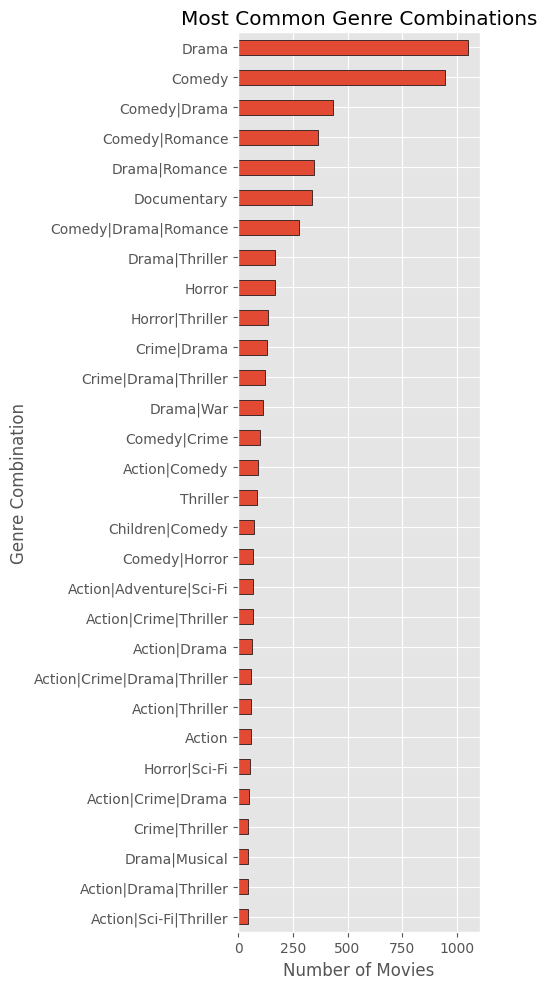

In [110]:
plt.figure(figsize=(5, 10))
genre_combinations = df_movie["genres"].value_counts().head(30).sort_values()
genre_combinations.plot(kind="barh", edgecolor="black")
plt.title("Most Common Genre Combinations")
plt.xlabel("Number of Movies")
plt.ylabel("Genre Combination")
plt.tight_layout()
plt.savefig(f"{image_path}most_common_genre_combinations.png")
plt.show()

In [17]:
df_tag = pd.read_csv(f"{data_path}tags.csv")
df_tag

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [18]:
df_link = pd.read_csv(f"{data_path}links.csv")
df_link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


# Recommender System Model


In [221]:
def novelty(recommendations, interactions, item_popularity):
    novelty_scores = [
        -np.log2(item_popularity.get(item, 1) / interactions)
        for item in recommendations
    ]
    return np.mean(novelty_scores)

In [ ]:
algorithms = [
    BaselineOnly(),
    KNNBasic(),
    KNNWithMeans(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering(),
]

algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]

# results = {}

# Load movielens-100k dataset
reader = Reader()
data = Dataset.load_from_df(df_rating[["userId", "movieId", "rating"]], reader)
trainset = data.build_full_trainset()
def surprise_recommend(algo, trainset, user_id, top_n=10):
    all_items = set(trainset.all_items())
    known_items = set([j for (j, _) in trainset.ur[user_id]])
    predictions = [
        (trainset.to_raw_iid(i), algo.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(i)).est)
        for i in all_items - known_items
    ]
    top_n_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
    return [item_id for item_id, _ in top_n_recommendations]

for algo, name in zip(algorithms, algo_names):
    cv_results = cross_validate(
        algo, data, measures=["rmse", "mae"], cv=5, verbose=False
    )
    algo.fit(trainset)
    train_ratings = [(uid, iid, r) for (uid, iid, r) in trainset.all_ratings()]
    item_counts = Counter([iid for (_, iid, _) in train_ratings])
    item_popularity = dict(item_counts)
    interactions = len(train_ratings)

    user_novelties = []
    for inner_uid in trainset.all_users():
        user_novelties.append(novelty(surprise_recommend(algo, trainset, inner_uid, 10), interactions, item_popularity))

    results[name] = {
        "RMSE": np.mean(cv_results["test_rmse"]),
        "MAE": np.mean(cv_results["test_mae"]),
        "Novelty": np.mean(user_novelties),
    }
results

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating 

{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

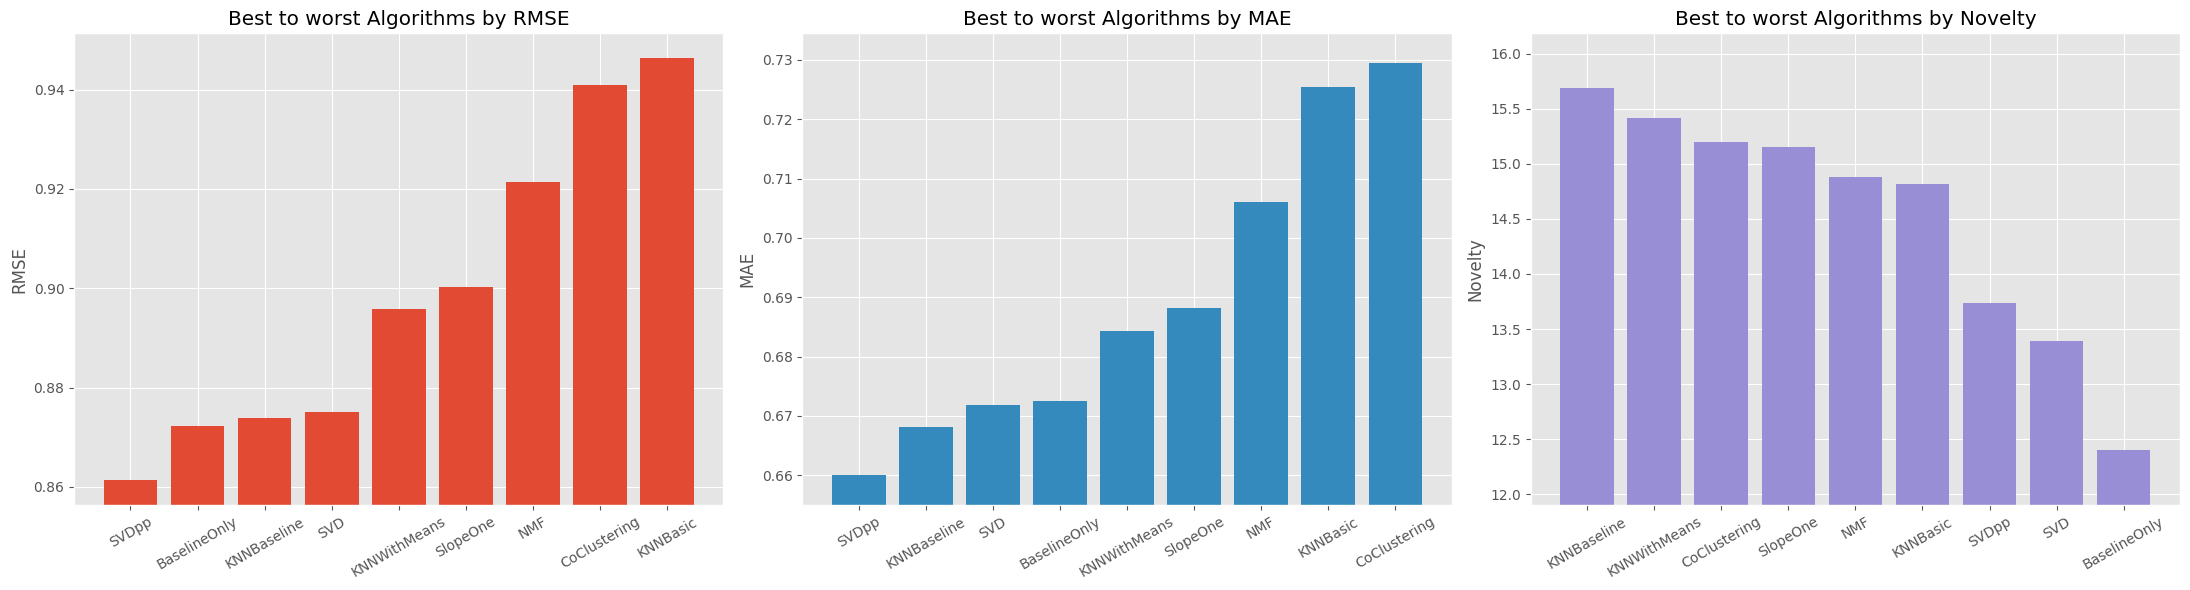

{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

In [248]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])
novelty_scores = np.array([results[name]["Novelty"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
order_novelty = np.argsort(-novelty_scores)

# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]
algo_names_novelty = [algo_names[i] for i in order_novelty]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]
novelty_ordered = novelty_scores[order_novelty]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))
x_novelty = np.arange(len(algo_names_novelty))

# Create two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

# Plot Novelty on the right, ordered by Novelty
ax3.bar(x_novelty, novelty_ordered, color="C2")
ax3.set_title("Best to worst Algorithms by Novelty")
ax3.set_ylabel("Novelty")
ax3.set_xticks(x_novelty)
ax3.set_xticklabels(algo_names_novelty, rotation=30)
ax3.set_ylim(novelty_ordered.min() - 0.5, novelty_ordered.max() + 0.5)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_algo_comparison.png", dpi=300)
plt.show()
results

In [233]:
from sklearn.model_selection import train_test_split, KFold
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state=42)

def get_extended_features(
    X_train_base,
    X_test_base,
    df_train,
    df_test,
    incluse_variance=False,
    include_release_year=False,
    include_genres=False,
):
    X_train_ext = X_train_base
    X_test_ext = X_test_base
    group_shapes = None

    if incluse_variance:
        group_shapes = [len(group) for group in ohe.categories_]

    if include_release_year:
        X_train_release = movie_info_ohe.transform(
            movie_info.reindex(df_train.movieId).drop(columns=["genres"])
        )
        X_test_release = movie_info_ohe.transform(
            movie_info.reindex(df_test.movieId).drop(columns=["genres"])
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_release])
        X_test_ext = sps.hstack([X_test_ext, X_test_release])
        group_shapes.extend([len(group) for group in movie_info_ohe.categories_])

    if include_genres:
        X_train_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_train.movieId).apply(lambda x: x.split("|"))
        )
        X_test_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_test.movieId).apply(lambda x: x.split("|"))
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_genres])
        X_test_ext = sps.hstack([X_test_ext, X_test_genres])
        group_shapes.append(len(movie_genre_mle.classes_))

    return X_train_ext, X_test_ext, group_shapes


def train_predict_fm(
    df,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        X_train_base = ohe.transform(df_train[FEATURE_COLUMNS])
        X_test_base = ohe.transform(df_test[FEATURE_COLUMNS])
        y_train = df_train.rating.values
        y_test = df_test.rating.values

        X_train_ext, X_test_ext, group_shapes = get_extended_features(
            X_train_base,
            X_test_base,
            df_train,
            df_test,
            incluse_variance=include_variance,
            include_release_year=include_release_year,
            include_genres=include_genres,
        )

        model = myfm.MyFMRegressor(rank=fm_rank, random_seed=42)
        model.fit(
            X_train_ext,
            y_train,
            n_iter=200,
            n_kept_samples=200,
            group_shapes=group_shapes,
        )
        prediction = model.predict(X_test_ext)
        rmse = np.sqrt(((y_test - prediction) ** 2).mean())
        mae = np.abs(y_test - prediction).mean()

        rmse_scores.append(rmse)
        mae_scores.append(mae)

    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)

    return mean_rmse, mean_mae

FEATURE_COLUMNS = ["userId", "movieId"]
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(df_rating[FEATURE_COLUMNS])

movie_info = df_movie.set_index("movieId")[["release_year", "genres"]]
movie_info_ohe = OneHotEncoder(handle_unknown="ignore").fit(
    movie_info[["release_year"]]
)
movie_genre_mle = MultiLabelBinarizer(sparse_output=True).fit(
    movie_info.genres.apply(lambda x: x.split("|"))
)

In [ ]:
results_with_metadata = {}

output = train_predict_fm(
    df=df_rating,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["baseline"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/releaseYear"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/genres"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["everything"] = {"RMSE": output[0], "MAE": output[1]}

results_with_metadata

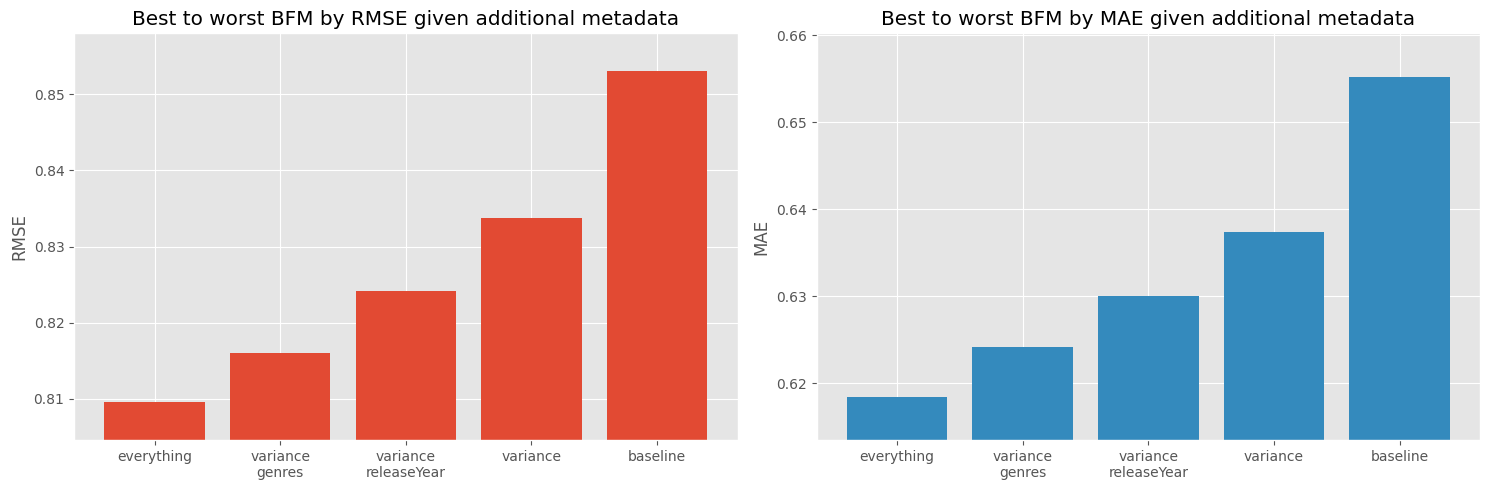

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [14]:
algo_names = [
    "baseline",
    "variance",
    "variance/releaseYear",
    "variance/genres",
    "everything",
]
rmse_scores = np.array([results_with_metadata[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_metadata[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i].replace("/", "\n") for i in order_rmse]
algo_names_mae = [algo_names[i].replace("/", "\n") for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given additional metadata")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given additional metadata")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_metadata_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [17]:
results_with_FM = {}

for fm_rank in [10, 15, 20, 25, 30, 35, 40]:
    output = train_predict_fm(
        df=df_rating,
        include_variance=True,
        include_release_year=True,
        include_genres=True,
        fm_rank=fm_rank,
        n_splits=5,
    )
    results_with_FM[f"{fm_rank}"] = {"RMSE": output[0], "MAE": output[1]}

results_with_FM

alpha = 3.15 w0 = 3.58 : 100%|██████████| 200/200 [00:40<00:00,  4.94it/s]


{'10': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903},
 '15': {'RMSE': 0.8078713046385703, 'MAE': 0.6171318072640773},
 '20': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937},
 '25': {'RMSE': 0.807556169205054, 'MAE': 0.6165670606260625},
 '30': {'RMSE': 0.8076044236135693, 'MAE': 0.6169995064451081},
 '35': {'RMSE': 0.8075236626964785, 'MAE': 0.6168251377452408},
 '40': {'RMSE': 0.8077819685049361, 'MAE': 0.6169657037629094}}

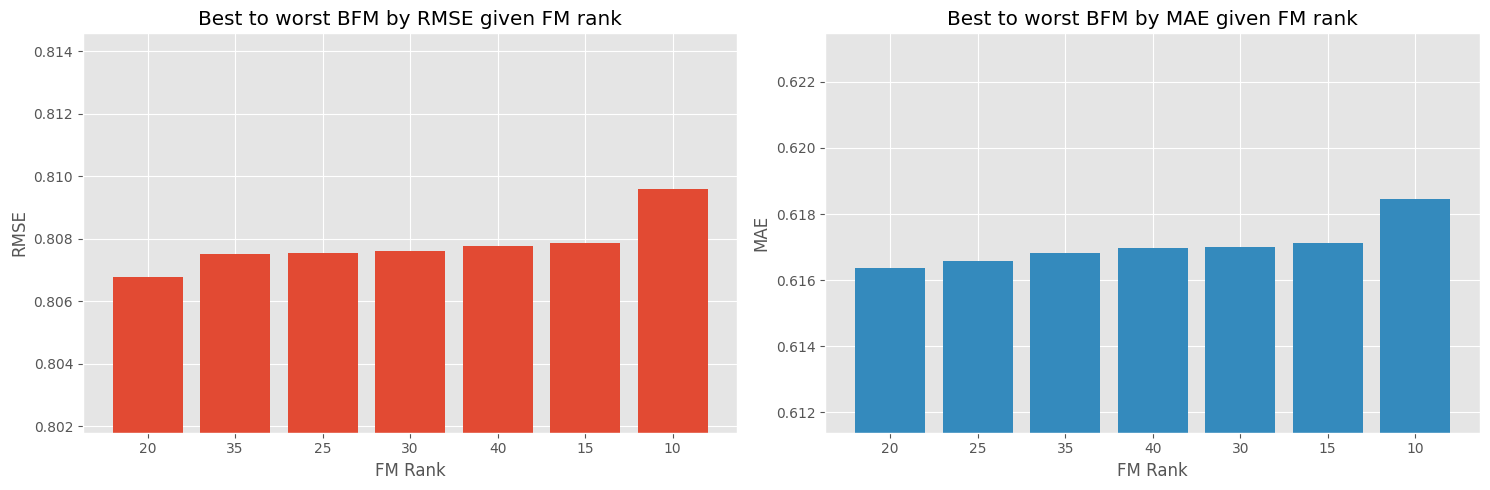

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [18]:
algo_names = ["10", "15", "20", "25", "30", "35", "40"]
rmse_scores = np.array([results_with_FM[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_FM[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given FM rank")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("FM Rank")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given FM rank")
ax2.set_ylabel("MAE")
ax2.set_xlabel("FM Rank")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_rank_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [239]:
X_train = ohe.fit_transform(df_rating[FEATURE_COLUMNS])
y_train = df_rating.rating.values

X_train_extended = sps.hstack(
    [
        X_train,
        movie_info_ohe.transform(
            movie_info.reindex(df_rating.movieId).drop(columns=["genres"])
        ),
        movie_genre_mle.transform(
            movie_info.genres.reindex(df_rating.movieId).apply(lambda x: x.split("|"))
        ),
    ]
)

group_shapes_extended = (
    [len(group) for group in ohe.categories_]
    + [len(group) for group in movie_info_ohe.categories_]
    + [len(movie_genre_mle.classes_)]
)

best_bfm = myfm.MyFMRegressor(
    rank=20,
    random_seed=42,
)
best_bfm.fit(
    X_train_extended,
    y_train,
    n_iter=200,
    n_kept_samples=200,
    group_shapes=group_shapes_extended,
)

def bfm_recommend(bfm_model, user_id, df_rating, ohe, movie_info_ohe, movie_genre_mle, movie_info, n):
    unrated_movies = np.setdiff1d(df_rating['movieId'].unique(), df_rating[df_rating['userId'] == user_id]['movieId'].unique())
    
    X_unrated = ohe.transform(np.hstack([np.full((len(unrated_movies), 1), user_id), unrated_movies.reshape(-1, 1)]))
    X_side_info = movie_info_ohe.transform(movie_info.reindex(unrated_movies).drop(columns=["genres"]))
    X_genres = movie_genre_mle.transform(movie_info.genres.reindex(unrated_movies).str.split("|"))

    predictions = bfm_model.predict(sps.hstack([X_unrated, X_side_info, X_genres]))
    return unrated_movies[np.argsort(predictions)[-n:][::-1]]

alpha = 2.72 w0 = 3.21 : 100%|██████████| 200/200 [00:19<00:00, 10.27it/s]


In [240]:
item_popularity = df_rating.groupby("movieId")["userId"].nunique().to_dict()
interactions = len(df_rating)

user_novelties = []
for user_id in df_rating["userId"].unique():
    user_novelties.append(
        novelty(bfm_recommend(best_bfm, user_id, df_rating, ohe, movie_info_ohe, movie_genre_mle, movie_info, 10), interactions, item_popularity)
    )
overall_novelty = np.mean(user_novelties)

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=20,
    n_splits=5,
)

results["BFM"] = {"RMSE": output[0], "MAE": output[1], "Novelty": overall_novelty}

results

alpha = 2.73 w0 = 3.23 : 100%|██████████| 200/200 [00:16<00:00, 12.43it/s]


{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

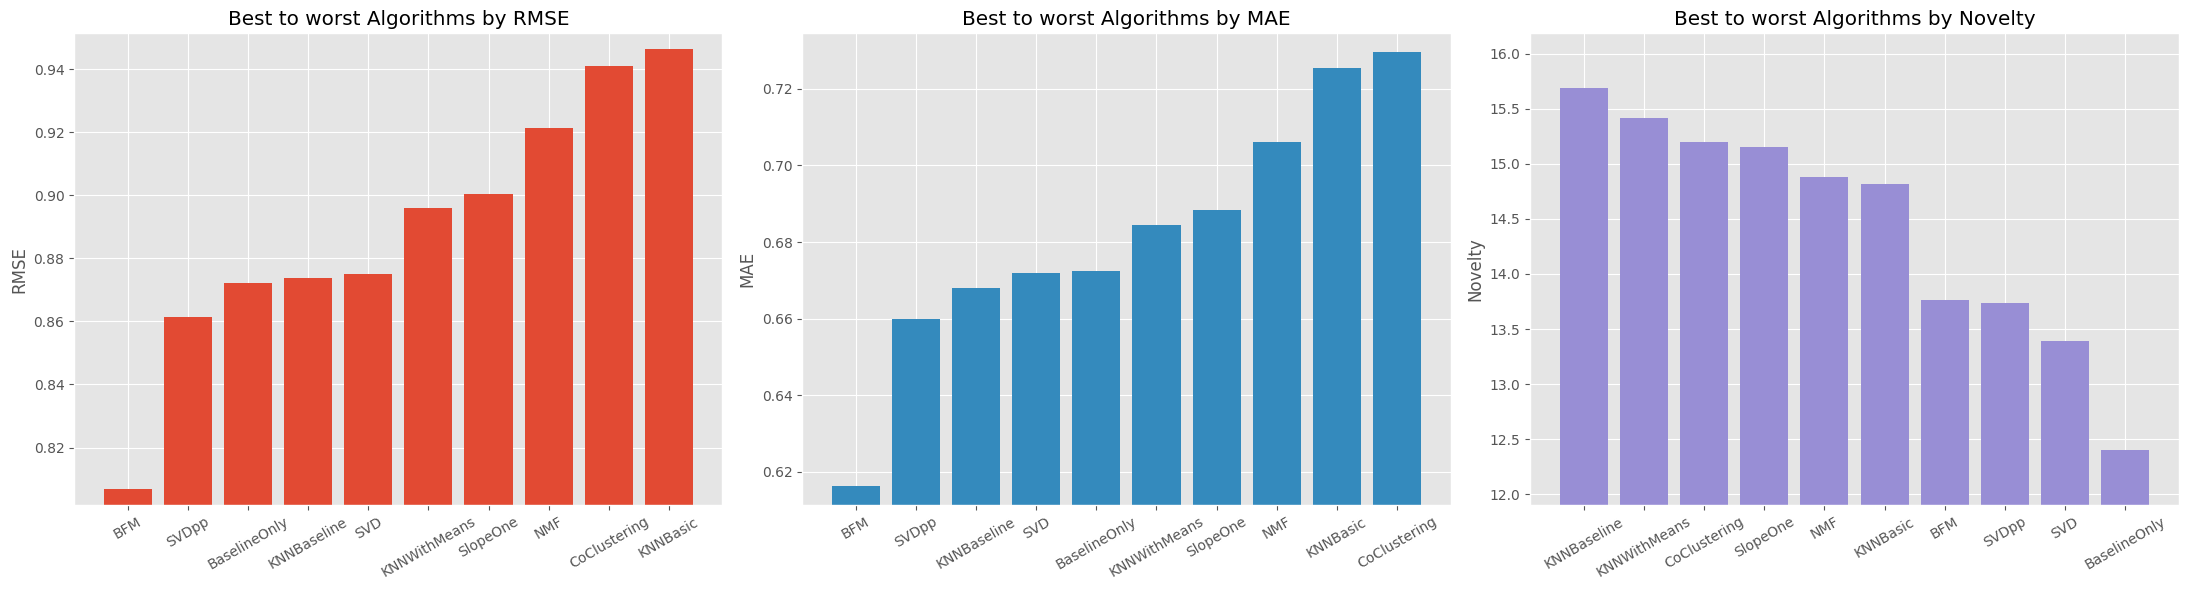

{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

In [246]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
    "BFM"
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])
novelty_scores = np.array([results[name]["Novelty"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
order_novelty = np.argsort(-novelty_scores)

# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]
algo_names_novelty = [algo_names[i] for i in order_novelty]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]
novelty_ordered = novelty_scores[order_novelty]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))
x_novelty = np.arange(len(algo_names_novelty))

# Create two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

# Plot Novelty on the right, ordered by Novelty
ax3.bar(x_novelty, novelty_ordered, color="C2")
ax3.set_title("Best to worst Algorithms by Novelty")
ax3.set_ylabel("Novelty")
ax3.set_xticks(x_novelty)
ax3.set_xticklabels(algo_names_novelty, rotation=30)
ax3.set_ylim(novelty_ordered.min() - 0.5, novelty_ordered.max() + 0.5)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_BFM_algo_comparison.png", dpi=300)
plt.show()
results

In [242]:
mlb = MultiLabelBinarizer()
tf.compat.v1.reset_default_graph()

libreco_full = df_rating.merge(df_movie, how="left", on="movieId")
libreco_full = libreco_full.rename(
    columns={"userId": "user", "movieId": "item", "rating": "label"}
)
libreco_full["genres"] = libreco_full["genres"].str.split("|")
genre_encoded = pd.DataFrame(
    mlb.fit_transform(libreco_full["genres"]),
    columns=mlb.classes_,
    index=libreco_full.index,
)
libreco_full = pd.concat([libreco_full, genre_encoded], axis=1).drop(
    columns=["genres", "timestamp"]
)

train_data, eval_data, test_data = random_split(
    libreco_full, multi_ratios=[0.8, 0.1, 0.1], seed=42
)

sparse_col = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "IMAX",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
dense_col = ["release_year"]
user_col = []
item_col = sparse_col + dense_col

train_data, data_info = DatasetFeat.build_trainset(
    train_data,
    user_col=user_col,
    item_col=item_col,
    sparse_col=sparse_col,
    dense_col=dense_col,
)
eval_data = DatasetFeat.build_testset(eval_data)
test_data = DatasetFeat.build_testset(test_data)

libreco_full

,user,item,label,title,release_year,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story,1995,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,Grumpier Old Men,1995,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,Heat,1995,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,Seven (a.k.a. Se7en),1995,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,"Usual Suspects, The",1995,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split,2017,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,John Wick: Chapter Two,2017,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,Get Out,2017,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,Logan,2017,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


/tmp/ipykernel_195799/2649719384.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["lr", "embed_size"])
[W 2025-03-24 09:39:19,937] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_195799/2649719384.py:5: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["lr", "batch_size"])
[W 2025-03-24 09:39:20,943] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_195799/2649719384.py:8: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, pa

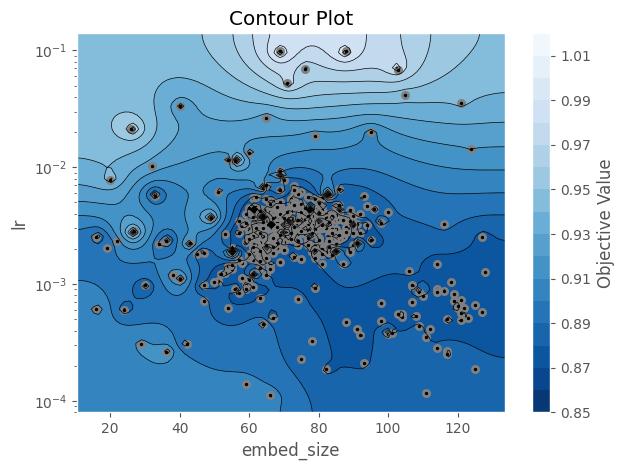

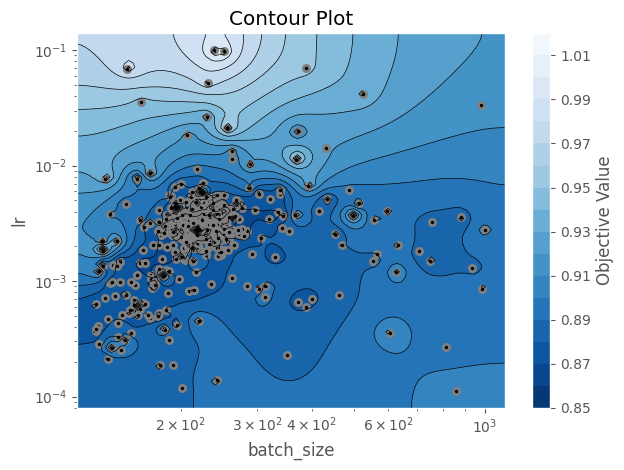

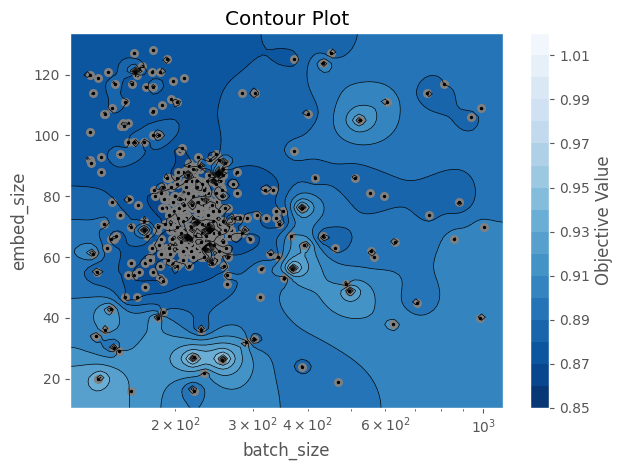

In [23]:
study = optuna.load_study(
    study_name="NCF_RMSE_Optimization", storage="sqlite:///ncf_study.db"
)
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "embed_size"])
plt.tight_layout()
plt.savefig(f"{image_path}ncf_contour_lr_embed.png", dpi=300)
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "batch_size"])
plt.tight_layout()
plt.savefig(f"{image_path}ncf_contour_lr_batch.png", dpi=300)
optuna.visualization.matplotlib.plot_contour(study, params=["batch_size", "embed_size"])
plt.tight_layout()
plt.savefig(f"{image_path}ncf_contour_batch_embed.png", dpi=300)

In [243]:
tf.compat.v1.reset_default_graph()
best_trial = study.best_trial
ncf_model = NCF(
    task="rating",
    data_info=data_info,
    embed_size=best_trial.params["embed_size"],
    n_epochs=best_trial.params["n_epochs"],
    lr=best_trial.params["lr"],
    batch_size=best_trial.params["batch_size"],
    hidden_units=best_trial.params["hidden_units"],
    dropout_rate=best_trial.params["dropout_rate"],
    reg=best_trial.params["reg"],
    sampler="unconsumed",
    use_bn=True,
    seed=42,
)
ncf_model.fit(train_data, neg_sampling=False, eval_data=eval_data, verbose=0)

ncf_result = evaluate(
    model=ncf_model,
    data=test_data,
    neg_sampling=False,
    metrics=["rmse", "mae"],
)

train_data, eval_data, test_data = random_split(
    libreco_full, multi_ratios=[0.8, 0.1, 0.1], seed=42
)

item_popularity = libreco_full.groupby("item")["user"].nunique().to_dict()
interactions = len(libreco_full)

user_novelties = []
for user_id in libreco_full["user"].unique():
    user_novelties.append(
        novelty(ncf_model.recommend_user(user=user_id, n_rec=10)[user_id], interactions, item_popularity)
    )
overall_novelty = np.mean(user_novelties)

results["NCF"] = {"RMSE": ncf_result["rmse"], "MAE": ncf_result["mae"], "Novelty": overall_novelty}
results

Training start time: 2025-03-24 20:51:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 274.59it/s]


{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

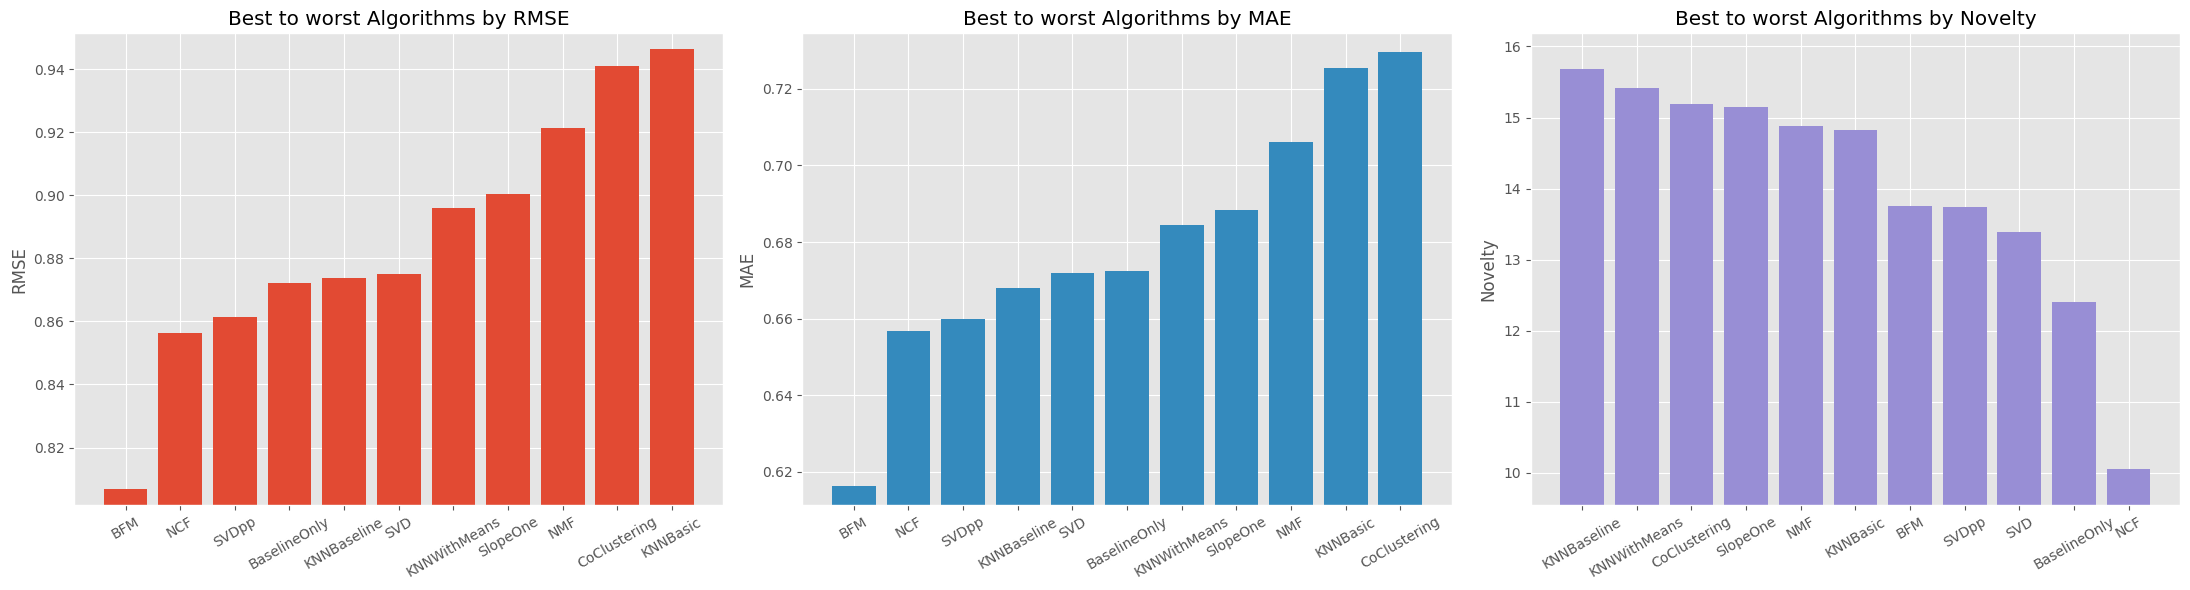

{'BaselineOnly': {'RMSE': 0.8723122637680809,
  'MAE': 0.6725259183288292,
  'Novelty': 12.402548739293731},
 'KNNBasic': {'RMSE': 0.9463459752774442,
  'MAE': 0.7253488820010434,
  'Novelty': 14.817784225232122},
 'KNNWithMeans': {'RMSE': 0.8958279134055435,
  'MAE': 0.6843962337773364,
  'Novelty': 15.41654535008545},
 'KNNBaseline': {'RMSE': 0.8738028421341758,
  'MAE': 0.6681094247271623,
  'Novelty': 15.68452023102231},
 'SVD': {'RMSE': 0.8750575863193859,
  'MAE': 0.671911723150704,
  'Novelty': 13.391474779494597},
 'SVDpp': {'RMSE': 0.8613439093590495,
  'MAE': 0.6600094122131022,
  'Novelty': 13.736006128493479},
 'NMF': {'RMSE': 0.9212998016744963,
  'MAE': 0.7060325107738044,
  'Novelty': 14.87986850980382},
 'SlopeOne': {'RMSE': 0.9002634716611538,
  'MAE': 0.6882426092012788,
  'Novelty': 15.15112119205345},
 'CoClustering': {'RMSE': 0.9408842190338484,
  'MAE': 0.7294722538502623,
  'Novelty': 15.194470681724583},
 'BFM': {'RMSE': 0.8067885988048065,
  'MAE': 0.6163814903

In [247]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
    "BFM",
    "NCF",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])
novelty_scores = np.array([results[name]["Novelty"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
order_novelty = np.argsort(-novelty_scores)

# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]
algo_names_novelty = [algo_names[i] for i in order_novelty]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]
novelty_ordered = novelty_scores[order_novelty]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))
x_novelty = np.arange(len(algo_names_novelty))

# Create two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

# Plot Novelty on the right, ordered by Novelty
ax3.bar(x_novelty, novelty_ordered, color="C2")
ax3.set_title("Best to worst Algorithms by Novelty")
ax3.set_ylabel("Novelty")
ax3.set_xticks(x_novelty)
ax3.set_xticklabels(algo_names_novelty, rotation=30)
ax3.set_ylim(novelty_ordered.min() - 0.5, novelty_ordered.max() + 0.5)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_BFM_NCF_algo_comparison.png", dpi=300)
plt.show()
results

In [114]:
FEATURE_COLUMNS = ["userId", "movieId"]
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(df_rating[FEATURE_COLUMNS])

movie_info = df_movie.set_index("movieId")[["release_year", "genres"]]
movie_info_ohe = OneHotEncoder(handle_unknown="ignore").fit(
    movie_info[["release_year"]]
)
movie_genre_mle = MultiLabelBinarizer(sparse_output=True).fit(
    movie_info.genres.apply(lambda x: x.split("|"))
)

X_train = ohe.fit_transform(df_rating[FEATURE_COLUMNS])
y_train = df_rating.rating.values

X_train_extended = sps.hstack(
    [
        X_train,
        movie_info_ohe.transform(
            movie_info.reindex(df_rating.movieId).drop(columns=["genres"])
        ),
        movie_genre_mle.transform(
            movie_info.genres.reindex(df_rating.movieId).apply(lambda x: x.split("|"))
        ),
    ]
)

group_shapes_extended = (
    [len(group) for group in ohe.categories_]
    + [len(group) for group in movie_info_ohe.categories_]
    + [len(movie_genre_mle.classes_)]
)

best_bfm = myfm.MyFMRegressor(
    rank=20,
    random_seed=42,
)
best_bfm.fit(
    X_train_extended,
    y_train,
    n_iter=200,
    n_kept_samples=200,
    group_shapes=group_shapes_extended,
)
with open("model/best_bfm_model.pkl", "wb") as file:
    pickle.dump(best_bfm, file)

alpha = 2.72 w0 = 3.21 : 100%|██████████| 200/200 [00:19<00:00, 10.10it/s]


In [117]:
sparse_col = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "IMAX",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
dense_col = ["release_year"]
user_col = []
item_col = sparse_col + dense_col
full_train_data, data_info = DatasetFeat.build_trainset(
    libreco_full,
    user_col=user_col,
    item_col=item_col,
    sparse_col=sparse_col,
    dense_col=dense_col,
)
study = optuna.load_study(
    study_name="NCF_RMSE_Optimization", storage="sqlite:///ncf_study.db"
)
tf.compat.v1.reset_default_graph()
best_trial = study.best_trial
final_model = NCF(
    task="rating",
    data_info=data_info,
    embed_size=best_trial.params["embed_size"],
    n_epochs=best_trial.params["n_epochs"],
    lr=best_trial.params["lr"],
    batch_size=best_trial.params["batch_size"],
    hidden_units=best_trial.params["hidden_units"],
    dropout_rate=best_trial.params["dropout_rate"],
    reg=best_trial.params["reg"],
    sampler="unconsumed",
    use_bn=True,
    seed=42,
)
final_model.fit(full_train_data, neg_sampling=False, verbose=2)
final_model.save(
    path="model/best_ncf_model", model_name="best_ncf_model", inference_only=True
)

Training start time: 2025-03-24 13:51:41


train: 100%|██████████| 970/970 [00:02<00:00, 375.09it/s]


Epoch 1 elapsed: 2.588s
	 train_loss: 1.4011


train: 100%|██████████| 970/970 [00:02<00:00, 357.10it/s]


Epoch 2 elapsed: 2.718s
	 train_loss: 0.7944


train: 100%|██████████| 970/970 [00:02<00:00, 375.41it/s]


Epoch 3 elapsed: 2.585s
	 train_loss: 0.7807


train: 100%|██████████| 970/970 [00:02<00:00, 381.09it/s]


Epoch 4 elapsed: 2.547s
	 train_loss: 0.7687


train: 100%|██████████| 970/970 [00:02<00:00, 361.14it/s]


Epoch 5 elapsed: 2.688s
	 train_loss: 0.7531


train: 100%|██████████| 970/970 [00:02<00:00, 357.30it/s]


Epoch 6 elapsed: 2.717s
	 train_loss: 0.7429


train: 100%|██████████| 970/970 [00:02<00:00, 352.49it/s]


Epoch 7 elapsed: 2.754s
	 train_loss: 0.7284


train: 100%|██████████| 970/970 [00:02<00:00, 353.90it/s]


Epoch 8 elapsed: 2.743s
	 train_loss: 0.7193


train: 100%|██████████| 970/970 [00:02<00:00, 351.72it/s]


Epoch 9 elapsed: 2.760s
	 train_loss: 0.7101


train: 100%|██████████| 970/970 [00:02<00:00, 351.33it/s]


Epoch 10 elapsed: 2.763s
	 train_loss: 0.7065


train: 100%|██████████| 970/970 [00:02<00:00, 337.13it/s]


Epoch 11 elapsed: 2.879s
	 train_loss: 0.7008


train: 100%|██████████| 970/970 [00:03<00:00, 307.40it/s]


Epoch 12 elapsed: 3.158s
	 train_loss: 0.6968


train: 100%|██████████| 970/970 [00:02<00:00, 363.87it/s]


Epoch 13 elapsed: 2.668s
	 train_loss: 0.6917


train: 100%|██████████| 970/970 [00:02<00:00, 364.07it/s]


Epoch 14 elapsed: 2.666s
	 train_loss: 0.6885


train: 100%|██████████| 970/970 [00:02<00:00, 365.15it/s]


Epoch 15 elapsed: 2.658s
	 train_loss: 0.6831


train: 100%|██████████| 970/970 [00:02<00:00, 363.96it/s]


Epoch 16 elapsed: 2.667s
	 train_loss: 0.6807
file folder best_ncf_model doesn't exists, creating a new one...


In [ ]:
def objective_ncf(trial):
    tf.compat.v1.reset_default_graph()
    embed_size = trial.suggest_int("embed_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 128, 1024, log=True)
    hidden_units = trial.suggest_categorical(
        "hidden_units", [(64, 32), (128, 64, 32), (256, 128, 64)]
    )
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    reg = trial.suggest_float("reg", 1e-5, 1e-1, log=True)
    n_epochs = trial.suggest_int("n_epochs", 10, 20)

    model = NCF(
        task="rating",
        data_info=data_info,
        embed_size=embed_size,
        n_epochs=n_epochs,
        lr=lr,
        batch_size=batch_size,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        reg=reg,
        sampler="unconsumed",
        use_bn=True,
        seed=42,
    )

    model.fit(train_data, neg_sampling=False, eval_data=eval_data, verbose=0)
    result = evaluate(
        model=model,
        data=test_data,
        neg_sampling=False,
        metrics=["rmse"],
    )

    return result["rmse"]


study = optuna.create_study(
    direction="minimize",
    study_name="NCF_RMSE_Optimization",
    storage="sqlite:///ncf_study.db",
    load_if_exists=True,
)
study.optimize(objective_ncf, n_trials=500)

print("Best trial:")
best_trial = study.best_trial
print(f"  Value (RMSE): {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2025-03-23 22:02:48,889] Using an existing study with name 'NCF_RMSE_Optimization' instead of creating a new one.


Training start time: 2025-03-23 22:02:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 178.91it/s]
[I 2025-03-23 22:03:08,804] Trial 2 finished with value: 0.9434885134786941 and parameters: {'embed_size': 105, 'lr': 0.041413155755432834, 'batch_size': 526, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.29698990212929555, 'reg': 7.928001137413532e-05, 'n_epochs': 14}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:03:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.17it/s]
[I 2025-03-23 22:03:23,479] Trial 3 finished with value: 0.9017460904357293 and parameters: {'embed_size': 109, 'lr': 0.0008612829510876106, 'batch_size': 987, 'hidden_units': [64, 32], 'dropout_rate': 0.2517074252944512, 'reg': 0.005800227985280047, 'n_epochs': 19}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:03:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 172.23it/s]
[I 2025-03-23 22:03:36,768] Trial 4 finished with value: 0.9127401405031146 and parameters: {'embed_size': 40, 'lr': 0.0337266888984705, 'batch_size': 981, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.23822724197938647, 'reg': 9.730439240383962e-05, 'n_epochs': 17}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:03:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 218.84it/s]
[I 2025-03-23 22:03:50,055] Trial 5 finished with value: 0.8911257558150347 and parameters: {'embed_size': 117, 'lr': 0.0002701340067387073, 'batch_size': 816, 'hidden_units': [64, 32], 'dropout_rate': 0.2680762069322383, 'reg': 0.08087592532752559, 'n_epochs': 14}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:03:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 129.00it/s]
[I 2025-03-23 22:04:48,863] Trial 6 finished with value: 0.9113122989468542 and parameters: {'embed_size': 100, 'lr': 0.00037677192721695494, 'batch_size': 184, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2601033427200776, 'reg': 0.0018894248739357183, 'n_epochs': 17}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:04:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 476.19it/s]
[I 2025-03-23 22:05:03,355] Trial 7 finished with value: 0.9804908715813339 and parameters: {'embed_size': 26, 'lr': 0.02137647231036039, 'batch_size': 256, 'hidden_units': [64, 32], 'dropout_rate': 0.23273552902096661, 'reg': 0.01690549470722773, 'n_epochs': 20}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:05:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 278.18it/s]
[I 2025-03-23 22:05:14,115] Trial 8 finished with value: 0.9101809163888639 and parameters: {'embed_size': 66, 'lr': 0.0001121182534607554, 'batch_size': 857, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.1968675907140056, 'reg': 0.01137177261381082, 'n_epochs': 14}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:05:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 173.16it/s]
[I 2025-03-23 22:05:31,241] Trial 9 finished with value: 0.914058207514932 and parameters: {'embed_size': 111, 'lr': 0.00035355796101636225, 'batch_size': 605, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.11003302641198168, 'reg': 2.582181570075298e-05, 'n_epochs': 13}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:05:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.91it/s]
[I 2025-03-23 22:05:48,103] Trial 10 finished with value: 0.882362688825668 and parameters: {'embed_size': 42, 'lr': 0.0003079839958947897, 'batch_size': 188, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.25533992850101017, 'reg': 0.06798899160343096, 'n_epochs': 11}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:05:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 312.26it/s]
[I 2025-03-23 22:06:00,405] Trial 11 finished with value: 0.8699808568712715 and parameters: {'embed_size': 73, 'lr': 0.005625222722331696, 'batch_size': 338, 'hidden_units': [64, 32], 'dropout_rate': 0.43547668487084834, 'reg': 0.0007569333358065609, 'n_epochs': 10}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:06:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 288.90it/s]
[I 2025-03-23 22:06:13,017] Trial 12 finished with value: 0.8738428099799778 and parameters: {'embed_size': 75, 'lr': 0.006172830156665421, 'batch_size': 339, 'hidden_units': [64, 32], 'dropout_rate': 0.4767046489088123, 'reg': 0.00043126119850390445, 'n_epochs': 10}. Best is trial 0 with value: 0.8672845860061911.


Training start time: 2025-03-23 22:06:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 294.64it/s]
[I 2025-03-23 22:06:27,136] Trial 13 finished with value: 0.8656043993868057 and parameters: {'embed_size': 71, 'lr': 0.00363384752644049, 'batch_size': 344, 'hidden_units': [64, 32], 'dropout_rate': 0.40078952189738193, 'reg': 0.0005693275225357637, 'n_epochs': 12}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:06:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 501.98it/s]
[I 2025-03-23 22:06:32,832] Trial 14 finished with value: 0.8903408686107653 and parameters: {'embed_size': 19, 'lr': 0.0020473940273804513, 'batch_size': 469, 'hidden_units': [64, 32], 'dropout_rate': 0.37555399694230496, 'reg': 0.0005535100672321187, 'n_epochs': 12}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:06:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 340.10it/s]
[I 2025-03-23 22:06:46,407] Trial 15 finished with value: 0.9019048722392827 and parameters: {'embed_size': 54, 'lr': 0.011432880210768223, 'batch_size': 262, 'hidden_units': [64, 32], 'dropout_rate': 0.37109447283134944, 'reg': 0.00020728913144497178, 'n_epochs': 12}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:06:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 302.39it/s]
[I 2025-03-23 22:07:14,420] Trial 16 finished with value: 1.0069466874082795 and parameters: {'embed_size': 88, 'lr': 0.09799417423837405, 'batch_size': 252, 'hidden_units': [64, 32], 'dropout_rate': 0.34960756713059365, 'reg': 0.002867128415778837, 'n_epochs': 16}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:07:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 157.36it/s]
[I 2025-03-23 22:07:50,523] Trial 17 finished with value: 0.9745319107327802 and parameters: {'embed_size': 55, 'lr': 0.0018339588359560434, 'batch_size': 133, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.42117329430180456, 'reg': 1.803166978389245e-05, 'n_epochs': 12}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:07:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.15it/s]
[I 2025-03-23 22:08:08,139] Trial 18 finished with value: 0.8781112105968752 and parameters: {'embed_size': 86, 'lr': 0.004058549147359459, 'batch_size': 416, 'hidden_units': [64, 32], 'dropout_rate': 0.3307023779160764, 'reg': 0.001682870520572774, 'n_epochs': 15}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:08:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 472.41it/s]
[I 2025-03-23 22:08:13,804] Trial 19 finished with value: 0.9170749808719993 and parameters: {'embed_size': 38, 'lr': 0.0011963332011480324, 'batch_size': 624, 'hidden_units': [64, 32], 'dropout_rate': 0.17031677945489185, 'reg': 0.00023846877704491816, 'n_epochs': 11}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:08:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 164.11it/s]
[I 2025-03-23 22:08:32,713] Trial 20 finished with value: 0.9734590670654449 and parameters: {'embed_size': 56, 'lr': 0.01124344198087956, 'batch_size': 369, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.4085433103187884, 'reg': 5.381208996425024e-05, 'n_epochs': 13}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:08:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 470.03it/s]
[I 2025-03-23 22:08:40,836] Trial 21 finished with value: 0.9266235022145871 and parameters: {'embed_size': 32, 'lr': 0.01030702842412326, 'batch_size': 289, 'hidden_units': [64, 32], 'dropout_rate': 0.4974976901372189, 'reg': 0.004264517226408569, 'n_epochs': 11}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:08:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 305.65it/s]
[I 2025-03-23 22:08:53,688] Trial 22 finished with value: 0.8726900694467474 and parameters: {'embed_size': 73, 'lr': 0.005145030851946897, 'batch_size': 321, 'hidden_units': [64, 32], 'dropout_rate': 0.44224543570651415, 'reg': 0.0008763559062800208, 'n_epochs': 10}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:08:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 264.67it/s]
[I 2025-03-23 22:09:14,018] Trial 23 finished with value: 0.8723337527849354 and parameters: {'embed_size': 90, 'lr': 0.002718578914460351, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.45219508882116943, 'reg': 0.000959125291293591, 'n_epochs': 10}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:09:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 311.54it/s]
[I 2025-03-23 22:09:26,959] Trial 24 finished with value: 0.9381183014730327 and parameters: {'embed_size': 64, 'lr': 0.006659847124764101, 'batch_size': 393, 'hidden_units': [64, 32], 'dropout_rate': 0.40029464697327044, 'reg': 0.00021063065035257622, 'n_epochs': 13}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:09:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 276.35it/s]
[I 2025-03-23 22:09:48,492] Trial 25 finished with value: 0.912561004457985 and parameters: {'embed_size': 79, 'lr': 0.01856977438225137, 'batch_size': 207, 'hidden_units': [64, 32], 'dropout_rate': 0.3092977749269027, 'reg': 0.0005289410368105766, 'n_epochs': 11}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:09:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 378.67it/s]
[I 2025-03-23 22:09:59,751] Trial 26 finished with value: 0.8981020376714318 and parameters: {'embed_size': 47, 'lr': 0.0007237291991813793, 'batch_size': 312, 'hidden_units': [64, 32], 'dropout_rate': 0.37786446415103897, 'reg': 0.0016329100253936416, 'n_epochs': 12}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:09:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 186.95it/s]
[I 2025-03-23 22:10:15,683] Trial 27 finished with value: 0.8727283939148683 and parameters: {'embed_size': 127, 'lr': 0.0025446476391476755, 'batch_size': 452, 'hidden_units': [64, 32], 'dropout_rate': 0.44133024498709894, 'reg': 0.00028703536066624025, 'n_epochs': 10}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:10:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 345.51it/s]
[I 2025-03-23 22:10:46,368] Trial 28 finished with value: 0.8664651706524081 and parameters: {'embed_size': 66, 'lr': 0.0014682407411674844, 'batch_size': 145, 'hidden_units': [64, 32], 'dropout_rate': 0.47726807380244607, 'reg': 0.0008649016603945747, 'n_epochs': 15}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:10:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 147.80it/s]
[I 2025-03-23 22:11:36,330] Trial 29 finished with value: 0.9290140436267904 and parameters: {'embed_size': 61, 'lr': 0.0012209340491618227, 'batch_size': 130, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.48451006349325304, 'reg': 0.00011429005160059648, 'n_epochs': 15}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:11:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 183.94it/s]
[I 2025-03-23 22:12:30,659] Trial 30 finished with value: 0.9052523733254911 and parameters: {'embed_size': 98, 'lr': 0.0033684197371934457, 'batch_size': 161, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.3196482923806806, 'reg': 0.011063319923413407, 'n_epochs': 16}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:12:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 335.16it/s]
[I 2025-03-23 22:12:50,213] Trial 31 finished with value: 0.9191512145464076 and parameters: {'embed_size': 16, 'lr': 0.0006139929774513188, 'batch_size': 159, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.29187779350680393, 'reg': 4.2758709125477834e-05, 'n_epochs': 15}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:12:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.83it/s]
[I 2025-03-23 22:13:02,156] Trial 32 finished with value: 0.8814072692439704 and parameters: {'embed_size': 81, 'lr': 0.0014907377756533903, 'batch_size': 554, 'hidden_units': [64, 32], 'dropout_rate': 0.45920880653582463, 'reg': 0.000888721797699308, 'n_epochs': 13}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:13:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 147.26it/s]
[I 2025-03-23 22:13:26,029] Trial 33 finished with value: 0.9062659770837822 and parameters: {'embed_size': 69, 'lr': 0.006438390181732865, 'batch_size': 287, 'hidden_units': [64, 32], 'dropout_rate': 0.4249241261480416, 'reg': 0.0030140476737279057, 'n_epochs': 18}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:13:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 411.87it/s]
[I 2025-03-23 22:13:35,821] Trial 34 finished with value: 0.957104723482556 and parameters: {'embed_size': 49, 'lr': 0.0036533162352893117, 'batch_size': 497, 'hidden_units': [64, 32], 'dropout_rate': 0.3940885664364796, 'reg': 0.00013834952047627296, 'n_epochs': 14}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:13:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.38it/s]
[I 2025-03-23 22:13:51,707] Trial 35 finished with value: 0.898663414514466 and parameters: {'embed_size': 95, 'lr': 0.019892824348613874, 'batch_size': 372, 'hidden_units': [64, 32], 'dropout_rate': 0.3464409504112657, 'reg': 0.00042097063086440976, 'n_epochs': 11}. Best is trial 13 with value: 0.8656043993868057.


Training start time: 2025-03-23 22:13:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 268.50it/s]
[I 2025-03-23 22:14:31,843] Trial 36 finished with value: 0.8645091444870816 and parameters: {'embed_size': 79, 'lr': 0.0009336994334643081, 'batch_size': 157, 'hidden_units': [64, 32], 'dropout_rate': 0.4678081314111324, 'reg': 0.0014116187971195816, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:14:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.50it/s]
[I 2025-03-23 22:15:25,671] Trial 37 finished with value: 0.8687033612912174 and parameters: {'embed_size': 104, 'lr': 0.0005554323373585261, 'batch_size': 156, 'hidden_units': [64, 32], 'dropout_rate': 0.4995674037171033, 'reg': 0.0015823222801779999, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:15:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 163.38it/s]
[I 2025-03-23 22:15:59,657] Trial 38 finished with value: 0.870371472623573 and parameters: {'embed_size': 30, 'lr': 0.0009881843306066298, 'batch_size': 145, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.4680285300127376, 'reg': 0.0065328463313578606, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:15:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.68it/s]
[I 2025-03-23 22:16:42,965] Trial 39 finished with value: 0.876703381776931 and parameters: {'embed_size': 82, 'lr': 0.00018646783453629825, 'batch_size': 179, 'hidden_units': [64, 32], 'dropout_rate': 0.2947628823905503, 'reg': 0.03402704957786225, 'n_epochs': 19}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:16:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 333.41it/s]
[I 2025-03-23 22:17:04,463] Trial 40 finished with value: 0.9111464836794415 and parameters: {'embed_size': 64, 'lr': 0.00045229645510925105, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.19387058922807177, 'reg': 0.002349838958404779, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:17:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.89it/s]
[I 2025-03-23 22:17:17,406] Trial 41 finished with value: 0.8828125321141462 and parameters: {'embed_size': 45, 'lr': 0.001808911304479004, 'batch_size': 706, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.47400896887571103, 'reg': 0.0012963659164777705, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:17:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 192.05it/s]
[I 2025-03-23 22:18:16,832] Trial 42 finished with value: 0.8669999777793224 and parameters: {'embed_size': 117, 'lr': 0.0005040670205585732, 'batch_size': 160, 'hidden_units': [64, 32], 'dropout_rate': 0.4992737623485988, 'reg': 0.004290608492011743, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:18:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 165.64it/s]
[I 2025-03-23 22:19:16,143] Trial 43 finished with value: 0.8819885829578658 and parameters: {'embed_size': 125, 'lr': 0.00018672473981154637, 'batch_size': 192, 'hidden_units': [64, 32], 'dropout_rate': 0.4619021358400662, 'reg': 0.006371313050200055, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:19:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 198.00it/s]
[I 2025-03-23 22:20:12,893] Trial 44 finished with value: 0.8697768404242248 and parameters: {'embed_size': 116, 'lr': 0.0008655520795277753, 'batch_size': 172, 'hidden_units': [64, 32], 'dropout_rate': 0.48986482565827616, 'reg': 0.0037970805365391803, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:20:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 203.18it/s]
[I 2025-03-23 22:21:09,970] Trial 45 finished with value: 0.8894745092693319 and parameters: {'embed_size': 109, 'lr': 0.00043603792873516745, 'batch_size': 144, 'hidden_units': [64, 32], 'dropout_rate': 0.41815854901274313, 'reg': 0.00041242047113410627, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:21:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 384.46it/s]
[I 2025-03-23 22:21:24,948] Trial 46 finished with value: 0.9025104138599459 and parameters: {'embed_size': 22, 'lr': 0.0023625159558845693, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.10526734561042833, 'reg': 0.022373303197220577, 'n_epochs': 20}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:21:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 380.92it/s]
[I 2025-03-23 22:21:50,019] Trial 47 finished with value: 0.9271670952738105 and parameters: {'embed_size': 36, 'lr': 0.0002623773637475728, 'batch_size': 139, 'hidden_units': [64, 32], 'dropout_rate': 0.23130914605103864, 'reg': 0.0006409091736710118, 'n_epochs': 19}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:21:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 163.38it/s]
[I 2025-03-23 22:22:28,530] Trial 48 finished with value: 0.8710290641119613 and parameters: {'embed_size': 58, 'lr': 0.0015134096248583203, 'batch_size': 205, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.4455711388465114, 'reg': 0.0012465745418960676, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:22:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 217.25it/s]
[I 2025-03-23 22:23:02,198] Trial 49 finished with value: 0.9432578934555264 and parameters: {'embed_size': 69, 'lr': 0.008571003514783572, 'batch_size': 170, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.1368236299546576, 'reg': 0.010133557119614486, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:23:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 279.73it/s]
[I 2025-03-23 22:23:18,838] Trial 50 finished with value: 0.8819265264834236 and parameters: {'embed_size': 51, 'lr': 0.0010600930366499847, 'batch_size': 262, 'hidden_units': [64, 32], 'dropout_rate': 0.27825259293729054, 'reg': 0.002539018776204853, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:23:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.32it/s]
[I 2025-03-23 22:24:02,670] Trial 51 finished with value: 0.8901953322653026 and parameters: {'embed_size': 94, 'lr': 0.004641263842118931, 'batch_size': 150, 'hidden_units': [64, 32], 'dropout_rate': 0.3598288574287683, 'reg': 0.00035247056978526646, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:24:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 186.63it/s]
[I 2025-03-23 22:25:15,639] Trial 52 finished with value: 0.8672777840661112 and parameters: {'embed_size': 120, 'lr': 0.000627706872291567, 'batch_size': 128, 'hidden_units': [64, 32], 'dropout_rate': 0.49207769873201274, 'reg': 0.0019657250769397044, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:25:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 188.02it/s]
[I 2025-03-23 22:26:25,256] Trial 53 finished with value: 0.8725467839782848 and parameters: {'embed_size': 119, 'lr': 0.0007202755178415936, 'batch_size': 134, 'hidden_units': [64, 32], 'dropout_rate': 0.48099857553527225, 'reg': 0.004806691735712782, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:26:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 204.53it/s]
[I 2025-03-23 22:27:20,920] Trial 54 finished with value: 0.8819860231969607 and parameters: {'embed_size': 121, 'lr': 0.000565019928697154, 'batch_size': 185, 'hidden_units': [64, 32], 'dropout_rate': 0.4620231100396928, 'reg': 0.000723358745280329, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:27:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 201.49it/s]
[I 2025-03-23 22:28:26,357] Trial 55 finished with value: 0.8802522090486307 and parameters: {'embed_size': 114, 'lr': 0.00028497241174753297, 'batch_size': 130, 'hidden_units': [64, 32], 'dropout_rate': 0.43392725019408557, 'reg': 0.0020361892692477403, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:28:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 214.97it/s]
[I 2025-03-23 22:28:39,825] Trial 56 finished with value: 0.8831258611621358 and parameters: {'embed_size': 106, 'lr': 0.0012890699120340497, 'batch_size': 936, 'hidden_units': [64, 32], 'dropout_rate': 0.480117310125604, 'reg': 0.0012171685895833115, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:28:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 252.91it/s]
[I 2025-03-23 22:29:07,234] Trial 57 finished with value: 0.8713310495829454 and parameters: {'embed_size': 77, 'lr': 0.002952148848656455, 'batch_size': 165, 'hidden_units': [64, 32], 'dropout_rate': 0.49539596607260517, 'reg': 0.0007383463565265037, 'n_epochs': 12}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:29:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 185.72it/s]
[I 2025-03-23 22:29:37,253] Trial 58 finished with value: 0.920824471515809 and parameters: {'embed_size': 124, 'lr': 0.014330250563313423, 'batch_size': 432, 'hidden_units': [64, 32], 'dropout_rate': 0.39619942622482796, 'reg': 0.003446582425143475, 'n_epochs': 19}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:29:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 125.81it/s]
[I 2025-03-23 22:30:39,652] Trial 59 finished with value: 0.9928257676873601 and parameters: {'embed_size': 103, 'lr': 0.06846226879796927, 'batch_size': 151, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.24478622140418285, 'reg': 0.0005231774398636341, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:30:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 215.63it/s]
[I 2025-03-23 22:31:14,859] Trial 60 finished with value: 0.8839127107730191 and parameters: {'embed_size': 111, 'lr': 0.00011747749802067494, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.4539263727586105, 'reg': 0.00016713326476768778, 'n_epochs': 13}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:31:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 262.72it/s]
[I 2025-03-23 22:31:47,241] Trial 61 finished with value: 0.9298408590732186 and parameters: {'embed_size': 85, 'lr': 0.0019394042092857507, 'batch_size': 243, 'hidden_units': [64, 32], 'dropout_rate': 0.43183642874086, 'reg': 0.0003130944026240913, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:31:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 216.30it/s]
[I 2025-03-23 22:32:40,354] Trial 62 finished with value: 0.8685180383647615 and parameters: {'embed_size': 104, 'lr': 0.0005252008067081826, 'batch_size': 152, 'hidden_units': [64, 32], 'dropout_rate': 0.4910686377052732, 'reg': 0.0015968001302770706, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:32:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 187.54it/s]
[I 2025-03-23 22:33:49,196] Trial 63 finished with value: 0.8700463070466903 and parameters: {'embed_size': 121, 'lr': 0.0007382307039386108, 'batch_size': 141, 'hidden_units': [64, 32], 'dropout_rate': 0.47385487038200985, 'reg': 0.00109300739294626, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:33:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 243.25it/s]
[I 2025-03-23 22:34:41,599] Trial 64 finished with value: 0.8692338566566113 and parameters: {'embed_size': 92, 'lr': 0.0003676383323157577, 'batch_size': 128, 'hidden_units': [64, 32], 'dropout_rate': 0.49948378891308304, 'reg': 0.00165954162152666, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:34:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 225.75it/s]
[I 2025-03-23 22:35:26,235] Trial 65 finished with value: 0.8705629856927248 and parameters: {'embed_size': 98, 'lr': 0.0004834956643347838, 'batch_size': 170, 'hidden_units': [64, 32], 'dropout_rate': 0.44915462369205195, 'reg': 0.002120896735362268, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:35:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 205.21it/s]
[I 2025-03-23 22:35:50,577] Trial 66 finished with value: 0.883869116877089 and parameters: {'embed_size': 114, 'lr': 0.0009023834399270862, 'batch_size': 284, 'hidden_units': [64, 32], 'dropout_rate': 0.48578914785313165, 'reg': 0.0009535097359448358, 'n_epochs': 12}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:35:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.46it/s]
[I 2025-03-23 22:36:13,466] Trial 67 finished with value: 0.8723794047446061 and parameters: {'embed_size': 61, 'lr': 0.0016109610612215174, 'batch_size': 329, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.4176137909959724, 'reg': 0.00463249204220797, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:36:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.10it/s]
[I 2025-03-23 22:36:45,651] Trial 68 finished with value: 0.8783632066030149 and parameters: {'embed_size': 70, 'lr': 0.007711027340326309, 'batch_size': 159, 'hidden_units': [64, 32], 'dropout_rate': 0.38301421223457854, 'reg': 0.0005097093487811535, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:36:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.09it/s]
[I 2025-03-23 22:36:59,032] Trial 69 finished with value: 0.88181373177292 and parameters: {'embed_size': 75, 'lr': 0.0002305442946917722, 'batch_size': 351, 'hidden_units': [64, 32], 'dropout_rate': 0.4684170751052363, 'reg': 0.007387382019942221, 'n_epochs': 11}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:36:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 217.18it/s]
[I 2025-03-23 22:37:18,525] Trial 70 finished with value: 0.8743877960102354 and parameters: {'embed_size': 107, 'lr': 0.0007008225002089278, 'batch_size': 401, 'hidden_units': [64, 32], 'dropout_rate': 0.407513914095654, 'reg': 0.0029496277200078023, 'n_epochs': 13}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:37:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 119.56it/s]
[I 2025-03-23 22:38:19,255] Trial 71 finished with value: 0.8876801651855522 and parameters: {'embed_size': 100, 'lr': 0.004131332208046132, 'batch_size': 178, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.3296658384349811, 'reg': 0.0014294586678510238, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:38:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.78it/s]
[I 2025-03-23 22:39:17,608] Trial 72 finished with value: 0.8739959217784623 and parameters: {'embed_size': 103, 'lr': 0.0005575086321966497, 'batch_size': 153, 'hidden_units': [64, 32], 'dropout_rate': 0.49589904398968493, 'reg': 0.0015304586529915935, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:39:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 225.71it/s]
[I 2025-03-23 22:40:16,039] Trial 73 finished with value: 0.880599630901238 and parameters: {'embed_size': 111, 'lr': 0.0003545305232759299, 'batch_size': 154, 'hidden_units': [64, 32], 'dropout_rate': 0.4840486611326513, 'reg': 0.0019530740048670683, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:40:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 255.36it/s]
[I 2025-03-23 22:41:04,382] Trial 74 finished with value: 0.8770153181532164 and parameters: {'embed_size': 88, 'lr': 0.0004705675064842579, 'batch_size': 136, 'hidden_units': [64, 32], 'dropout_rate': 0.4993794603863858, 'reg': 0.0009038559510771943, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:41:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 216.22it/s]
[I 2025-03-23 22:41:57,066] Trial 75 finished with value: 0.8742814768065794 and parameters: {'embed_size': 118, 'lr': 0.0010476350745152211, 'batch_size': 198, 'hidden_units': [64, 32], 'dropout_rate': 0.4718808245937061, 'reg': 0.0006393517040339358, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:41:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 180.26it/s]
[I 2025-03-23 22:43:00,922] Trial 76 finished with value: 0.8700090278716912 and parameters: {'embed_size': 127, 'lr': 0.0005743040586201476, 'batch_size': 161, 'hidden_units': [64, 32], 'dropout_rate': 0.4645276741890764, 'reg': 0.0024858296240068524, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:43:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 396.59it/s]
[I 2025-03-23 22:43:24,269] Trial 77 finished with value: 0.938099870562154 and parameters: {'embed_size': 43, 'lr': 0.002242387866130329, 'batch_size': 143, 'hidden_units': [64, 32], 'dropout_rate': 0.4534598037405195, 'reg': 0.0002606552193812104, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:43:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 239.05it/s]
[I 2025-03-23 22:43:57,539] Trial 78 finished with value: 0.8776875375688509 and parameters: {'embed_size': 114, 'lr': 0.000861776924605564, 'batch_size': 303, 'hidden_units': [64, 32], 'dropout_rate': 0.4871980540734256, 'reg': 0.0010752904746728466, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:43:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 240.35it/s]
[I 2025-03-23 22:44:31,614] Trial 79 finished with value: 0.8799882758298353 and parameters: {'embed_size': 65, 'lr': 0.0011972550047826985, 'batch_size': 217, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.4440435783231971, 'reg': 0.008251395170605198, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:44:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.71it/s]
[I 2025-03-23 22:45:04,235] Trial 80 finished with value: 0.9007924264869789 and parameters: {'embed_size': 83, 'lr': 0.005595790284965819, 'batch_size': 188, 'hidden_units': [64, 32], 'dropout_rate': 0.47837842705060696, 'reg': 0.0038370218694997933, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:45:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 466.32it/s]
[I 2025-03-23 22:45:20,438] Trial 81 finished with value: 0.9154633301725265 and parameters: {'embed_size': 29, 'lr': 0.0003094151442446087, 'batch_size': 149, 'hidden_units': [64, 32], 'dropout_rate': 0.2138535486254739, 'reg': 1.0873672057365033e-05, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:45:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 270.52it/s]
[I 2025-03-23 22:46:13,217] Trial 82 finished with value: 0.8701883473379637 and parameters: {'embed_size': 91, 'lr': 0.0004097666265713107, 'batch_size': 129, 'hidden_units': [64, 32], 'dropout_rate': 0.4967903447212378, 'reg': 0.0016484549786113778, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:46:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.58it/s]
[I 2025-03-23 22:47:05,045] Trial 83 finished with value: 0.8781702458182479 and parameters: {'embed_size': 93, 'lr': 0.00020962208384915095, 'batch_size': 136, 'hidden_units': [64, 32], 'dropout_rate': 0.48880676247540455, 'reg': 0.0017277192764156117, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:47:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 315.69it/s]
[I 2025-03-23 22:47:46,768] Trial 84 finished with value: 0.8842056931675203 and parameters: {'embed_size': 78, 'lr': 0.00032950482422644566, 'batch_size': 144, 'hidden_units': [64, 32], 'dropout_rate': 0.4988078790741508, 'reg': 0.0007809335321958698, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:47:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.92it/s]
[I 2025-03-23 22:48:48,695] Trial 85 finished with value: 0.8779973681359785 and parameters: {'embed_size': 101, 'lr': 0.00038101806693474936, 'batch_size': 128, 'hidden_units': [64, 32], 'dropout_rate': 0.459802737402737, 'reg': 0.001337774846065293, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:48:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.10it/s]
[I 2025-03-23 22:49:24,132] Trial 86 finished with value: 0.8712306455231696 and parameters: {'embed_size': 98, 'lr': 0.0006881344864594006, 'batch_size': 156, 'hidden_units': [64, 32], 'dropout_rate': 0.47292396004535947, 'reg': 0.003056011712047701, 'n_epochs': 12}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:49:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.62it/s]
[I 2025-03-23 22:50:10,705] Trial 87 finished with value: 0.8677701142519543 and parameters: {'embed_size': 108, 'lr': 0.0005291529344877218, 'batch_size': 178, 'hidden_units': [64, 32], 'dropout_rate': 0.2689869557093026, 'reg': 0.005341076339738601, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:50:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 200.39it/s]
[I 2025-03-23 22:51:03,588] Trial 88 finished with value: 0.8684591585058933 and parameters: {'embed_size': 121, 'lr': 0.000494806030205468, 'batch_size': 177, 'hidden_units': [64, 32], 'dropout_rate': 0.2776737893381947, 'reg': 0.005795491777396381, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:51:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 115.65it/s]
[I 2025-03-23 22:52:02,375] Trial 89 finished with value: 0.8952374435755962 and parameters: {'embed_size': 116, 'lr': 0.0032679763921372976, 'batch_size': 178, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2692414912836424, 'reg': 0.005374510147087074, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:52:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 194.15it/s]
[I 2025-03-23 22:52:40,824] Trial 90 finished with value: 0.8807204696287408 and parameters: {'embed_size': 123, 'lr': 0.0005121509064444159, 'batch_size': 168, 'hidden_units': [64, 32], 'dropout_rate': 0.30425341919038174, 'reg': 0.020859146258770004, 'n_epochs': 11}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:52:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 206.10it/s]
[I 2025-03-23 22:53:36,046] Trial 91 finished with value: 0.8745093638399183 and parameters: {'embed_size': 128, 'lr': 0.0012771104558513269, 'batch_size': 178, 'hidden_units': [64, 32], 'dropout_rate': 0.25986233790723945, 'reg': 0.011377289444592261, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:53:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 189.67it/s]
[I 2025-03-23 22:54:35,066] Trial 92 finished with value: 0.8679562380023639 and parameters: {'embed_size': 120, 'lr': 0.0006453393634274801, 'batch_size': 164, 'hidden_units': [64, 32], 'dropout_rate': 0.28424199073126816, 'reg': 0.013680033094342433, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:54:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 193.72it/s]
[I 2025-03-23 22:55:34,964] Trial 93 finished with value: 0.8797830255138898 and parameters: {'embed_size': 122, 'lr': 0.0006287297059847212, 'batch_size': 166, 'hidden_units': [64, 32], 'dropout_rate': 0.2853553404681199, 'reg': 0.04251436559721854, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:55:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 178.38it/s]
[I 2025-03-23 22:56:18,957] Trial 94 finished with value: 0.8707052415427655 and parameters: {'embed_size': 119, 'lr': 0.0008256049117674069, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.2738876531850624, 'reg': 0.013276423019771786, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:56:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 212.94it/s]
[I 2025-03-23 22:57:17,332] Trial 95 finished with value: 0.868562169491202 and parameters: {'embed_size': 107, 'lr': 0.0009659665817158406, 'batch_size': 138, 'hidden_units': [64, 32], 'dropout_rate': 0.2523423037030374, 'reg': 0.005654565635984958, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:57:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 214.37it/s]
[I 2025-03-23 22:58:00,330] Trial 96 finished with value: 0.8770290994843908 and parameters: {'embed_size': 110, 'lr': 0.0007955653594935639, 'batch_size': 187, 'hidden_units': [64, 32], 'dropout_rate': 0.23151882328115167, 'reg': 0.01753986910851721, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:58:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 177.55it/s]
[I 2025-03-23 22:58:32,307] Trial 97 finished with value: 0.8704667373721133 and parameters: {'embed_size': 125, 'lr': 0.0006648882921997258, 'batch_size': 372, 'hidden_units': [64, 32], 'dropout_rate': 0.2888493098851378, 'reg': 0.007833980929621755, 'n_epochs': 18}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:58:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 186.45it/s]
[I 2025-03-23 22:59:25,839] Trial 98 finished with value: 0.8701665767683121 and parameters: {'embed_size': 112, 'lr': 0.00041705433200990707, 'batch_size': 196, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.3437931377837872, 'reg': 0.02854901731437361, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 22:59:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 205.28it/s]
[I 2025-03-23 23:00:19,228] Trial 99 finished with value: 0.8921903676554827 and parameters: {'embed_size': 117, 'lr': 0.00025466316653146513, 'batch_size': 146, 'hidden_units': [64, 32], 'dropout_rate': 0.24160482062627373, 'reg': 0.004606763968350983, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:00:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 309.15it/s]
[I 2025-03-23 23:00:41,276] Trial 100 finished with value: 0.9047037017945571 and parameters: {'embed_size': 73, 'lr': 0.0047680299740552766, 'batch_size': 272, 'hidden_units': [64, 32], 'dropout_rate': 0.31188406966490556, 'reg': 0.00902252198654948, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:00:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 182.51it/s]
[I 2025-03-23 23:01:43,507] Trial 101 finished with value: 0.9444825185119133 and parameters: {'embed_size': 121, 'lr': 0.035491285057565096, 'batch_size': 162, 'hidden_units': [64, 32], 'dropout_rate': 0.2830403040271931, 'reg': 0.00042029559156494894, 'n_epochs': 17}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:01:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 213.68it/s]
[I 2025-03-23 23:02:42,107] Trial 102 finished with value: 0.8682350986899166 and parameters: {'embed_size': 107, 'lr': 0.0009773125620129, 'batch_size': 139, 'hidden_units': [64, 32], 'dropout_rate': 0.25139799184242423, 'reg': 0.006400892374443942, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:02:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 226.27it/s]
[I 2025-03-23 23:02:57,836] Trial 103 finished with value: 0.8739543511120965 and parameters: {'embed_size': 114, 'lr': 0.001494271464361879, 'batch_size': 746, 'hidden_units': [64, 32], 'dropout_rate': 0.25869008153204676, 'reg': 0.013982964717434002, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:02:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 308.33it/s]
[I 2025-03-23 23:03:26,471] Trial 104 finished with value: 0.8715214013551031 and parameters: {'embed_size': 67, 'lr': 0.0005112510538269801, 'batch_size': 147, 'hidden_units': [64, 32], 'dropout_rate': 0.2685293653407299, 'reg': 0.006286956678958329, 'n_epochs': 13}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:03:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 325.97it/s]
[I 2025-03-23 23:03:52,342] Trial 105 finished with value: 0.8683666923516611 and parameters: {'embed_size': 58, 'lr': 0.0011287929064398832, 'batch_size': 171, 'hidden_units': [64, 32], 'dropout_rate': 0.2067220434768477, 'reg': 0.00237918271250749, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:03:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 330.39it/s]
[I 2025-03-23 23:04:16,329] Trial 106 finished with value: 0.8668156183960861 and parameters: {'embed_size': 60, 'lr': 0.0010842970309289511, 'batch_size': 175, 'hidden_units': [64, 32], 'dropout_rate': 0.17820705494800304, 'reg': 0.003808016128927574, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:04:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 343.37it/s]
[I 2025-03-23 23:04:38,967] Trial 107 finished with value: 0.8719500135447773 and parameters: {'embed_size': 50, 'lr': 0.0010357904505970043, 'batch_size': 171, 'hidden_units': [64, 32], 'dropout_rate': 0.1756899416910105, 'reg': 0.003518319358167715, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:04:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.64it/s]
[I 2025-03-23 23:04:49,707] Trial 108 finished with value: 0.8904539972350933 and parameters: {'embed_size': 60, 'lr': 0.0017233229441298071, 'batch_size': 565, 'hidden_units': [64, 32], 'dropout_rate': 0.14119476378618567, 'reg': 0.002521387277582892, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:04:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 152.39it/s]
[I 2025-03-23 23:05:10,176] Trial 109 finished with value: 0.886166433844039 and parameters: {'embed_size': 53, 'lr': 0.0026937972593644726, 'batch_size': 354, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.20063619764090618, 'reg': 0.003927980337741553, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:05:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 354.41it/s]
[I 2025-03-23 23:05:38,150] Trial 110 finished with value: 0.8681710268820847 and parameters: {'embed_size': 55, 'lr': 0.0013541474449387113, 'batch_size': 133, 'hidden_units': [64, 32], 'dropout_rate': 0.18108500429145397, 'reg': 0.002153904783832637, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:05:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.82it/s]
[I 2025-03-23 23:06:10,262] Trial 111 finished with value: 0.885989278120533 and parameters: {'embed_size': 63, 'lr': 0.0013767317311341118, 'batch_size': 140, 'hidden_units': [64, 32], 'dropout_rate': 0.17436784253234075, 'reg': 0.0006162826522440412, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:06:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 334.50it/s]
[I 2025-03-23 23:06:37,487] Trial 112 finished with value: 0.8739098454342165 and parameters: {'embed_size': 58, 'lr': 0.0011262926434072828, 'batch_size': 159, 'hidden_units': [64, 32], 'dropout_rate': 0.15779406903175225, 'reg': 0.002066156239129844, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:06:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 297.14it/s]
[I 2025-03-23 23:07:05,046] Trial 113 finished with value: 0.8969562786693348 and parameters: {'embed_size': 71, 'lr': 0.003781603837415064, 'batch_size': 138, 'hidden_units': [64, 32], 'dropout_rate': 0.18868220370846725, 'reg': 0.0026575215810656513, 'n_epochs': 12}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:07:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 432.74it/s]
[I 2025-03-23 23:07:24,423] Trial 114 finished with value: 0.8880436768720115 and parameters: {'embed_size': 34, 'lr': 0.002218075086209667, 'batch_size': 132, 'hidden_units': [64, 32], 'dropout_rate': 0.21069912638338706, 'reg': 0.0031198164660542703, 'n_epochs': 14}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:07:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 339.29it/s]
[I 2025-03-23 23:07:39,377] Trial 115 finished with value: 0.9012290987999274 and parameters: {'embed_size': 56, 'lr': 0.0009060485421056995, 'batch_size': 313, 'hidden_units': [64, 32], 'dropout_rate': 0.21667363754407498, 'reg': 0.0011377063890224601, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:07:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 287.65it/s]
[I 2025-03-23 23:08:14,828] Trial 116 finished with value: 0.8879839413529362 and parameters: {'embed_size': 74, 'lr': 0.0007511157810881562, 'batch_size': 150, 'hidden_units': [64, 32], 'dropout_rate': 0.19261260801914756, 'reg': 0.0021409436482709076, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:08:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 315.36it/s]
[I 2025-03-23 23:08:36,899] Trial 117 finished with value: 0.875923666009826 and parameters: {'embed_size': 47, 'lr': 0.001845101097970347, 'batch_size': 164, 'hidden_units': [64, 32], 'dropout_rate': 0.154781869163601, 'reg': 0.004374945942294608, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:08:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 219.51it/s]
[I 2025-03-23 23:09:19,288] Trial 118 finished with value: 0.8798742753860298 and parameters: {'embed_size': 66, 'lr': 0.0013520845540958386, 'batch_size': 143, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.18409181485979437, 'reg': 0.0008003468734384651, 'n_epochs': 16}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:09:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 450.40it/s]
[I 2025-03-23 23:09:31,331] Trial 119 finished with value: 0.9517003458173139 and parameters: {'embed_size': 20, 'lr': 0.007727381625049237, 'batch_size': 134, 'hidden_units': [64, 32], 'dropout_rate': 0.22303139536285238, 'reg': 0.0070541956544316, 'n_epochs': 10}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:09:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 291.52it/s]
[I 2025-03-23 23:09:56,176] Trial 120 finished with value: 0.8792429355592893 and parameters: {'embed_size': 54, 'lr': 0.0006245611140465941, 'batch_size': 156, 'hidden_units': [64, 32], 'dropout_rate': 0.24619258151753765, 'reg': 0.0033893108931915892, 'n_epochs': 15}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:09:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 345.41it/s]
[I 2025-03-23 23:10:10,580] Trial 121 finished with value: 0.936649455612043 and parameters: {'embed_size': 40, 'lr': 0.0011148845000355536, 'batch_size': 183, 'hidden_units': [64, 32], 'dropout_rate': 0.11892416566490374, 'reg': 0.0003379181416096078, 'n_epochs': 12}. Best is trial 36 with value: 0.8645091444870816.


Training start time: 2025-03-23 23:10:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 346.14it/s]
[I 2025-03-23 23:10:35,983] Trial 122 finished with value: 0.8630601277062692 and parameters: {'embed_size': 59, 'lr': 0.0009768667587748794, 'batch_size': 175, 'hidden_units': [64, 32], 'dropout_rate': 0.29576874153946475, 'reg': 0.005438658178850942, 'n_epochs': 16}. Best is trial 122 with value: 0.8630601277062692.


Training start time: 2025-03-23 23:10:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 290.78it/s]
[I 2025-03-23 23:11:01,316] Trial 123 finished with value: 0.8627250328644612 and parameters: {'embed_size': 59, 'lr': 0.0009161726798267519, 'batch_size': 175, 'hidden_units': [64, 32], 'dropout_rate': 0.31937896133472754, 'reg': 0.005131325645884042, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:11:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.85it/s]
[I 2025-03-23 23:11:22,956] Trial 124 finished with value: 0.8715696708856282 and parameters: {'embed_size': 61, 'lr': 0.0009375306846103886, 'batch_size': 235, 'hidden_units': [64, 32], 'dropout_rate': 0.304746189896085, 'reg': 0.009502439076417254, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:11:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.33it/s]
[I 2025-03-23 23:11:36,440] Trial 125 finished with value: 0.8809477774779869 and parameters: {'embed_size': 63, 'lr': 0.0007622802113053806, 'batch_size': 462, 'hidden_units': [64, 32], 'dropout_rate': 0.32128716294771315, 'reg': 0.005064151201664569, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:11:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 403.94it/s]
[I 2025-03-23 23:11:45,290] Trial 126 finished with value: 0.8779793956569437 and parameters: {'embed_size': 24, 'lr': 0.0006004037349122231, 'batch_size': 389, 'hidden_units': [64, 32], 'dropout_rate': 0.33868970184102976, 'reg': 0.006996454779610754, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:11:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 336.00it/s]
[I 2025-03-23 23:12:05,663] Trial 127 finished with value: 0.8687645293671038 and parameters: {'embed_size': 57, 'lr': 0.0008418245786515033, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.29952847982505176, 'reg': 0.012025663880334332, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:12:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.77it/s]
[I 2025-03-23 23:12:36,043] Trial 128 finished with value: 0.8705149541106659 and parameters: {'embed_size': 69, 'lr': 0.0015570109173995228, 'batch_size': 195, 'hidden_units': [64, 32], 'dropout_rate': 0.32066339918056797, 'reg': 0.004182740912631606, 'n_epochs': 17}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:12:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.79it/s]
[I 2025-03-23 23:13:06,557] Trial 129 finished with value: 0.8822921212192186 and parameters: {'embed_size': 67, 'lr': 0.002056604939105369, 'batch_size': 173, 'hidden_units': [64, 32], 'dropout_rate': 0.29320895747127074, 'reg': 0.0005253459463842647, 'n_epochs': 17}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:13:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 148.12it/s]
[I 2025-03-23 23:13:32,021] Trial 130 finished with value: 0.882816745947013 and parameters: {'embed_size': 60, 'lr': 0.002907570441488848, 'batch_size': 342, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.31132082969038705, 'reg': 0.0009553592425352287, 'n_epochs': 16}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:13:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 335.33it/s]
[I 2025-03-23 23:13:43,983] Trial 131 finished with value: 0.8971926948023171 and parameters: {'embed_size': 51, 'lr': 0.006180116430525586, 'batch_size': 488, 'hidden_units': [64, 32], 'dropout_rate': 0.3306462237920668, 'reg': 0.005415156446294589, 'n_epochs': 17}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:13:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 307.02it/s]
[I 2025-03-23 23:14:04,634] Trial 132 finished with value: 0.8667336135402626 and parameters: {'embed_size': 53, 'lr': 0.0012402954817050055, 'batch_size': 185, 'hidden_units': [64, 32], 'dropout_rate': 0.2637134660137451, 'reg': 0.0028022311737031574, 'n_epochs': 15}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:14:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 339.44it/s]
[I 2025-03-23 23:14:25,559] Trial 133 finished with value: 0.8694898992352084 and parameters: {'embed_size': 52, 'lr': 0.0012329004697892135, 'batch_size': 188, 'hidden_units': [64, 32], 'dropout_rate': 0.365901924025214, 'reg': 0.001886736959972179, 'n_epochs': 15}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:14:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 338.91it/s]
[I 2025-03-23 23:14:46,594] Trial 134 finished with value: 0.8709737803685655 and parameters: {'embed_size': 47, 'lr': 0.000987480128136496, 'batch_size': 154, 'hidden_units': [64, 32], 'dropout_rate': 0.35598858043920273, 'reg': 0.0030173241880547884, 'n_epochs': 14}. Best is trial 123 with value: 0.8627250328644612.


Training start time: 2025-03-23 23:14:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 335.44it/s]
[I 2025-03-23 23:15:12,606] Trial 135 finished with value: 0.8617409161430402 and parameters: {'embed_size': 54, 'lr': 0.0014377410972051872, 'batch_size': 161, 'hidden_units': [64, 32], 'dropout_rate': 0.27997983906645707, 'reg': 0.0013804037325848527, 'n_epochs': 16}. Best is trial 135 with value: 0.8617409161430402.


Training start time: 2025-03-23 23:15:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 318.74it/s]
[I 2025-03-23 23:15:38,395] Trial 136 finished with value: 0.8643182575316919 and parameters: {'embed_size': 55, 'lr': 0.0014489878158875276, 'batch_size': 166, 'hidden_units': [64, 32], 'dropout_rate': 0.26454509480161115, 'reg': 0.0013755090743781183, 'n_epochs': 16}. Best is trial 135 with value: 0.8617409161430402.


Training start time: 2025-03-23 23:15:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.07it/s]
[I 2025-03-23 23:16:05,922] Trial 137 finished with value: 0.861488454955347 and parameters: {'embed_size': 64, 'lr': 0.0015666852937632205, 'batch_size': 181, 'hidden_units': [64, 32], 'dropout_rate': 0.26469872721116794, 'reg': 0.0012708584299003895, 'n_epochs': 16}. Best is trial 137 with value: 0.861488454955347.


Training start time: 2025-03-23 23:16:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 325.10it/s]
[I 2025-03-23 23:16:29,991] Trial 138 finished with value: 0.8612837031184088 and parameters: {'embed_size': 61, 'lr': 0.0019139155342690342, 'batch_size': 207, 'hidden_units': [64, 32], 'dropout_rate': 0.2669999523983354, 'reg': 0.0013213680466756354, 'n_epochs': 16}. Best is trial 138 with value: 0.8612837031184088.


Training start time: 2025-03-23 23:16:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 278.43it/s]
[I 2025-03-23 23:16:53,390] Trial 139 finished with value: 0.8655411791030166 and parameters: {'embed_size': 63, 'lr': 0.0015802608508406358, 'batch_size': 203, 'hidden_units': [64, 32], 'dropout_rate': 0.2770266025544203, 'reg': 0.0013385320851661546, 'n_epochs': 16}. Best is trial 138 with value: 0.8612837031184088.


Training start time: 2025-03-23 23:16:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 287.10it/s]
[I 2025-03-23 23:17:19,331] Trial 140 finished with value: 0.8608767601970291 and parameters: {'embed_size': 63, 'lr': 0.0017830760822645476, 'batch_size': 194, 'hidden_units': [64, 32], 'dropout_rate': 0.260589846525385, 'reg': 0.0012439994352466837, 'n_epochs': 16}. Best is trial 140 with value: 0.8608767601970291.


Training start time: 2025-03-23 23:17:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.84it/s]
[I 2025-03-23 23:17:44,222] Trial 141 finished with value: 0.86169733448436 and parameters: {'embed_size': 63, 'lr': 0.002504094524275795, 'batch_size': 191, 'hidden_units': [64, 32], 'dropout_rate': 0.26431548914857617, 'reg': 0.0013185899818433265, 'n_epochs': 16}. Best is trial 140 with value: 0.8608767601970291.


Training start time: 2025-03-23 23:17:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 276.98it/s]
[I 2025-03-23 23:18:09,076] Trial 142 finished with value: 0.8642409858351457 and parameters: {'embed_size': 63, 'lr': 0.0018082442846918741, 'batch_size': 205, 'hidden_units': [64, 32], 'dropout_rate': 0.2730462678990716, 'reg': 0.0013827493851791106, 'n_epochs': 16}. Best is trial 140 with value: 0.8608767601970291.


Training start time: 2025-03-23 23:18:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.16it/s]
[I 2025-03-23 23:18:32,582] Trial 143 finished with value: 0.8610924254991758 and parameters: {'embed_size': 63, 'lr': 0.0024472948236301624, 'batch_size': 204, 'hidden_units': [64, 32], 'dropout_rate': 0.2652320953891895, 'reg': 0.0013230041529604748, 'n_epochs': 16}. Best is trial 140 with value: 0.8608767601970291.


Training start time: 2025-03-23 23:18:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 330.83it/s]
[I 2025-03-23 23:18:57,537] Trial 144 finished with value: 0.8601713972275158 and parameters: {'embed_size': 63, 'lr': 0.0019337600700669265, 'batch_size': 204, 'hidden_units': [64, 32], 'dropout_rate': 0.2620233281017812, 'reg': 0.0013071745451229948, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:18:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 324.99it/s]
[I 2025-03-23 23:19:20,568] Trial 145 finished with value: 0.860955476865955 and parameters: {'embed_size': 63, 'lr': 0.00254906515980665, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.2763453874183516, 'reg': 0.0012601931236382953, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:19:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 290.84it/s]
[I 2025-03-23 23:19:43,432] Trial 146 finished with value: 0.8681112391755522 and parameters: {'embed_size': 63, 'lr': 0.0025311329476265074, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.2779126609643863, 'reg': 0.0013493617624789215, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:19:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 331.46it/s]
[I 2025-03-23 23:20:09,638] Trial 147 finished with value: 0.8643155206796055 and parameters: {'embed_size': 68, 'lr': 0.002162790593484521, 'batch_size': 206, 'hidden_units': [64, 32], 'dropout_rate': 0.25406335548342984, 'reg': 0.0010921877641025294, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:20:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 277.65it/s]
[I 2025-03-23 23:20:34,547] Trial 148 finished with value: 0.8641918518661492 and parameters: {'embed_size': 65, 'lr': 0.001974382737328505, 'batch_size': 210, 'hidden_units': [64, 32], 'dropout_rate': 0.26190578662794767, 'reg': 0.0011177245393874649, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:20:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 290.90it/s]
[I 2025-03-23 23:21:00,738] Trial 149 finished with value: 0.8634994702461595 and parameters: {'embed_size': 68, 'lr': 0.0019905766675116336, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.23699119265256174, 'reg': 0.0010939866999069273, 'n_epochs': 16}. Best is trial 144 with value: 0.8601713972275158.


Training start time: 2025-03-23 23:21:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 309.69it/s]
[I 2025-03-23 23:21:24,723] Trial 150 finished with value: 0.8600067004956882 and parameters: {'embed_size': 68, 'lr': 0.0020189605789525385, 'batch_size': 210, 'hidden_units': [64, 32], 'dropout_rate': 0.2560837384059149, 'reg': 0.000984047030282728, 'n_epochs': 16}. Best is trial 150 with value: 0.8600067004956882.


Training start time: 2025-03-23 23:21:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.11it/s]
[I 2025-03-23 23:21:54,865] Trial 151 finished with value: 0.8713538961643827 and parameters: {'embed_size': 68, 'lr': 0.002046095101897928, 'batch_size': 212, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2567836274740928, 'reg': 0.001047400963188875, 'n_epochs': 16}. Best is trial 150 with value: 0.8600067004956882.


Training start time: 2025-03-23 23:21:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 340.18it/s]
[I 2025-03-23 23:22:16,792] Trial 152 finished with value: 0.8630187609745354 and parameters: {'embed_size': 65, 'lr': 0.00226112273060551, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.23976444101252284, 'reg': 0.0011366846422621532, 'n_epochs': 16}. Best is trial 150 with value: 0.8600067004956882.


Training start time: 2025-03-23 23:22:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 352.49it/s]
[I 2025-03-23 23:22:40,757] Trial 153 finished with value: 0.8594196255697563 and parameters: {'embed_size': 65, 'lr': 0.002427148897938668, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.23282323874283053, 'reg': 0.0011072191371409212, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:22:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 359.53it/s]
[I 2025-03-23 23:23:02,661] Trial 154 finished with value: 0.8611111887994999 and parameters: {'embed_size': 65, 'lr': 0.003188074597863885, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.2340474331425808, 'reg': 0.0009018870028077387, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:23:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 323.25it/s]
[I 2025-03-23 23:23:24,963] Trial 155 finished with value: 0.8594837767969115 and parameters: {'embed_size': 65, 'lr': 0.003110918036048272, 'batch_size': 241, 'hidden_units': [64, 32], 'dropout_rate': 0.24190617832335656, 'reg': 0.0008136109984305541, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:23:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 348.73it/s]
[I 2025-03-23 23:23:44,474] Trial 156 finished with value: 0.864213854513938 and parameters: {'embed_size': 59, 'lr': 0.0032314549175677947, 'batch_size': 248, 'hidden_units': [64, 32], 'dropout_rate': 0.23571493278527114, 'reg': 0.0007382764555285929, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:23:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.62it/s]
[I 2025-03-23 23:24:10,142] Trial 157 finished with value: 0.8599249609075386 and parameters: {'embed_size': 72, 'lr': 0.002608238701983824, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.24063529667022202, 'reg': 0.0008029247597698362, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:24:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.95it/s]
[I 2025-03-23 23:24:35,833] Trial 158 finished with value: 0.8668039344466456 and parameters: {'embed_size': 71, 'lr': 0.002525283661857432, 'batch_size': 223, 'hidden_units': [64, 32], 'dropout_rate': 0.2279643128668187, 'reg': 0.0006929518327175401, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:24:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.41it/s]
[I 2025-03-23 23:25:00,651] Trial 159 finished with value: 0.8608778951901765 and parameters: {'embed_size': 76, 'lr': 0.004110261600014814, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.2454901799795311, 'reg': 0.0009672932658043512, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:25:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 308.17it/s]
[I 2025-03-23 23:25:27,036] Trial 160 finished with value: 0.8599108189768874 and parameters: {'embed_size': 76, 'lr': 0.004188982340514612, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.24539482358733414, 'reg': 0.0007858400309662291, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:25:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.78it/s]
[I 2025-03-23 23:25:50,442] Trial 161 finished with value: 0.8653135990820414 and parameters: {'embed_size': 76, 'lr': 0.004350803232728496, 'batch_size': 264, 'hidden_units': [64, 32], 'dropout_rate': 0.24666387738238224, 'reg': 0.0009268380413073801, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:25:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.98it/s]
[I 2025-03-23 23:26:12,311] Trial 162 finished with value: 0.8595649393340176 and parameters: {'embed_size': 65, 'lr': 0.0036697431993518966, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.22221748411599335, 'reg': 0.0008905269915522637, 'n_epochs': 16}. Best is trial 153 with value: 0.8594196255697563.


Training start time: 2025-03-23 23:26:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 251.54it/s]
[I 2025-03-23 23:26:40,302] Trial 163 finished with value: 0.8587615291276987 and parameters: {'embed_size': 80, 'lr': 0.003362011086451537, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.24694236043211942, 'reg': 0.0008288957832255071, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:26:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 299.22it/s]
[I 2025-03-23 23:27:08,137] Trial 164 finished with value: 0.8598143096617518 and parameters: {'embed_size': 79, 'lr': 0.0035587799128264054, 'batch_size': 235, 'hidden_units': [64, 32], 'dropout_rate': 0.25114722219393626, 'reg': 0.0008944258719907872, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:27:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.28it/s]
[I 2025-03-23 23:27:35,989] Trial 165 finished with value: 0.8608602255662896 and parameters: {'embed_size': 80, 'lr': 0.003853397529641394, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.22314446817832367, 'reg': 0.0008420221696367052, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:27:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 297.87it/s]
[I 2025-03-23 23:28:03,594] Trial 166 finished with value: 0.8655277243679041 and parameters: {'embed_size': 79, 'lr': 0.003966858774601631, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.2228878146281626, 'reg': 0.0008561414926825336, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:28:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.20it/s]
[I 2025-03-23 23:28:30,832] Trial 167 finished with value: 0.885584248289318 and parameters: {'embed_size': 83, 'lr': 0.0033342403334962445, 'batch_size': 254, 'hidden_units': [64, 32], 'dropout_rate': 0.24774399248107956, 'reg': 0.000549968315024784, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:28:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 235.85it/s]
[I 2025-03-23 23:29:01,960] Trial 168 finished with value: 0.8649816362030454 and parameters: {'embed_size': 80, 'lr': 0.002943707389910974, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.21985982259795056, 'reg': 0.0006547590199166375, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:29:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.75it/s]
[I 2025-03-23 23:29:26,016] Trial 169 finished with value: 0.8672251495641622 and parameters: {'embed_size': 72, 'lr': 0.005345750736444562, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.23029553971856725, 'reg': 0.0008309450846266302, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:29:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 129.88it/s]
[I 2025-03-23 23:30:06,248] Trial 170 finished with value: 0.8965876171658901 and parameters: {'embed_size': 75, 'lr': 0.0034452789359238926, 'batch_size': 226, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2406077340347368, 'reg': 0.00043844231420557344, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:30:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 261.49it/s]
[I 2025-03-23 23:30:28,353] Trial 171 finished with value: 0.8656141330399668 and parameters: {'embed_size': 73, 'lr': 0.0046056291842571226, 'batch_size': 273, 'hidden_units': [64, 32], 'dropout_rate': 0.2523329355280987, 'reg': 0.0008939846951472527, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:30:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 227.51it/s]
[I 2025-03-23 23:30:57,036] Trial 172 finished with value: 0.8627605250713066 and parameters: {'embed_size': 86, 'lr': 0.002711860851023355, 'batch_size': 243, 'hidden_units': [64, 32], 'dropout_rate': 0.22925078046215405, 'reg': 0.0007286397960059755, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:30:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 246.93it/s]
[I 2025-03-23 23:31:24,929] Trial 173 finished with value: 0.875130091844878 and parameters: {'embed_size': 77, 'lr': 0.0037422962549325364, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.258991770283555, 'reg': 0.0017455193689808874, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:31:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 223.22it/s]
[I 2025-03-23 23:31:50,741] Trial 174 finished with value: 0.8736540811172685 and parameters: {'embed_size': 82, 'lr': 0.0030002961475735865, 'batch_size': 256, 'hidden_units': [64, 32], 'dropout_rate': 0.24377247807234814, 'reg': 0.0006252434615820582, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:31:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.51it/s]
[I 2025-03-23 23:32:17,153] Trial 175 finished with value: 0.8602027153597035 and parameters: {'embed_size': 70, 'lr': 0.002491257327628518, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.26791261362141017, 'reg': 0.0009366998744862045, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:32:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.35it/s]
[I 2025-03-23 23:32:43,116] Trial 176 finished with value: 0.8631380341331373 and parameters: {'embed_size': 70, 'lr': 0.004131908168222972, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.2048745558019386, 'reg': 0.0009498809462561445, 'n_epochs': 16}. Best is trial 163 with value: 0.8587615291276987.


Training start time: 2025-03-23 23:32:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 289.75it/s]
[I 2025-03-23 23:33:06,132] Trial 177 finished with value: 0.8586150269195267 and parameters: {'embed_size': 65, 'lr': 0.0035532293733044284, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.23619459231053289, 'reg': 0.0007947821578518345, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:33:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.38it/s]
[I 2025-03-23 23:33:32,657] Trial 178 finished with value: 0.8744130277572019 and parameters: {'embed_size': 66, 'lr': 0.0049664687531709, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.23554228060073812, 'reg': 0.0008067505386721547, 'n_epochs': 17}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:33:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 263.40it/s]
[I 2025-03-23 23:33:57,606] Trial 179 finished with value: 0.897311230223102 and parameters: {'embed_size': 72, 'lr': 0.003600643754169043, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.2508520467017019, 'reg': 0.00047359440529903043, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:33:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.53it/s]
[I 2025-03-23 23:34:22,953] Trial 180 finished with value: 0.8680889664030779 and parameters: {'embed_size': 75, 'lr': 0.002990676702745655, 'batch_size': 244, 'hidden_units': [64, 32], 'dropout_rate': 0.22446671462473877, 'reg': 0.0006472615020932728, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:34:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 312.47it/s]
[I 2025-03-23 23:34:45,659] Trial 181 finished with value: 0.8674223850128036 and parameters: {'embed_size': 70, 'lr': 0.0024918732824504683, 'batch_size': 260, 'hidden_units': [64, 32], 'dropout_rate': 0.21280477160859015, 'reg': 0.000985681458332167, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:34:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.12it/s]
[I 2025-03-23 23:35:09,261] Trial 182 finished with value: 0.8648687962593635 and parameters: {'embed_size': 62, 'lr': 0.003632213422675924, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.24446080151527885, 'reg': 0.0011741201703592064, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:35:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 328.49it/s]
[I 2025-03-23 23:35:35,667] Trial 183 finished with value: 0.8588610676084956 and parameters: {'embed_size': 66, 'lr': 0.0031864318240129625, 'batch_size': 200, 'hidden_units': [64, 32], 'dropout_rate': 0.2687659621035569, 'reg': 0.0007820407743096189, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:35:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.73it/s]
[I 2025-03-23 23:36:00,768] Trial 184 finished with value: 0.8607227761188264 and parameters: {'embed_size': 66, 'lr': 0.003209810236072171, 'batch_size': 197, 'hidden_units': [64, 32], 'dropout_rate': 0.2536916018170326, 'reg': 0.0007650913788842639, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:36:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.68it/s]
[I 2025-03-23 23:36:32,341] Trial 185 finished with value: 0.8618992224323029 and parameters: {'embed_size': 78, 'lr': 0.0032907467454673673, 'batch_size': 198, 'hidden_units': [64, 32], 'dropout_rate': 0.25464922582816957, 'reg': 0.0005648120873782431, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:36:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.26it/s]
[I 2025-03-23 23:36:56,138] Trial 186 finished with value: 0.8592463413990892 and parameters: {'embed_size': 66, 'lr': 0.004190194351098953, 'batch_size': 230, 'hidden_units': [64, 32], 'dropout_rate': 0.2328072867615665, 'reg': 0.0007452911283115903, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:36:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.87it/s]
[I 2025-03-23 23:37:20,589] Trial 187 finished with value: 0.8644269794676069 and parameters: {'embed_size': 68, 'lr': 0.00468259293942186, 'batch_size': 231, 'hidden_units': [64, 32], 'dropout_rate': 0.2406749035808495, 'reg': 0.0006917389664583118, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:37:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 211.00it/s]
[I 2025-03-23 23:37:51,279] Trial 188 finished with value: 0.872833176421724 and parameters: {'embed_size': 66, 'lr': 0.003988618446611183, 'batch_size': 224, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2498428568821775, 'reg': 0.0007830174290147341, 'n_epochs': 17}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:37:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 260.81it/s]
[I 2025-03-23 23:38:19,474] Trial 189 finished with value: 0.8739595948027109 and parameters: {'embed_size': 74, 'lr': 0.002763422156689049, 'batch_size': 198, 'hidden_units': [64, 32], 'dropout_rate': 0.21855011522351697, 'reg': 0.0005634559166682602, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:38:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.07it/s]
[I 2025-03-23 23:38:49,810] Trial 190 finished with value: 0.8782266027817218 and parameters: {'embed_size': 81, 'lr': 0.005477291460861234, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.27102742400337465, 'reg': 0.0010088390698919448, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:38:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.43it/s]
[I 2025-03-23 23:39:14,918] Trial 191 finished with value: 0.8650472725951587 and parameters: {'embed_size': 70, 'lr': 0.0023064838700239203, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.25712975378485287, 'reg': 0.0008126743230654125, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:39:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.27it/s]
[I 2025-03-23 23:39:36,601] Trial 192 finished with value: 0.8631660695436913 and parameters: {'embed_size': 66, 'lr': 0.003074102253460032, 'batch_size': 243, 'hidden_units': [64, 32], 'dropout_rate': 0.22755643385348345, 'reg': 0.0009767380772844883, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:39:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 296.76it/s]
[I 2025-03-23 23:40:00,794] Trial 193 finished with value: 0.8618801694494787 and parameters: {'embed_size': 65, 'lr': 0.00427113960302939, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.23371714150271428, 'reg': 0.000751191919731078, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:40:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 315.62it/s]
[I 2025-03-23 23:40:21,541] Trial 194 finished with value: 0.8610622823433645 and parameters: {'embed_size': 67, 'lr': 0.003459296624280092, 'batch_size': 272, 'hidden_units': [64, 32], 'dropout_rate': 0.23855462702256403, 'reg': 0.0008985940442216037, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:40:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 266.77it/s]
[I 2025-03-23 23:40:42,028] Trial 195 finished with value: 0.867605716827235 and parameters: {'embed_size': 68, 'lr': 0.0027308269014761485, 'batch_size': 284, 'hidden_units': [64, 32], 'dropout_rate': 0.24212102169535266, 'reg': 0.0016449994836961184, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:40:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 255.21it/s]
[I 2025-03-23 23:41:04,498] Trial 196 finished with value: 0.9060557528447102 and parameters: {'embed_size': 71, 'lr': 0.0035962498184400524, 'batch_size': 265, 'hidden_units': [64, 32], 'dropout_rate': 0.24828687453489223, 'reg': 0.00039790364365254724, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:41:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.86it/s]
[I 2025-03-23 23:41:30,069] Trial 197 finished with value: 0.8694130279702188 and parameters: {'embed_size': 77, 'lr': 0.002347586250453656, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.2590384218785751, 'reg': 0.0006231243012071036, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:41:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.37it/s]
[I 2025-03-23 23:41:59,615] Trial 198 finished with value: 0.8635035176319292 and parameters: {'embed_size': 85, 'lr': 0.003915627393416099, 'batch_size': 253, 'hidden_units': [64, 32], 'dropout_rate': 0.2371672996179181, 'reg': 0.0010326691749792932, 'n_epochs': 17}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:41:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 289.08it/s]
[I 2025-03-23 23:42:27,146] Trial 199 finished with value: 0.8772366172984625 and parameters: {'embed_size': 73, 'lr': 0.006963213789513704, 'batch_size': 200, 'hidden_units': [64, 32], 'dropout_rate': 0.27178630271131743, 'reg': 0.0004999557684740212, 'n_epochs': 15}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:42:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 319.46it/s]
[I 2025-03-23 23:42:51,197] Trial 200 finished with value: 0.8642170462481082 and parameters: {'embed_size': 62, 'lr': 0.004578702284575725, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.2229559926015883, 'reg': 0.0008256529790862319, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:42:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 310.60it/s]
[I 2025-03-23 23:43:16,121] Trial 201 finished with value: 0.8653300985494702 and parameters: {'embed_size': 68, 'lr': 0.0027726791812062246, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.25616086078786876, 'reg': 0.0011539883260592084, 'n_epochs': 16}. Best is trial 177 with value: 0.8586150269195267.


Training start time: 2025-03-23 23:43:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 326.35it/s]
[I 2025-03-23 23:43:37,412] Trial 202 finished with value: 0.858365527924932 and parameters: {'embed_size': 65, 'lr': 0.0032102077323114524, 'batch_size': 241, 'hidden_units': [64, 32], 'dropout_rate': 0.23242863306478395, 'reg': 0.0008942491106021141, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:43:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.29it/s]
[I 2025-03-23 23:44:00,155] Trial 203 finished with value: 0.861222961028468 and parameters: {'embed_size': 64, 'lr': 0.00339045456258868, 'batch_size': 239, 'hidden_units': [64, 32], 'dropout_rate': 0.24614722484189983, 'reg': 0.0007081864350084449, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:44:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 318.45it/s]
[I 2025-03-23 23:44:21,461] Trial 204 finished with value: 0.8629001742311861 and parameters: {'embed_size': 67, 'lr': 0.0025452758263569248, 'batch_size': 273, 'hidden_units': [64, 32], 'dropout_rate': 0.23012002365975703, 'reg': 0.0008974414616605117, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:44:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.23it/s]
[I 2025-03-23 23:44:44,879] Trial 205 finished with value: 0.8661935255885821 and parameters: {'embed_size': 70, 'lr': 0.0030599784500913566, 'batch_size': 252, 'hidden_units': [64, 32], 'dropout_rate': 0.2148804489613206, 'reg': 0.001481657108447212, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:44:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 308.54it/s]
[I 2025-03-23 23:45:08,295] Trial 206 finished with value: 0.867760245901324 and parameters: {'embed_size': 61, 'lr': 0.004083208550800759, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.238473017935259, 'reg': 0.001180884407173792, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:45:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 319.07it/s]
[I 2025-03-23 23:45:32,186] Trial 207 finished with value: 0.872335208939497 and parameters: {'embed_size': 65, 'lr': 0.002303863912339759, 'batch_size': 228, 'hidden_units': [64, 32], 'dropout_rate': 0.25054447074713626, 'reg': 0.000623811357170826, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:45:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 133.70it/s]
[I 2025-03-23 23:46:19,858] Trial 208 finished with value: 0.8723655527124634 and parameters: {'embed_size': 80, 'lr': 0.005042892213472641, 'batch_size': 199, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.26339086138291995, 'reg': 0.0008224562077274243, 'n_epochs': 17}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:46:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.43it/s]
[I 2025-03-23 23:46:49,192] Trial 209 finished with value: 0.8602250864842768 and parameters: {'embed_size': 76, 'lr': 0.003464664102613033, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.22736758393524212, 'reg': 0.0009774109669260615, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:46:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.11it/s]
[I 2025-03-23 23:47:15,634] Trial 210 finished with value: 0.8742225453170834 and parameters: {'embed_size': 76, 'lr': 0.0037269148008390518, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.2250359396244496, 'reg': 0.0009897795013323202, 'n_epochs': 15}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:47:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.61it/s]
[I 2025-03-23 23:47:41,797] Trial 211 finished with value: 0.8596988726327005 and parameters: {'embed_size': 74, 'lr': 0.0033801689672740376, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.23281082366919412, 'reg': 0.0007611397833796851, 'n_epochs': 16}. Best is trial 202 with value: 0.858365527924932.


Training start time: 2025-03-23 23:47:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.38it/s]
[I 2025-03-23 23:48:05,192] Trial 212 finished with value: 0.8567321777467938 and parameters: {'embed_size': 73, 'lr': 0.0030800814789281213, 'batch_size': 249, 'hidden_units': [64, 32], 'dropout_rate': 0.23381730549318258, 'reg': 0.0007644678275092743, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:48:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 284.36it/s]
[I 2025-03-23 23:48:30,165] Trial 213 finished with value: 0.8607795720390068 and parameters: {'embed_size': 73, 'lr': 0.002987944789628292, 'batch_size': 231, 'hidden_units': [64, 32], 'dropout_rate': 0.23205432632553138, 'reg': 0.0006932539194613622, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:48:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.93it/s]
[I 2025-03-23 23:48:55,152] Trial 214 finished with value: 0.8655181719852992 and parameters: {'embed_size': 73, 'lr': 0.0030806013031415003, 'batch_size': 247, 'hidden_units': [64, 32], 'dropout_rate': 0.20893148198360748, 'reg': 0.0007132005424361825, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:48:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 287.40it/s]
[I 2025-03-23 23:49:22,335] Trial 215 finished with value: 0.8657382936296354 and parameters: {'embed_size': 77, 'lr': 0.003988945469195725, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.23308917200290033, 'reg': 0.0005615767459294472, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:49:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 277.03it/s]
[I 2025-03-23 23:49:51,289] Trial 216 finished with value: 0.8610196828376412 and parameters: {'embed_size': 75, 'lr': 0.0032666694075385284, 'batch_size': 210, 'hidden_units': [64, 32], 'dropout_rate': 0.21677402060801512, 'reg': 0.0006739679352710425, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:49:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 274.25it/s]
[I 2025-03-23 23:50:24,021] Trial 217 finished with value: 0.8762677831343436 and parameters: {'embed_size': 79, 'lr': 0.004416440736908044, 'batch_size': 192, 'hidden_units': [64, 32], 'dropout_rate': 0.22690977052640188, 'reg': 0.00045950290209850417, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:50:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 274.35it/s]
[I 2025-03-23 23:50:47,805] Trial 218 finished with value: 0.8613655531498552 and parameters: {'embed_size': 73, 'lr': 0.0028666526165250336, 'batch_size': 239, 'hidden_units': [64, 32], 'dropout_rate': 0.24468211531087836, 'reg': 0.0007704272854729054, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:50:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 263.54it/s]
[I 2025-03-23 23:51:11,036] Trial 219 finished with value: 0.8613965871751533 and parameters: {'embed_size': 70, 'lr': 0.0033894058324248737, 'batch_size': 255, 'hidden_units': [64, 32], 'dropout_rate': 0.200167720246057, 'reg': 0.0010200910080109713, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:51:11


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 245.09it/s]
[I 2025-03-23 23:51:41,534] Trial 220 finished with value: 0.9674591957881439 and parameters: {'embed_size': 83, 'lr': 0.005894951701220224, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.22086089177109508, 'reg': 7.779129130042267e-05, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:51:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.41it/s]
[I 2025-03-23 23:52:05,194] Trial 221 finished with value: 0.8669402236224073 and parameters: {'embed_size': 72, 'lr': 0.004985903064735351, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.23218046664196368, 'reg': 0.0005611466596607862, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:52:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 304.05it/s]
[I 2025-03-23 23:52:33,370] Trial 222 finished with value: 0.8608527920931927 and parameters: {'embed_size': 78, 'lr': 0.0026792131191468627, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.24444741520479524, 'reg': 0.001152752029723334, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:52:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 258.81it/s]
[I 2025-03-23 23:52:58,337] Trial 223 finished with value: 0.8627028079832342 and parameters: {'embed_size': 77, 'lr': 0.0028382106386101577, 'batch_size': 246, 'hidden_units': [64, 32], 'dropout_rate': 0.24266382096611017, 'reg': 0.0008632152707841146, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:52:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 261.03it/s]
[I 2025-03-23 23:53:28,833] Trial 224 finished with value: 0.8577658819394948 and parameters: {'embed_size': 81, 'lr': 0.0021166071226716905, 'batch_size': 211, 'hidden_units': [64, 32], 'dropout_rate': 0.2347143027480515, 'reg': 0.001099696356472763, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:53:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 290.44it/s]
[I 2025-03-23 23:53:59,010] Trial 225 finished with value: 0.8627806838287267 and parameters: {'embed_size': 79, 'lr': 0.0020926709324121983, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.234070045364353, 'reg': 0.0011077323772131905, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:53:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 307.31it/s]
[I 2025-03-23 23:54:29,287] Trial 226 finished with value: 0.8691162981420645 and parameters: {'embed_size': 82, 'lr': 0.001879805942550054, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.2536504904870289, 'reg': 0.0007472112900942284, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:54:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 296.13it/s]
[I 2025-03-23 23:54:59,676] Trial 227 finished with value: 0.8692697919550566 and parameters: {'embed_size': 80, 'lr': 0.002201947886931865, 'batch_size': 206, 'hidden_units': [64, 32], 'dropout_rate': 0.2264616929143571, 'reg': 0.0007133267486669386, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:54:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 224.62it/s]
[I 2025-03-23 23:55:35,432] Trial 228 finished with value: 0.8681911568813103 and parameters: {'embed_size': 74, 'lr': 0.002678692504652893, 'batch_size': 194, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.24211348913212344, 'reg': 0.0011035636284041379, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:55:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.61it/s]
[I 2025-03-23 23:56:05,187] Trial 229 finished with value: 0.8605674167229516 and parameters: {'embed_size': 85, 'lr': 0.003508732599614183, 'batch_size': 228, 'hidden_units': [64, 32], 'dropout_rate': 0.21957723754050212, 'reg': 0.0008563349184060002, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:56:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.56it/s]
[I 2025-03-23 23:56:34,513] Trial 230 finished with value: 0.8660879732344127 and parameters: {'embed_size': 89, 'lr': 0.0031960659124098535, 'batch_size': 228, 'hidden_units': [64, 32], 'dropout_rate': 0.21452867651853533, 'reg': 0.0006134520565293077, 'n_epochs': 15}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:56:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 243.98it/s]
[I 2025-03-23 23:57:09,870] Trial 231 finished with value: 0.8628435498685988 and parameters: {'embed_size': 86, 'lr': 0.003638921615408334, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.2208781389413666, 'reg': 0.0008441436817406305, 'n_epochs': 17}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:57:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.16it/s]
[I 2025-03-23 23:57:40,461] Trial 232 finished with value: 0.8606443071921938 and parameters: {'embed_size': 83, 'lr': 0.002904995625005823, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.2346179543147434, 'reg': 0.0009222341661572761, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:57:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 220.06it/s]
[I 2025-03-23 23:58:12,130] Trial 233 finished with value: 0.8598041451662237 and parameters: {'embed_size': 85, 'lr': 0.0029534905613202416, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.2338399157293074, 'reg': 0.0009348115904125794, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:58:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 227.45it/s]
[I 2025-03-23 23:58:43,421] Trial 234 finished with value: 0.8609065838315189 and parameters: {'embed_size': 84, 'lr': 0.002935268615173637, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.23366567290857312, 'reg': 0.0009579066414819475, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:58:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.36it/s]
[I 2025-03-23 23:59:15,996] Trial 235 finished with value: 0.8602100837333579 and parameters: {'embed_size': 87, 'lr': 0.0025385172756757475, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.2378828232738131, 'reg': 0.0007029273714242724, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:59:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.44it/s]
[I 2025-03-23 23:59:50,413] Trial 236 finished with value: 0.8608553649813142 and parameters: {'embed_size': 86, 'lr': 0.00243604016774092, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.23044812880459303, 'reg': 0.0007498576985528064, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-23 23:59:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 213.31it/s]
[I 2025-03-24 00:00:24,777] Trial 237 finished with value: 0.8601561821100908 and parameters: {'embed_size': 89, 'lr': 0.0033929918207543375, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.23890695712653193, 'reg': 0.0006226322033881961, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:00:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 230.20it/s]
[I 2025-03-24 00:00:58,455] Trial 238 finished with value: 0.866530150066975 and parameters: {'embed_size': 88, 'lr': 0.0035141729672459694, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.24825608060162835, 'reg': 0.0005055143454200022, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:00:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.09it/s]
[I 2025-03-24 00:01:32,808] Trial 239 finished with value: 0.8634608490195056 and parameters: {'embed_size': 91, 'lr': 0.0032950142411898517, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.2385930639140844, 'reg': 0.0006024836025444757, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:01:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 260.14it/s]
[I 2025-03-24 00:02:09,981] Trial 240 finished with value: 0.8616760590597294 and parameters: {'embed_size': 95, 'lr': 0.002379806584494929, 'batch_size': 205, 'hidden_units': [64, 32], 'dropout_rate': 0.2377346581486533, 'reg': 0.0009050238150520547, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:02:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.71it/s]
[I 2025-03-24 00:02:42,719] Trial 241 finished with value: 0.906972199726649 and parameters: {'embed_size': 86, 'lr': 0.0043011110781843685, 'batch_size': 214, 'hidden_units': [64, 32], 'dropout_rate': 0.20902253043641444, 'reg': 0.00037525240122668823, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:02:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 233.26it/s]
[I 2025-03-24 00:03:15,275] Trial 242 finished with value: 0.857790886060496 and parameters: {'embed_size': 89, 'lr': 0.003094417173903691, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.2291721267646153, 'reg': 0.0006872481629686416, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:03:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 260.76it/s]
[I 2025-03-24 00:03:47,473] Trial 243 finished with value: 0.8647444764020852 and parameters: {'embed_size': 88, 'lr': 0.0035854436761950173, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.22569366083072825, 'reg': 0.0006576167267188805, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:03:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 231.68it/s]
[I 2025-03-24 00:04:19,158] Trial 244 finished with value: 0.8646739062117531 and parameters: {'embed_size': 92, 'lr': 0.002748256918947258, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.25141136459786256, 'reg': 0.0008525854325158804, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:04:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.98it/s]
[I 2025-03-24 00:04:53,868] Trial 245 finished with value: 0.867994163133199 and parameters: {'embed_size': 88, 'lr': 0.003058980793489741, 'batch_size': 203, 'hidden_units': [64, 32], 'dropout_rate': 0.2376202351642739, 'reg': 0.0009930912492423882, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:04:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.04it/s]
[I 2025-03-24 00:05:25,345] Trial 246 finished with value: 0.8579517616693612 and parameters: {'embed_size': 85, 'lr': 0.0022639717012265647, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.21904887215675678, 'reg': 0.0007434720563776532, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:05:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.09it/s]
[I 2025-03-24 00:05:58,604] Trial 247 finished with value: 0.8735300786212223 and parameters: {'embed_size': 90, 'lr': 0.002178514712817979, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.22342695332544418, 'reg': 0.0005289635746429824, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:05:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.70it/s]
[I 2025-03-24 00:06:29,471] Trial 248 finished with value: 0.8747143716318049 and parameters: {'embed_size': 85, 'lr': 0.0025054165925866463, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.213336873639648, 'reg': 0.0006432349180491405, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:06:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 222.17it/s]
[I 2025-03-24 00:06:57,174] Trial 249 finished with value: 0.8757888788988771 and parameters: {'embed_size': 84, 'lr': 0.0017726892304311477, 'batch_size': 248, 'hidden_units': [64, 32], 'dropout_rate': 0.21820293803305768, 'reg': 0.0008148015535012095, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:06:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 136.83it/s]
[I 2025-03-24 00:07:41,526] Trial 250 finished with value: 0.8715520136820379 and parameters: {'embed_size': 83, 'lr': 0.0020875401852316106, 'batch_size': 212, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.23011597314528273, 'reg': 0.0010099985189679864, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:07:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 248.82it/s]
[I 2025-03-24 00:08:11,329] Trial 251 finished with value: 0.8628897606253081 and parameters: {'embed_size': 87, 'lr': 0.002752877975907175, 'batch_size': 239, 'hidden_units': [64, 32], 'dropout_rate': 0.23666945968820388, 'reg': 0.0007600694480224747, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:08:11


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 234.44it/s]
[I 2025-03-24 00:08:42,489] Trial 252 finished with value: 0.8728137611050794 and parameters: {'embed_size': 82, 'lr': 0.0037420928285497395, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.2234864874332336, 'reg': 0.0015177053586551007, 'n_epochs': 17}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:08:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.23it/s]
[I 2025-03-24 00:09:13,451] Trial 253 finished with value: 0.8832758801665094 and parameters: {'embed_size': 89, 'lr': 0.004269885014915934, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.20588612374534682, 'reg': 0.001105717076504107, 'n_epochs': 15}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:09:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 240.67it/s]
[I 2025-03-24 00:09:45,417] Trial 254 finished with value: 0.8694144626128804 and parameters: {'embed_size': 84, 'lr': 0.0023737619561775723, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.22950302381591667, 'reg': 0.0005855118857983958, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:09:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 270.97it/s]
[I 2025-03-24 00:10:13,793] Trial 255 finished with value: 0.8603689832031313 and parameters: {'embed_size': 81, 'lr': 0.003201477110082002, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.24559051350649994, 'reg': 0.0008995502235051767, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:10:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 263.30it/s]
[I 2025-03-24 00:10:39,675] Trial 256 finished with value: 0.9001262307420143 and parameters: {'embed_size': 80, 'lr': 0.003367238129638044, 'batch_size': 256, 'hidden_units': [64, 32], 'dropout_rate': 0.24476263979912277, 'reg': 0.00047961444729911355, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:10:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 268.56it/s]
[I 2025-03-24 00:11:03,397] Trial 257 finished with value: 0.8600544224667006 and parameters: {'embed_size': 68, 'lr': 0.0037620616306070537, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.2419467362456179, 'reg': 0.0006859748395677341, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:11:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.36it/s]
[I 2025-03-24 00:11:27,332] Trial 258 finished with value: 0.8599576639638762 and parameters: {'embed_size': 69, 'lr': 0.003964334496541984, 'batch_size': 241, 'hidden_units': [64, 32], 'dropout_rate': 0.250406851701421, 'reg': 0.0006898244245488393, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:11:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 252.57it/s]
[I 2025-03-24 00:11:51,169] Trial 259 finished with value: 0.8638929966622642 and parameters: {'embed_size': 69, 'lr': 0.00470100942023839, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.25465397508849646, 'reg': 0.0006789933427471789, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:11:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.98it/s]
[I 2025-03-24 00:12:14,200] Trial 260 finished with value: 0.870309613073359 and parameters: {'embed_size': 69, 'lr': 0.004144899977972676, 'batch_size': 253, 'hidden_units': [64, 32], 'dropout_rate': 0.2412269621321647, 'reg': 0.0005825859134214012, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:12:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.50it/s]
[I 2025-03-24 00:12:42,038] Trial 261 finished with value: 0.897800377628339 and parameters: {'embed_size': 71, 'lr': 0.0037394559944105422, 'batch_size': 264, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.25011998707882693, 'reg': 0.0004271301024150943, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:12:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.16it/s]
[I 2025-03-24 00:13:07,233] Trial 262 finished with value: 0.8730345102336692 and parameters: {'embed_size': 66, 'lr': 0.0019873707079424018, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.2580259236738281, 'reg': 0.0007280806681116357, 'n_epochs': 17}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:13:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 339.48it/s]
[I 2025-03-24 00:13:29,181] Trial 263 finished with value: 0.8785285835209723 and parameters: {'embed_size': 68, 'lr': 0.004927628986693939, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.23980867852160154, 'reg': 0.0012364593411353306, 'n_epochs': 15}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:13:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.63it/s]
[I 2025-03-24 00:13:54,878] Trial 264 finished with value: 0.8757922760612329 and parameters: {'embed_size': 70, 'lr': 0.0026030407950740396, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.23031089381729794, 'reg': 0.0005245071679694522, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:13:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.24it/s]
[I 2025-03-24 00:14:17,598] Trial 265 finished with value: 0.8668620526206833 and parameters: {'embed_size': 67, 'lr': 0.003926122800129366, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.24672924061727636, 'reg': 0.000655279450823779, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:14:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 289.16it/s]
[I 2025-03-24 00:14:39,838] Trial 266 finished with value: 0.8801728962421803 and parameters: {'embed_size': 65, 'lr': 0.0016785411140346075, 'batch_size': 247, 'hidden_units': [64, 32], 'dropout_rate': 0.23778498041656937, 'reg': 0.0007716948765173332, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:14:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.37it/s]
[I 2025-03-24 00:15:09,701] Trial 267 finished with value: 0.8635325111184753 and parameters: {'embed_size': 75, 'lr': 0.0030100193967601096, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.2611172945944654, 'reg': 0.0010643673525162212, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:15:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 288.80it/s]
[I 2025-03-24 00:15:34,187] Trial 268 finished with value: 0.8725523257879298 and parameters: {'embed_size': 72, 'lr': 0.002611352394508239, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.22750535619509718, 'reg': 0.0006072937898240833, 'n_epochs': 15}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:15:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 310.70it/s]
[I 2025-03-24 00:15:56,877] Trial 269 finished with value: 1.0112588923265102 and parameters: {'embed_size': 69, 'lr': 0.09966134123277891, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.2504449241641587, 'reg': 0.0007939018670163477, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:15:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.43it/s]
[I 2025-03-24 00:16:21,572] Trial 270 finished with value: 0.8669216951329946 and parameters: {'embed_size': 65, 'lr': 0.0020703700664418618, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.2396469294842511, 'reg': 0.001507210950902778, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:16:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 157.45it/s]
[I 2025-03-24 00:17:00,483] Trial 271 finished with value: 0.8828434732925377 and parameters: {'embed_size': 61, 'lr': 0.005418542415304744, 'batch_size': 190, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2693788686162137, 'reg': 0.0009949712694061208, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:17:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 227.27it/s]
[I 2025-03-24 00:17:36,550] Trial 272 finished with value: 0.8730594444633235 and parameters: {'embed_size': 96, 'lr': 0.004380748354549805, 'batch_size': 207, 'hidden_units': [64, 32], 'dropout_rate': 0.22869956542307984, 'reg': 0.0012048756594200255, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:17:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 225.61it/s]
[I 2025-03-24 00:18:06,921] Trial 273 finished with value: 0.9279669994877413 and parameters: {'embed_size': 91, 'lr': 0.0022633082867855284, 'batch_size': 259, 'hidden_units': [64, 32], 'dropout_rate': 0.21847117634307217, 'reg': 0.09275037469329483, 'n_epochs': 17}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:18:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 266.61it/s]
[I 2025-03-24 00:18:32,248] Trial 274 finished with value: 0.981389440005043 and parameters: {'embed_size': 71, 'lr': 0.05227866141140263, 'batch_size': 231, 'hidden_units': [64, 32], 'dropout_rate': 0.2534266860978635, 'reg': 0.0006982083663576429, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:18:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 260.72it/s]
[I 2025-03-24 00:18:57,470] Trial 275 finished with value: 0.8914971918209617 and parameters: {'embed_size': 75, 'lr': 0.0035986070247570287, 'batch_size': 247, 'hidden_units': [64, 32], 'dropout_rate': 0.23517993561300432, 'reg': 0.0004958767850789547, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:18:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 283.07it/s]
[I 2025-03-24 00:19:21,915] Trial 276 finished with value: 0.8612801170008175 and parameters: {'embed_size': 67, 'lr': 0.003098255595852086, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.24449264215195707, 'reg': 0.0008989092717268707, 'n_epochs': 16}. Best is trial 212 with value: 0.8567321777467938.


Training start time: 2025-03-24 00:19:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.06it/s]
[I 2025-03-24 00:19:49,439] Trial 277 finished with value: 0.8565642707377676 and parameters: {'embed_size': 64, 'lr': 0.002736550389661403, 'batch_size': 199, 'hidden_units': [64, 32], 'dropout_rate': 0.2595923349643417, 'reg': 0.0007520424568821153, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:19:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 279.02it/s]
[I 2025-03-24 00:20:17,416] Trial 278 finished with value: 0.8759917753162569 and parameters: {'embed_size': 64, 'lr': 0.0024183661885625487, 'batch_size': 197, 'hidden_units': [64, 32], 'dropout_rate': 0.2643561517426647, 'reg': 0.0005885696733906113, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:20:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.61it/s]
[I 2025-03-24 00:20:45,593] Trial 279 finished with value: 0.8660369500548996 and parameters: {'embed_size': 62, 'lr': 0.002650228346567344, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.25653498038797107, 'reg': 0.0007273907441612499, 'n_epochs': 20}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:20:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 290.45it/s]
[I 2025-03-24 00:21:10,897] Trial 280 finished with value: 0.8614159480825225 and parameters: {'embed_size': 68, 'lr': 0.002917189108173542, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.2486548461358418, 'reg': 0.0007721309571010631, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:21:11


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 320.80it/s]
[I 2025-03-24 00:21:32,891] Trial 281 finished with value: 0.9221005731632368 and parameters: {'embed_size': 65, 'lr': 0.026343415318391433, 'batch_size': 230, 'hidden_units': [64, 32], 'dropout_rate': 0.2617656747461965, 'reg': 0.0004568024020508495, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:21:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 274.97it/s]
[I 2025-03-24 00:21:56,704] Trial 282 finished with value: 0.8797842000283004 and parameters: {'embed_size': 67, 'lr': 0.0018487289674467484, 'batch_size': 251, 'hidden_units': [64, 32], 'dropout_rate': 0.28610106262131735, 'reg': 0.0006408878043599274, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:21:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 237.72it/s]
[I 2025-03-24 00:22:25,803] Trial 283 finished with value: 0.878000626180166 and parameters: {'embed_size': 63, 'lr': 0.002307139429818854, 'batch_size': 202, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2715286351991525, 'reg': 0.0008460366782414924, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:22:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 306.98it/s]
[I 2025-03-24 00:22:50,479] Trial 284 finished with value: 0.8712277326178455 and parameters: {'embed_size': 59, 'lr': 0.003986303845742005, 'batch_size': 192, 'hidden_units': [64, 32], 'dropout_rate': 0.2393088709649442, 'reg': 0.0011483064689574295, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:22:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 276.92it/s]
[I 2025-03-24 00:23:19,627] Trial 285 finished with value: 0.8913722694161397 and parameters: {'embed_size': 70, 'lr': 0.0032201539641707514, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.2564832479270983, 'reg': 0.0005492249857213432, 'n_epochs': 19}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:23:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 322.79it/s]
[I 2025-03-24 00:23:41,719] Trial 286 finished with value: 0.8574664675687471 and parameters: {'embed_size': 64, 'lr': 0.0028204221004727572, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.244177107532371, 'reg': 0.0008427602060212914, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:23:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 299.44it/s]
[I 2025-03-24 00:24:04,801] Trial 287 finished with value: 0.8664633585742215 and parameters: {'embed_size': 64, 'lr': 0.0028738085901141666, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.2484393566198927, 'reg': 0.0009990723756012232, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:24:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 311.61it/s]
[I 2025-03-24 00:24:25,742] Trial 288 finished with value: 0.8606471157063341 and parameters: {'embed_size': 61, 'lr': 0.0037643735991946, 'batch_size': 263, 'hidden_units': [64, 32], 'dropout_rate': 0.2490891574933171, 'reg': 0.0008860034638930418, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:24:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 332.12it/s]
[I 2025-03-24 00:24:51,364] Trial 289 finished with value: 0.8882660299900725 and parameters: {'embed_size': 66, 'lr': 0.0044883936354719895, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.2649035596107641, 'reg': 0.0013055227554565133, 'n_epochs': 18}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:24:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 310.23it/s]
[I 2025-03-24 00:25:16,328] Trial 290 finished with value: 0.8633113853953343 and parameters: {'embed_size': 68, 'lr': 0.003410870955030305, 'batch_size': 241, 'hidden_units': [64, 32], 'dropout_rate': 0.23276955519057427, 'reg': 0.0010584392033946986, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:25:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 311.06it/s]
[I 2025-03-24 00:25:27,756] Trial 291 finished with value: 0.9036385114707753 and parameters: {'embed_size': 65, 'lr': 0.0020655875939196303, 'batch_size': 630, 'hidden_units': [64, 32], 'dropout_rate': 0.21555913327174514, 'reg': 0.0008203973321401552, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:25:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 289.38it/s]
[I 2025-03-24 00:25:54,486] Trial 292 finished with value: 0.8755072816518953 and parameters: {'embed_size': 71, 'lr': 0.0028758864313738284, 'batch_size': 230, 'hidden_units': [64, 32], 'dropout_rate': 0.2450138311282811, 'reg': 0.0006518322202393765, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:25:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 327.55it/s]
[I 2025-03-24 00:26:14,432] Trial 293 finished with value: 0.865284018132081 and parameters: {'embed_size': 63, 'lr': 0.0031981987324856184, 'batch_size': 250, 'hidden_units': [64, 32], 'dropout_rate': 0.25787056171216693, 'reg': 0.001300315317063798, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:26:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 303.77it/s]
[I 2025-03-24 00:26:39,546] Trial 294 finished with value: 0.8647279293603706 and parameters: {'embed_size': 69, 'lr': 0.0038285839511918262, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.2246446535939169, 'reg': 0.0008735172187955876, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:26:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 329.83it/s]
[I 2025-03-24 00:27:06,844] Trial 295 finished with value: 0.8656902672358833 and parameters: {'embed_size': 61, 'lr': 0.0022606144405351736, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.24138329722585733, 'reg': 0.0017240366788352755, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:27:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 123.35it/s]
[I 2025-03-24 00:27:39,791] Trial 296 finished with value: 0.8884349889027777 and parameters: {'embed_size': 73, 'lr': 0.0017228432665755853, 'batch_size': 291, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.23157814944527508, 'reg': 0.0010615519908967548, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:27:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 306.69it/s]
[I 2025-03-24 00:28:00,077] Trial 297 finished with value: 0.9465979954784807 and parameters: {'embed_size': 67, 'lr': 0.004899586355566575, 'batch_size': 269, 'hidden_units': [64, 32], 'dropout_rate': 0.2791212371716771, 'reg': 0.061938408039725466, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:28:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 319.01it/s]
[I 2025-03-24 00:28:18,282] Trial 298 finished with value: 0.8661744409138491 and parameters: {'embed_size': 57, 'lr': 0.002731811297254432, 'batch_size': 258, 'hidden_units': [64, 32], 'dropout_rate': 0.255926286041692, 'reg': 0.0007404403097499926, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:28:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 302.79it/s]
[I 2025-03-24 00:28:39,624] Trial 299 finished with value: 0.9308404590295205 and parameters: {'embed_size': 64, 'lr': 0.0033144331682097164, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.19938945137969272, 'reg': 0.00030919533292842464, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:28:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 252.14it/s]
[I 2025-03-24 00:29:07,647] Trial 300 finished with value: 0.9716566821974308 and parameters: {'embed_size': 78, 'lr': 0.004324982705533654, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.24320563552597188, 'reg': 3.6353987171089524e-05, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:29:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 265.51it/s]
[I 2025-03-24 00:29:34,848] Trial 301 finished with value: 0.8751722081550052 and parameters: {'embed_size': 71, 'lr': 0.0026300678194703694, 'batch_size': 199, 'hidden_units': [64, 32], 'dropout_rate': 0.23484888161083103, 'reg': 0.0005570285176054507, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:29:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 326.70it/s]
[I 2025-03-24 00:30:03,297] Trial 302 finished with value: 0.8634958081548414 and parameters: {'embed_size': 66, 'lr': 0.0037018467328258, 'batch_size': 186, 'hidden_units': [64, 32], 'dropout_rate': 0.2113570793002031, 'reg': 0.0009322828855821522, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:30:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 283.16it/s]
[I 2025-03-24 00:30:26,151] Trial 303 finished with value: 0.8682896912669293 and parameters: {'embed_size': 61, 'lr': 0.0029909787424220605, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.2682378362471817, 'reg': 0.0006504436923274203, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:30:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 251.05it/s]
[I 2025-03-24 00:30:54,398] Trial 304 finished with value: 0.8653171671238901 and parameters: {'embed_size': 74, 'lr': 0.002147480924358497, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.2248853864332199, 'reg': 0.0011844532768864738, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:30:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 199.62it/s]
[I 2025-03-24 00:31:26,018] Trial 305 finished with value: 0.8781683099721517 and parameters: {'embed_size': 93, 'lr': 0.005666448063665346, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.25065099149681846, 'reg': 0.0004010250666694018, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:31:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.60it/s]
[I 2025-03-24 00:31:49,156] Trial 306 finished with value: 0.8635088136170459 and parameters: {'embed_size': 68, 'lr': 0.002376976389704442, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.2341949970580661, 'reg': 0.0014329929802705376, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:31:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.73it/s]
[I 2025-03-24 00:32:20,379] Trial 307 finished with value: 0.8671412543588042 and parameters: {'embed_size': 64, 'lr': 0.0032533818330619654, 'batch_size': 206, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.21871766570251688, 'reg': 0.000800590275602347, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:32:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.77it/s]
[I 2025-03-24 00:32:47,721] Trial 308 finished with value: 0.8741409155691043 and parameters: {'embed_size': 77, 'lr': 0.004111206542963374, 'batch_size': 230, 'hidden_units': [64, 32], 'dropout_rate': 0.2426587603284774, 'reg': 0.0005224399879784471, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:32:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.41it/s]
[I 2025-03-24 00:33:12,841] Trial 309 finished with value: 0.862597978223393 and parameters: {'embed_size': 71, 'lr': 0.0026816221561545965, 'batch_size': 253, 'hidden_units': [64, 32], 'dropout_rate': 0.2618707154563568, 'reg': 0.0009828508999312118, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:33:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.71it/s]
[I 2025-03-24 00:33:42,633] Trial 310 finished with value: 0.868731500456236 and parameters: {'embed_size': 81, 'lr': 0.0020065548309231374, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.2525848309150488, 'reg': 0.0007129837469921373, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:33:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.40it/s]
[I 2025-03-24 00:34:01,784] Trial 311 finished with value: 0.9065398554336109 and parameters: {'embed_size': 59, 'lr': 0.00013861861183759206, 'batch_size': 242, 'hidden_units': [64, 32], 'dropout_rate': 0.22868983838755297, 'reg': 0.0008452643676336977, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:34:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 320.78it/s]
[I 2025-03-24 00:34:29,757] Trial 312 finished with value: 0.865847908422075 and parameters: {'embed_size': 69, 'lr': 0.0035677293041455555, 'batch_size': 199, 'hidden_units': [64, 32], 'dropout_rate': 0.24171583134706193, 'reg': 0.000640302212879392, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:34:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 265.88it/s]
[I 2025-03-24 00:34:51,835] Trial 313 finished with value: 0.8669117466552347 and parameters: {'embed_size': 66, 'lr': 0.0030290228441634958, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.22217778347668798, 'reg': 0.0011475235541584569, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:34:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.76it/s]
[I 2025-03-24 00:35:12,773] Trial 314 finished with value: 0.8645697100263777 and parameters: {'embed_size': 73, 'lr': 0.002452463629136232, 'batch_size': 280, 'hidden_units': [64, 32], 'dropout_rate': 0.2734864115067078, 'reg': 0.0007751977142078961, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:35:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.81it/s]
[I 2025-03-24 00:35:36,544] Trial 315 finished with value: 0.8650692861515263 and parameters: {'embed_size': 63, 'lr': 0.004412918667692022, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.25180659433460684, 'reg': 0.0009762807311272875, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:35:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.71it/s]
[I 2025-03-24 00:36:03,987] Trial 316 finished with value: 0.8993712645754276 and parameters: {'embed_size': 79, 'lr': 0.0038422955123421487, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.23557357381363053, 'reg': 0.00046033437757255163, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:36:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 219.58it/s]
[I 2025-03-24 00:36:32,768] Trial 317 finished with value: 0.8794936404035659 and parameters: {'embed_size': 89, 'lr': 0.0018657521722998326, 'batch_size': 257, 'hidden_units': [64, 32], 'dropout_rate': 0.2439433984222686, 'reg': 0.0005984631529030581, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:36:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.60it/s]
[I 2025-03-24 00:36:57,957] Trial 318 finished with value: 0.8647914400893602 and parameters: {'embed_size': 69, 'lr': 0.003325007570312554, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.2605321192973112, 'reg': 0.0013861274639564189, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:36:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 148.71it/s]
[I 2025-03-24 00:37:41,728] Trial 319 finished with value: 0.8808138322643088 and parameters: {'embed_size': 66, 'lr': 0.004830520345409377, 'batch_size': 206, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.23008105506004162, 'reg': 0.0008805155560492261, 'n_epochs': 18}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:37:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.95it/s]
[I 2025-03-24 00:38:11,978] Trial 320 finished with value: 0.8588796448731251 and parameters: {'embed_size': 76, 'lr': 0.0027947260330077463, 'batch_size': 191, 'hidden_units': [64, 32], 'dropout_rate': 0.23675636795160618, 'reg': 0.001114736608262042, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:38:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 260.29it/s]
[I 2025-03-24 00:38:44,023] Trial 321 finished with value: 0.8665727318556884 and parameters: {'embed_size': 76, 'lr': 0.002870077084571229, 'batch_size': 187, 'hidden_units': [64, 32], 'dropout_rate': 0.2081590764873768, 'reg': 0.001508273633534881, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:38:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.65it/s]
[I 2025-03-24 00:38:55,320] Trial 322 finished with value: 0.8756840736945671 and parameters: {'embed_size': 78, 'lr': 0.0035844855103435644, 'batch_size': 879, 'hidden_units': [64, 32], 'dropout_rate': 0.23780049605770623, 'reg': 0.0011471884752015148, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:38:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 282.04it/s]
[I 2025-03-24 00:39:29,568] Trial 323 finished with value: 0.8622381075692129 and parameters: {'embed_size': 81, 'lr': 0.0030382953478481165, 'batch_size': 189, 'hidden_units': [64, 32], 'dropout_rate': 0.2211106903173896, 'reg': 0.0007174876181603744, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:39:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.17it/s]
[I 2025-03-24 00:39:58,335] Trial 324 finished with value: 0.8634380600894 and parameters: {'embed_size': 75, 'lr': 0.0039993057727479835, 'batch_size': 199, 'hidden_units': [64, 32], 'dropout_rate': 0.24709517338854223, 'reg': 0.0005465407499328396, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:39:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 302.64it/s]
[I 2025-03-24 00:40:19,501] Trial 325 finished with value: 0.8654445325106277 and parameters: {'embed_size': 62, 'lr': 0.002270675474915732, 'batch_size': 248, 'hidden_units': [64, 32], 'dropout_rate': 0.22915248094490615, 'reg': 0.001794251805134831, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:40:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 254.16it/s]
[I 2025-03-24 00:40:46,703] Trial 326 finished with value: 0.8711259597606905 and parameters: {'embed_size': 83, 'lr': 0.0026591773191900017, 'batch_size': 234, 'hidden_units': [64, 32], 'dropout_rate': 0.23605828322224665, 'reg': 0.0010667203136753563, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:40:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 223.79it/s]
[I 2025-03-24 00:41:17,145] Trial 327 finished with value: 0.8631228539839013 and parameters: {'embed_size': 73, 'lr': 0.0032581543491825887, 'batch_size': 242, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.21424529154524044, 'reg': 0.0008250039740390567, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:41:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 244.51it/s]
[I 2025-03-24 00:41:52,192] Trial 328 finished with value: 0.8730416183916476 and parameters: {'embed_size': 86, 'lr': 0.006468576020463494, 'batch_size': 194, 'hidden_units': [64, 32], 'dropout_rate': 0.2489809677244264, 'reg': 0.0006790284268091948, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:41:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.34it/s]
[I 2025-03-24 00:42:17,338] Trial 329 finished with value: 0.8836024892544776 and parameters: {'embed_size': 65, 'lr': 0.0053433754980707765, 'batch_size': 211, 'hidden_units': [64, 32], 'dropout_rate': 0.2399511106455485, 'reg': 0.0012279337030810088, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:42:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 316.44it/s]
[I 2025-03-24 00:42:36,908] Trial 330 finished with value: 0.9017757426108222 and parameters: {'embed_size': 60, 'lr': 0.01336457475703367, 'batch_size': 263, 'hidden_units': [64, 32], 'dropout_rate': 0.22777204196773812, 'reg': 0.0009079447991506122, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:42:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 234.61it/s]
[I 2025-03-24 00:43:03,553] Trial 331 finished with value: 0.88029771389812 and parameters: {'embed_size': 79, 'lr': 0.0016808242029587824, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.25445248285997574, 'reg': 0.0006067421621208584, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:43:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.16it/s]
[I 2025-03-24 00:43:28,466] Trial 332 finished with value: 0.8600073721481104 and parameters: {'embed_size': 67, 'lr': 0.0042919693269489415, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.23340792665695262, 'reg': 0.00074080094926185, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:43:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.00it/s]
[I 2025-03-24 00:43:52,843] Trial 333 finished with value: 0.8609323952468827 and parameters: {'embed_size': 68, 'lr': 0.004501617160837344, 'batch_size': 226, 'hidden_units': [64, 32], 'dropout_rate': 0.21902718421800801, 'reg': 0.0007442720235211511, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:43:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 320.42it/s]
[I 2025-03-24 00:44:17,702] Trial 334 finished with value: 0.8908945199299558 and parameters: {'embed_size': 72, 'lr': 0.003636869425203224, 'batch_size': 239, 'hidden_units': [64, 32], 'dropout_rate': 0.23286745793884933, 'reg': 0.0004481516418074611, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:44:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 308.69it/s]
[I 2025-03-24 00:44:42,484] Trial 335 finished with value: 0.8703974189462831 and parameters: {'embed_size': 75, 'lr': 0.004136592677818862, 'batch_size': 252, 'hidden_units': [64, 32], 'dropout_rate': 0.23990570284276735, 'reg': 0.0005799380349699174, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:44:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.15it/s]
[I 2025-03-24 00:44:57,599] Trial 336 finished with value: 0.8631114129230981 and parameters: {'embed_size': 67, 'lr': 0.0051316820297051535, 'batch_size': 433, 'hidden_units': [64, 32], 'dropout_rate': 0.2243495594002543, 'reg': 0.0007438001050168414, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:44:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 335.14it/s]
[I 2025-03-24 00:45:25,120] Trial 337 finished with value: 0.9314519308422265 and parameters: {'embed_size': 71, 'lr': 0.003369453765437962, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.23248186994957137, 'reg': 0.0003563578306562484, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:45:25


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.43it/s]
[I 2025-03-24 00:45:50,762] Trial 338 finished with value: 0.8602032568805017 and parameters: {'embed_size': 77, 'lr': 0.0029155549372768923, 'batch_size': 234, 'hidden_units': [64, 32], 'dropout_rate': 0.24471180364666148, 'reg': 0.0009917617924860974, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:45:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 129.41it/s]
[I 2025-03-24 00:46:35,542] Trial 339 finished with value: 0.8768207751610277 and parameters: {'embed_size': 90, 'lr': 0.0038600554659415738, 'batch_size': 215, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2232288791167699, 'reg': 0.0005008771293786516, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:46:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 232.40it/s]
[I 2025-03-24 00:47:03,938] Trial 340 finished with value: 0.8632072579935276 and parameters: {'embed_size': 81, 'lr': 0.004579719792901391, 'batch_size': 247, 'hidden_units': [64, 32], 'dropout_rate': 0.2114804310771432, 'reg': 0.0008341565459320899, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:47:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 305.99it/s]
[I 2025-03-24 00:47:37,033] Trial 341 finished with value: 0.8788564297925832 and parameters: {'embed_size': 69, 'lr': 0.00276130474665012, 'batch_size': 182, 'hidden_units': [64, 32], 'dropout_rate': 0.23631096728298245, 'reg': 0.0006352598238641873, 'n_epochs': 18}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:47:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 315.07it/s]
[I 2025-03-24 00:47:59,688] Trial 342 finished with value: 0.8693127454724808 and parameters: {'embed_size': 66, 'lr': 0.0034231891374628585, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.24666605138687753, 'reg': 0.0007597828069921968, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:47:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 244.95it/s]
[I 2025-03-24 00:48:27,771] Trial 343 finished with value: 0.8636200338757994 and parameters: {'embed_size': 84, 'lr': 0.004084501173244712, 'batch_size': 235, 'hidden_units': [64, 32], 'dropout_rate': 0.22832699342394142, 'reg': 0.0009877332080290957, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:48:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.82it/s]
[I 2025-03-24 00:48:53,269] Trial 344 finished with value: 0.8627456010044204 and parameters: {'embed_size': 64, 'lr': 0.0029824787982363835, 'batch_size': 205, 'hidden_units': [64, 32], 'dropout_rate': 0.23951161210474084, 'reg': 0.0006739249151344145, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:48:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 278.01it/s]
[I 2025-03-24 00:49:21,467] Trial 345 finished with value: 0.8746960901911192 and parameters: {'embed_size': 74, 'lr': 0.005948916870981919, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.21947766200493177, 'reg': 0.000854545974642588, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:49:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.36it/s]
[I 2025-03-24 00:49:45,729] Trial 346 finished with value: 0.8786430501488467 and parameters: {'embed_size': 71, 'lr': 0.002608403514868848, 'batch_size': 243, 'hidden_units': [64, 32], 'dropout_rate': 0.24973029815758863, 'reg': 0.0005203220559778985, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:49:45


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 240.18it/s]
[I 2025-03-24 00:50:13,887] Trial 347 finished with value: 0.8611339284205188 and parameters: {'embed_size': 87, 'lr': 0.0035420654247865606, 'batch_size': 257, 'hidden_units': [64, 32], 'dropout_rate': 0.23134103744316747, 'reg': 0.0009119325447373246, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:50:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 268.93it/s]
[I 2025-03-24 00:50:39,057] Trial 348 finished with value: 0.8617789613772994 and parameters: {'embed_size': 67, 'lr': 0.0023398980661644892, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.239805902408768, 'reg': 0.0006641572726690561, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:50:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.97it/s]
[I 2025-03-24 00:51:04,530] Trial 349 finished with value: 0.868564102521853 and parameters: {'embed_size': 77, 'lr': 0.0031842352520497935, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.2554549797795451, 'reg': 0.001102954006333546, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:51:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 216.62it/s]
[I 2025-03-24 00:51:38,075] Trial 350 finished with value: 0.978932531693116 and parameters: {'embed_size': 62, 'lr': 0.004261901056773516, 'batch_size': 194, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.22583753636125464, 'reg': 1.0585096801752638e-05, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:51:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 239.46it/s]
[I 2025-03-24 00:52:07,498] Trial 351 finished with value: 0.8602451421072189 and parameters: {'embed_size': 82, 'lr': 0.0030340570138757596, 'batch_size': 226, 'hidden_units': [64, 32], 'dropout_rate': 0.20662220329245845, 'reg': 0.0007616829019903554, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:52:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 312.67it/s]
[I 2025-03-24 00:52:28,979] Trial 352 finished with value: 0.873841728421624 and parameters: {'embed_size': 69, 'lr': 0.005001240639509523, 'batch_size': 268, 'hidden_units': [64, 32], 'dropout_rate': 0.24691757027284272, 'reg': 0.001132854866832479, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:52:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 292.88it/s]
[I 2025-03-24 00:52:54,214] Trial 353 finished with value: 0.8684597634520423 and parameters: {'embed_size': 65, 'lr': 0.003658456805293523, 'batch_size': 205, 'hidden_units': [64, 32], 'dropout_rate': 0.2334027237235076, 'reg': 0.0005813214562213602, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:52:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 282.01it/s]
[I 2025-03-24 00:53:18,939] Trial 354 finished with value: 0.864481707872979 and parameters: {'embed_size': 73, 'lr': 0.002488363491737588, 'batch_size': 242, 'hidden_units': [64, 32], 'dropout_rate': 0.24124178419019263, 'reg': 0.0009438935449360725, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:53:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 268.02it/s]
[I 2025-03-24 00:53:49,850] Trial 355 finished with value: 0.8731156144497997 and parameters: {'embed_size': 79, 'lr': 0.0021071290527183185, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.21543260313838503, 'reg': 0.0007858041653117497, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:53:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 239.82it/s]
[I 2025-03-24 00:54:19,291] Trial 356 finished with value: 0.8900740317850153 and parameters: {'embed_size': 92, 'lr': 0.003953013944767814, 'batch_size': 252, 'hidden_units': [64, 32], 'dropout_rate': 0.2550950279817985, 'reg': 0.0004429034856232385, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:54:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 334.14it/s]
[I 2025-03-24 00:54:42,373] Trial 357 finished with value: 0.86417759308279 and parameters: {'embed_size': 64, 'lr': 0.002748108675988269, 'batch_size': 228, 'hidden_units': [64, 32], 'dropout_rate': 0.23306750822927214, 'reg': 0.001310087957739015, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:54:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.48it/s]
[I 2025-03-24 00:55:09,997] Trial 358 finished with value: 0.9817349585318452 and parameters: {'embed_size': 67, 'lr': 0.003237415791700586, 'batch_size': 213, 'hidden_units': [64, 32], 'dropout_rate': 0.2237076296219489, 'reg': 1.8128269571557527e-05, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:55:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 251.66it/s]
[I 2025-03-24 00:55:41,814] Trial 359 finished with value: 0.8606209486012776 and parameters: {'embed_size': 85, 'lr': 0.004678096972662011, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.19573374871910956, 'reg': 0.0006028135082776358, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:55:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.13it/s]
[I 2025-03-24 00:56:09,474] Trial 360 finished with value: 0.8727699182973357 and parameters: {'embed_size': 71, 'lr': 0.0036789818131303027, 'batch_size': 199, 'hidden_units': [64, 32], 'dropout_rate': 0.24475352079773635, 'reg': 0.0010464141862724578, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:56:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 417.01it/s]
[I 2025-03-24 00:56:21,562] Trial 361 finished with value: 0.8738952918455123 and parameters: {'embed_size': 16, 'lr': 0.0025136526254883815, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.23755727197777185, 'reg': 0.0007124157104473085, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:56:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 141.10it/s]
[I 2025-03-24 00:57:00,224] Trial 362 finished with value: 0.8684761053054346 and parameters: {'embed_size': 75, 'lr': 0.0029408173437252302, 'batch_size': 243, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2505263901618992, 'reg': 0.0008532854139176195, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:57:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 277.35it/s]
[I 2025-03-24 00:57:22,250] Trial 363 finished with value: 0.8819873308533879 and parameters: {'embed_size': 62, 'lr': 0.002174905134108243, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.2288034128412677, 'reg': 0.000516919278854985, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:57:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 264.84it/s]
[I 2025-03-24 00:57:49,322] Trial 364 finished with value: 0.8628026092671054 and parameters: {'embed_size': 69, 'lr': 0.0033550259755159412, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.26164360964136946, 'reg': 0.0009999128009722167, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:57:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.20it/s]
[I 2025-03-24 00:58:07,873] Trial 365 finished with value: 0.8685770516334634 and parameters: {'embed_size': 66, 'lr': 0.00414565324237366, 'batch_size': 296, 'hidden_units': [64, 32], 'dropout_rate': 0.2173932459261954, 'reg': 0.001502876691707406, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:58:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 222.40it/s]
[I 2025-03-24 00:58:33,144] Trial 366 finished with value: 0.8692163583372254 and parameters: {'embed_size': 88, 'lr': 0.002816039003081276, 'batch_size': 277, 'hidden_units': [64, 32], 'dropout_rate': 0.24260470566230155, 'reg': 0.0006925970271769045, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:58:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 246.42it/s]
[I 2025-03-24 00:58:55,351] Trial 367 finished with value: 0.8612981707455066 and parameters: {'embed_size': 82, 'lr': 0.003462360263238537, 'batch_size': 320, 'hidden_units': [64, 32], 'dropout_rate': 0.23462195568802938, 'reg': 0.0008437053400175289, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:58:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 264.11it/s]
[I 2025-03-24 00:59:20,237] Trial 368 finished with value: 0.8647453226463543 and parameters: {'embed_size': 72, 'lr': 0.0024359853701931763, 'batch_size': 257, 'hidden_units': [64, 32], 'dropout_rate': 0.2521690531773955, 'reg': 0.001222126343144337, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:59:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 338.65it/s]
[I 2025-03-24 00:59:43,027] Trial 369 finished with value: 0.8659459574584779 and parameters: {'embed_size': 60, 'lr': 0.004444606697705206, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.22478061372605065, 'reg': 0.0006514088374833889, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 00:59:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.09it/s]
[I 2025-03-24 01:00:07,315] Trial 370 finished with value: 0.8623138478452045 and parameters: {'embed_size': 68, 'lr': 0.003151515077012109, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.24659612922632115, 'reg': 0.0008275810594369625, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:00:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 239.03it/s]
[I 2025-03-24 01:00:40,731] Trial 371 finished with value: 0.8688180816878535 and parameters: {'embed_size': 79, 'lr': 0.005392026024129452, 'batch_size': 189, 'hidden_units': [64, 32], 'dropout_rate': 0.23705580343242585, 'reg': 0.0005565673657236956, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:00:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 231.77it/s]
[I 2025-03-24 01:01:07,880] Trial 372 finished with value: 0.9530779627138076 and parameters: {'embed_size': 64, 'lr': 0.003869381352086716, 'batch_size': 247, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2576552229870527, 'reg': 0.00021195463451973256, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:01:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 256.40it/s]
[I 2025-03-24 01:01:37,843] Trial 373 finished with value: 0.8625021096750347 and parameters: {'embed_size': 76, 'lr': 0.002704219996592466, 'batch_size': 204, 'hidden_units': [64, 32], 'dropout_rate': 0.20348374319012746, 'reg': 0.0010259882584872514, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:01:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 278.63it/s]
[I 2025-03-24 01:02:06,060] Trial 374 finished with value: 0.8735347517027793 and parameters: {'embed_size': 70, 'lr': 0.0019497839246755706, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.2285644024397876, 'reg': 0.0007550569654319259, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:02:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.69it/s]
[I 2025-03-24 01:02:26,411] Trial 375 finished with value: 0.8664622318361803 and parameters: {'embed_size': 66, 'lr': 0.0022712894408855014, 'batch_size': 239, 'hidden_units': [64, 32], 'dropout_rate': 0.21432552193189808, 'reg': 0.0012266730758697926, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:02:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.91it/s]
[I 2025-03-24 01:02:58,048] Trial 376 finished with value: 0.9091211870980268 and parameters: {'embed_size': 90, 'lr': 0.003211986016283284, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.24348443243877568, 'reg': 0.0004133195054285065, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:02:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.98it/s]
[I 2025-03-24 01:03:32,219] Trial 377 finished with value: 0.8672516444771531 and parameters: {'embed_size': 85, 'lr': 0.003923634446740273, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.23581074289695442, 'reg': 0.0009286938793639498, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:03:32


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 248.10it/s]
[I 2025-03-24 01:04:02,577] Trial 378 finished with value: 0.8632169124728392 and parameters: {'embed_size': 74, 'lr': 0.004750408003335817, 'batch_size': 194, 'hidden_units': [64, 32], 'dropout_rate': 0.22144200064486663, 'reg': 0.0006252430257209342, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:04:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 322.44it/s]
[I 2025-03-24 01:04:23,365] Trial 379 finished with value: 0.8604409451088356 and parameters: {'embed_size': 63, 'lr': 0.00282809763306923, 'batch_size': 261, 'hidden_units': [64, 32], 'dropout_rate': 0.25176290843970495, 'reg': 0.0007961336738036356, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:04:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.28it/s]
[I 2025-03-24 01:04:47,478] Trial 380 finished with value: 0.8859849680416766 and parameters: {'embed_size': 68, 'lr': 0.003638549518885292, 'batch_size': 234, 'hidden_units': [64, 32], 'dropout_rate': 0.26837399373628135, 'reg': 0.0005203526710243944, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:04:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 215.35it/s]
[I 2025-03-24 01:05:18,265] Trial 381 finished with value: 0.8629276701051349 and parameters: {'embed_size': 94, 'lr': 0.003196628386440478, 'batch_size': 247, 'hidden_units': [64, 32], 'dropout_rate': 0.23035891816416412, 'reg': 0.0010572456338101774, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:05:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 244.71it/s]
[I 2025-03-24 01:05:52,804] Trial 382 finished with value: 0.8659027778417699 and parameters: {'embed_size': 80, 'lr': 0.002489888305625603, 'batch_size': 180, 'hidden_units': [64, 32], 'dropout_rate': 0.24272859144710926, 'reg': 0.0015101142660376577, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:05:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 307.17it/s]
[I 2025-03-24 01:06:19,380] Trial 383 finished with value: 0.8642173858381152 and parameters: {'embed_size': 72, 'lr': 0.004366679112139909, 'batch_size': 223, 'hidden_units': [64, 32], 'dropout_rate': 0.2586704026269192, 'reg': 0.0006645184645933442, 'n_epochs': 17}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:06:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 137.41it/s]
[I 2025-03-24 01:06:53,338] Trial 384 finished with value: 0.892601024230255 and parameters: {'embed_size': 57, 'lr': 0.0016014872517009884, 'batch_size': 202, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2374346699015751, 'reg': 0.0009286650199153067, 'n_epochs': 15}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:06:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 308.38it/s]
[I 2025-03-24 01:07:18,812] Trial 385 finished with value: 0.8627354079522628 and parameters: {'embed_size': 77, 'lr': 0.002180469606195695, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.22113733034630687, 'reg': 0.0012219164522071593, 'n_epochs': 16}. Best is trial 277 with value: 0.8565642707377676.


Training start time: 2025-03-24 01:07:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 299.33it/s]
[I 2025-03-24 01:07:43,314] Trial 386 finished with value: 0.856393448832354 and parameters: {'embed_size': 65, 'lr': 0.002934572529817541, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.2477076710940016, 'reg': 0.000745530180301249, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:07:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 296.82it/s]
[I 2025-03-24 01:08:09,777] Trial 387 finished with value: 0.8680218239090651 and parameters: {'embed_size': 64, 'lr': 0.0028518747311761295, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.24949297338432888, 'reg': 0.0008335501000015347, 'n_epochs': 18}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:08:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 324.83it/s]
[I 2025-03-24 01:08:30,517] Trial 388 finished with value: 0.8619127862357894 and parameters: {'embed_size': 61, 'lr': 0.0025836449463256467, 'batch_size': 251, 'hidden_units': [64, 32], 'dropout_rate': 0.26264966187825733, 'reg': 0.0010590331157321355, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:08:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.60it/s]
[I 2025-03-24 01:08:54,140] Trial 389 finished with value: 0.8697284920835872 and parameters: {'embed_size': 66, 'lr': 0.002108079006414864, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.2510734615777383, 'reg': 0.0007549670346370538, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:08:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.93it/s]
[I 2025-03-24 01:09:20,078] Trial 390 finished with value: 0.8937726535380937 and parameters: {'embed_size': 69, 'lr': 0.009309029371761887, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.22864629046407112, 'reg': 0.0009224018810894712, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:09:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 291.35it/s]
[I 2025-03-24 01:09:44,834] Trial 391 finished with value: 0.8646229064630467 and parameters: {'embed_size': 63, 'lr': 0.0030300111678781033, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.24247365199934068, 'reg': 0.0007346510669915845, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:09:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 311.03it/s]
[I 2025-03-24 01:10:06,145] Trial 392 finished with value: 0.8681104664234295 and parameters: {'embed_size': 67, 'lr': 0.0036322341596100568, 'batch_size': 267, 'hidden_units': [64, 32], 'dropout_rate': 0.2610557309598609, 'reg': 0.0012693697534244246, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:10:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.65it/s]
[I 2025-03-24 01:10:26,007] Trial 393 finished with value: 0.871467355891528 and parameters: {'embed_size': 65, 'lr': 0.00238002276359593, 'batch_size': 244, 'hidden_units': [64, 32], 'dropout_rate': 0.23281505702793379, 'reg': 0.0017347065911462874, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:10:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 282.03it/s]
[I 2025-03-24 01:10:49,174] Trial 394 finished with value: 0.8801312256945591 and parameters: {'embed_size': 60, 'lr': 0.0018101979170319974, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.20887940589538084, 'reg': 0.0009283639050369371, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:10:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.90it/s]
[I 2025-03-24 01:11:01,017] Trial 395 finished with value: 0.908222234084488 and parameters: {'embed_size': 70, 'lr': 0.0027520685008118944, 'batch_size': 1002, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.24740616545227392, 'reg': 0.0005869430042002316, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:11:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 276.22it/s]
[I 2025-03-24 01:11:28,272] Trial 396 finished with value: 0.8777867658712263 and parameters: {'embed_size': 73, 'lr': 0.006426930684268692, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.22420032106883986, 'reg': 0.0007032599752901558, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:11:28


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 304.56it/s]
[I 2025-03-24 01:11:51,469] Trial 397 finished with value: 0.8658797488646519 and parameters: {'embed_size': 67, 'lr': 0.004000962191064044, 'batch_size': 238, 'hidden_units': [64, 32], 'dropout_rate': 0.27446859317700695, 'reg': 0.0011187759051400432, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:11:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 329.24it/s]
[I 2025-03-24 01:12:15,107] Trial 398 finished with value: 0.8603136131528989 and parameters: {'embed_size': 58, 'lr': 0.0033062998559243795, 'batch_size': 197, 'hidden_units': [64, 32], 'dropout_rate': 0.25407515635160444, 'reg': 0.0008524987693199434, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:12:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.85it/s]
[I 2025-03-24 01:12:27,541] Trial 399 finished with value: 0.8729659014297168 and parameters: {'embed_size': 62, 'lr': 0.005612188299734786, 'batch_size': 252, 'hidden_units': [64, 32], 'dropout_rate': 0.24110222129696224, 'reg': 0.00047508309794011284, 'n_epochs': 10}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:12:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 265.33it/s]
[I 2025-03-24 01:12:54,317] Trial 400 finished with value: 0.8681397369088516 and parameters: {'embed_size': 65, 'lr': 0.0030016892048677552, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.2328927099182608, 'reg': 0.0014182358777063257, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:12:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 250.62it/s]
[I 2025-03-24 01:13:21,584] Trial 401 finished with value: 0.861946441474554 and parameters: {'embed_size': 75, 'lr': 0.00487110726103051, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.24621059777665752, 'reg': 0.000697791457567834, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:13:21


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 246.08it/s]
[I 2025-03-24 01:13:46,422] Trial 402 finished with value: 0.8686830132231611 and parameters: {'embed_size': 70, 'lr': 0.002567977360826804, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.2171558196042624, 'reg': 0.0010399956834582723, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:13:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.68it/s]
[I 2025-03-24 01:14:20,513] Trial 403 finished with value: 0.8627058581572868 and parameters: {'embed_size': 81, 'lr': 0.0019940473400639007, 'batch_size': 186, 'hidden_units': [64, 32], 'dropout_rate': 0.2570339555635239, 'reg': 0.0008208547382739656, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:14:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 254.39it/s]
[I 2025-03-24 01:14:47,651] Trial 404 finished with value: 0.8713676324180724 and parameters: {'embed_size': 78, 'lr': 0.003840577745561418, 'batch_size': 236, 'hidden_units': [64, 32], 'dropout_rate': 0.23696606432126296, 'reg': 0.0005597533039369103, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:14:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 305.26it/s]
[I 2025-03-24 01:15:14,498] Trial 405 finished with value: 0.8613678988042354 and parameters: {'embed_size': 68, 'lr': 0.003417467989684406, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.26832378482683955, 'reg': 0.000936517678808249, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:15:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 143.43it/s]
[I 2025-03-24 01:15:49,122] Trial 406 finished with value: 0.8834134721434447 and parameters: {'embed_size': 65, 'lr': 0.002271692021645046, 'batch_size': 257, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.22748480532184848, 'reg': 0.0006679588697162161, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:15:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 274.23it/s]
[I 2025-03-24 01:16:13,586] Trial 407 finished with value: 0.8624758827799707 and parameters: {'embed_size': 72, 'lr': 0.00421596940627144, 'batch_size': 244, 'hidden_units': [64, 32], 'dropout_rate': 0.24562927764747441, 'reg': 0.0011472567372242612, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:16:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 317.14it/s]
[I 2025-03-24 01:16:34,791] Trial 408 finished with value: 0.8630207841722001 and parameters: {'embed_size': 62, 'lr': 0.00292262438200569, 'batch_size': 227, 'hidden_units': [64, 32], 'dropout_rate': 0.21216964241289857, 'reg': 0.0007960024428702586, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:16:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 291.98it/s]
[I 2025-03-24 01:17:05,797] Trial 409 finished with value: 0.8630927445399753 and parameters: {'embed_size': 83, 'lr': 0.0035713461718810263, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.3867147536711304, 'reg': 0.0005917874115537045, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:17:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.76it/s]
[I 2025-03-24 01:17:29,547] Trial 410 finished with value: 0.8603791535025156 and parameters: {'embed_size': 68, 'lr': 0.0031056924149232717, 'batch_size': 230, 'hidden_units': [64, 32], 'dropout_rate': 0.23578403857410182, 'reg': 0.000971894734105507, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:17:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 305.97it/s]
[I 2025-03-24 01:17:52,270] Trial 411 finished with value: 0.8699506299250543 and parameters: {'embed_size': 64, 'lr': 0.0025540284854645547, 'batch_size': 219, 'hidden_units': [64, 32], 'dropout_rate': 0.2544541492257954, 'reg': 0.0013481463297338398, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:17:52


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 244.52it/s]
[I 2025-03-24 01:18:17,828] Trial 412 finished with value: 0.8650223238723961 and parameters: {'embed_size': 76, 'lr': 0.004496192731945327, 'batch_size': 240, 'hidden_units': [64, 32], 'dropout_rate': 0.22280038150678133, 'reg': 0.0007452257068448358, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:18:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 245.08it/s]
[I 2025-03-24 01:18:46,955] Trial 413 finished with value: 0.8876402292035175 and parameters: {'embed_size': 71, 'lr': 0.002731727962482772, 'batch_size': 195, 'hidden_units': [64, 32], 'dropout_rate': 0.24280501889860473, 'reg': 0.0004798065074951064, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:18:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 306.94it/s]
[I 2025-03-24 01:19:03,981] Trial 414 finished with value: 0.9180664406711836 and parameters: {'embed_size': 67, 'lr': 0.003761690293026107, 'batch_size': 367, 'hidden_units': [64, 32], 'dropout_rate': 0.2301336245560564, 'reg': 0.00035812798461791907, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:19:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.81it/s]
[I 2025-03-24 01:19:31,543] Trial 415 finished with value: 0.8695560614085285 and parameters: {'embed_size': 78, 'lr': 0.0018773623445090904, 'batch_size': 248, 'hidden_units': [64, 32], 'dropout_rate': 0.29171628340809674, 'reg': 0.0008706086347733498, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:19:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 267.07it/s]
[I 2025-03-24 01:19:42,530] Trial 416 finished with value: 0.8829741279615644 and parameters: {'embed_size': 74, 'lr': 0.0032322202407716718, 'batch_size': 755, 'hidden_units': [64, 32], 'dropout_rate': 0.2642043927809852, 'reg': 0.0006396131166922055, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:19:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 328.81it/s]
[I 2025-03-24 01:20:04,377] Trial 417 finished with value: 0.8672557281626965 and parameters: {'embed_size': 59, 'lr': 0.002278996190680943, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.2499977596947481, 'reg': 0.0010716039428497889, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:20:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 287.72it/s]
[I 2025-03-24 01:20:26,582] Trial 418 finished with value: 0.8631531413331585 and parameters: {'embed_size': 70, 'lr': 0.00420185959606029, 'batch_size': 264, 'hidden_units': [64, 32], 'dropout_rate': 0.2390718914068301, 'reg': 0.0007978507664595287, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:20:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 257.42it/s]
[I 2025-03-24 01:20:54,614] Trial 419 finished with value: 0.8705508717474351 and parameters: {'embed_size': 64, 'lr': 0.0028559532923317717, 'batch_size': 232, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.21860968833063077, 'reg': 0.0011064200164914036, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:20:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.08it/s]
[I 2025-03-24 01:21:23,719] Trial 420 finished with value: 0.8676700787631286 and parameters: {'embed_size': 80, 'lr': 0.004993913124116035, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.23024152553490435, 'reg': 0.000537202860338699, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:21:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 281.93it/s]
[I 2025-03-24 01:21:38,739] Trial 421 finished with value: 0.885805221344887 and parameters: {'embed_size': 62, 'lr': 0.003405651072659888, 'batch_size': 555, 'hidden_units': [64, 32], 'dropout_rate': 0.25772021832868874, 'reg': 0.000689913311006044, 'n_epochs': 18}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:21:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.93it/s]
[I 2025-03-24 01:22:03,134] Trial 422 finished with value: 0.8623208134340206 and parameters: {'embed_size': 67, 'lr': 0.0024796875170353836, 'batch_size': 235, 'hidden_units': [64, 32], 'dropout_rate': 0.24500824795622972, 'reg': 0.0009023901562684636, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:22:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 256.02it/s]
[I 2025-03-24 01:22:36,438] Trial 423 finished with value: 0.8758452760097943 and parameters: {'embed_size': 84, 'lr': 0.003828286435971323, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.28358644225584956, 'reg': 0.0015855069471105011, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:22:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.68it/s]
[I 2025-03-24 01:23:09,878] Trial 424 finished with value: 0.8668222233646519 and parameters: {'embed_size': 73, 'lr': 0.003047751930771631, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.23777001065619072, 'reg': 0.0012200440008348307, 'n_epochs': 19}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:23:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 282.02it/s]
[I 2025-03-24 01:23:34,057] Trial 425 finished with value: 0.878015392923511 and parameters: {'embed_size': 65, 'lr': 0.007085176486782882, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.22560643541156708, 'reg': 0.0007863079734367202, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:23:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 262.52it/s]
[I 2025-03-24 01:23:57,171] Trial 426 finished with value: 0.8793434530908569 and parameters: {'embed_size': 69, 'lr': 0.0022987531866480145, 'batch_size': 254, 'hidden_units': [64, 32], 'dropout_rate': 0.20302629745381373, 'reg': 0.0006006837132360602, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:23:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 273.73it/s]
[I 2025-03-24 01:24:20,544] Trial 427 finished with value: 0.8741089768396275 and parameters: {'embed_size': 75, 'lr': 0.0016405434652797498, 'batch_size': 244, 'hidden_units': [64, 32], 'dropout_rate': 0.25075934441578607, 'reg': 0.0009401373997446947, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:24:20


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 271.83it/s]
[I 2025-03-24 01:24:46,708] Trial 428 finished with value: 0.8675234611932287 and parameters: {'embed_size': 61, 'lr': 0.0020626395223383924, 'batch_size': 192, 'hidden_units': [64, 32], 'dropout_rate': 0.21411487476936114, 'reg': 0.0007081124712273137, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:24:47


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 137.57it/s]
[I 2025-03-24 01:25:24,552] Trial 429 finished with value: 0.8969375995137341 and parameters: {'embed_size': 66, 'lr': 0.003480037707740484, 'batch_size': 218, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2349095339597745, 'reg': 0.00044100385618930764, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:25:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.25it/s]
[I 2025-03-24 01:25:50,105] Trial 430 finished with value: 0.8682623193503446 and parameters: {'embed_size': 70, 'lr': 0.002601103355026099, 'batch_size': 183, 'hidden_units': [64, 32], 'dropout_rate': 0.24471796316025893, 'reg': 0.0010339773080890072, 'n_epochs': 14}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:25:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 237.86it/s]
[I 2025-03-24 01:26:15,230] Trial 431 finished with value: 0.8701678541607529 and parameters: {'embed_size': 81, 'lr': 0.004289153301473201, 'batch_size': 276, 'hidden_units': [64, 32], 'dropout_rate': 0.2668286371096425, 'reg': 0.0013351783773448908, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:26:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.73it/s]
[I 2025-03-24 01:26:39,347] Trial 432 finished with value: 0.9580782283921665 and parameters: {'embed_size': 63, 'lr': 0.003089777993287477, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.22561351617765782, 'reg': 0.0001433802451980474, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:26:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 245.96it/s]
[I 2025-03-24 01:27:05,944] Trial 433 finished with value: 0.8664904285173607 and parameters: {'embed_size': 77, 'lr': 0.005533260022628162, 'batch_size': 242, 'hidden_units': [64, 32], 'dropout_rate': 0.2582092777590304, 'reg': 0.0008076602706658974, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:27:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 278.52it/s]
[I 2025-03-24 01:27:32,731] Trial 434 finished with value: 0.8674632063465818 and parameters: {'embed_size': 72, 'lr': 0.0027374029809391323, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.23353284271361133, 'reg': 0.0005846107844982896, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:27:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.97it/s]
[I 2025-03-24 01:27:58,296] Trial 435 finished with value: 0.8591118986535728 and parameters: {'embed_size': 68, 'lr': 0.0037770186228118273, 'batch_size': 223, 'hidden_units': [64, 32], 'dropout_rate': 0.24154229094529808, 'reg': 0.0006836055858863123, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:27:58


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.32it/s]
[I 2025-03-24 01:28:14,608] Trial 436 finished with value: 0.8762627990231283 and parameters: {'embed_size': 86, 'lr': 0.004783446661299864, 'batch_size': 513, 'hidden_units': [64, 32], 'dropout_rate': 0.2504318525351991, 'reg': 0.0009193184412765808, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:28:15


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.68it/s]
[I 2025-03-24 01:28:38,710] Trial 437 finished with value: 0.8744479807581741 and parameters: {'embed_size': 66, 'lr': 0.0033463417852140427, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.22270003091310572, 'reg': 0.002020663858615695, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:28:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.51it/s]
[I 2025-03-24 01:29:07,171] Trial 438 finished with value: 0.8698260973082369 and parameters: {'embed_size': 69, 'lr': 0.003990430654090793, 'batch_size': 200, 'hidden_units': [64, 32], 'dropout_rate': 0.2398353153644457, 'reg': 0.0011269555929774215, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:29:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.17it/s]
[I 2025-03-24 01:29:36,895] Trial 439 finished with value: 0.8631971602922881 and parameters: {'embed_size': 83, 'lr': 0.0023565771649429134, 'batch_size': 225, 'hidden_units': [64, 32], 'dropout_rate': 0.23001028972159793, 'reg': 0.0007221458589000265, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:29:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 192.81it/s]
[I 2025-03-24 01:30:13,477] Trial 440 finished with value: 0.9047164641230652 and parameters: {'embed_size': 79, 'lr': 0.001948365528665109, 'batch_size': 212, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2513587817022958, 'reg': 0.0005067647441557904, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:30:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.88it/s]
[I 2025-03-24 01:30:35,969] Trial 441 finished with value: 0.8635918489566525 and parameters: {'embed_size': 63, 'lr': 0.0029070586528394202, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.2400667238465389, 'reg': 0.0008742524593124478, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:30:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 296.39it/s]
[I 2025-03-24 01:31:04,416] Trial 442 finished with value: 0.862087451147101 and parameters: {'embed_size': 74, 'lr': 0.0035174377815668616, 'batch_size': 203, 'hidden_units': [64, 32], 'dropout_rate': 0.21509354523903565, 'reg': 0.0006281147592339686, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:31:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 313.23it/s]
[I 2025-03-24 01:31:26,580] Trial 443 finished with value: 0.8663225566309039 and parameters: {'embed_size': 60, 'lr': 0.002625761834647932, 'batch_size': 231, 'hidden_units': [64, 32], 'dropout_rate': 0.25912330336330225, 'reg': 0.0013896421874038092, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:31:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 313.23it/s]
[I 2025-03-24 01:31:50,343] Trial 444 finished with value: 0.8615656822617795 and parameters: {'embed_size': 65, 'lr': 0.003177493158293173, 'batch_size': 215, 'hidden_units': [64, 32], 'dropout_rate': 0.18977975290865226, 'reg': 0.0010079347823123818, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:31:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.59it/s]
[I 2025-03-24 01:32:18,567] Trial 445 finished with value: 0.8679204945350192 and parameters: {'embed_size': 71, 'lr': 0.004307550367130917, 'batch_size': 190, 'hidden_units': [64, 32], 'dropout_rate': 0.2739050740778358, 'reg': 0.0007850121464341071, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:32:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.69it/s]
[I 2025-03-24 01:32:43,967] Trial 446 finished with value: 0.8734569255185319 and parameters: {'embed_size': 67, 'lr': 0.0036558365399337323, 'batch_size': 222, 'hidden_units': [64, 32], 'dropout_rate': 0.2332683979684643, 'reg': 0.0012275244621067767, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:32:44


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.82it/s]
[I 2025-03-24 01:33:09,131] Trial 447 finished with value: 0.8757240235876557 and parameters: {'embed_size': 76, 'lr': 0.0029824077633570836, 'batch_size': 254, 'hidden_units': [64, 32], 'dropout_rate': 0.2463829009858409, 'reg': 0.0006536475465413378, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:33:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 259.16it/s]
[I 2025-03-24 01:33:36,460] Trial 448 finished with value: 0.8606369462817143 and parameters: {'embed_size': 68, 'lr': 0.0022377589548757833, 'batch_size': 206, 'hidden_units': [64, 32], 'dropout_rate': 0.22295055875958195, 'reg': 0.0008923380584272132, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:33:36


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 280.75it/s]
[I 2025-03-24 01:34:02,527] Trial 449 finished with value: 0.8685034137343497 and parameters: {'embed_size': 73, 'lr': 0.0047889743733032465, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.23465548908045528, 'reg': 0.0010478157428867678, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:34:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 273.15it/s]
[I 2025-03-24 01:34:26,464] Trial 450 finished with value: 0.8858319434585614 and parameters: {'embed_size': 64, 'lr': 0.002558879691051342, 'batch_size': 228, 'hidden_units': [64, 32], 'dropout_rate': 0.2541774789954624, 'reg': 0.0004937256577831594, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:34:26


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 131.64it/s]
[I 2025-03-24 01:35:10,925] Trial 451 finished with value: 0.8990408655979715 and parameters: {'embed_size': 87, 'lr': 0.0014880913070502637, 'batch_size': 214, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.24180194188627002, 'reg': 0.0007635821235735394, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:35:11


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 264.09it/s]
[I 2025-03-24 01:35:37,386] Trial 452 finished with value: 0.8815579346290717 and parameters: {'embed_size': 81, 'lr': 0.001796123751159286, 'batch_size': 248, 'hidden_units': [64, 32], 'dropout_rate': 0.26509429170992466, 'reg': 0.0005800925975020403, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:35:37


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.07it/s]
[I 2025-03-24 01:36:01,357] Trial 453 finished with value: 0.8752022436523325 and parameters: {'embed_size': 71, 'lr': 0.004104596432242243, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.11811487208098262, 'reg': 0.0016791036288706547, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:36:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 309.52it/s]
[I 2025-03-24 01:36:26,983] Trial 454 finished with value: 0.8627912378350978 and parameters: {'embed_size': 62, 'lr': 0.003296741326478807, 'batch_size': 197, 'hidden_units': [64, 32], 'dropout_rate': 0.22884364834282214, 'reg': 0.0009040099687974884, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:36:27


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 395.56it/s]
[I 2025-03-24 01:36:40,896] Trial 455 finished with value: 0.9748295199185983 and parameters: {'embed_size': 27, 'lr': 0.002846373494843995, 'batch_size': 221, 'hidden_units': [64, 32], 'dropout_rate': 0.20572153352327033, 'reg': 6.806252703219257e-05, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:36:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 291.64it/s]
[I 2025-03-24 01:37:00,536] Trial 456 finished with value: 0.8791416502694271 and parameters: {'embed_size': 67, 'lr': 0.002070853162382189, 'batch_size': 265, 'hidden_units': [64, 32], 'dropout_rate': 0.21859692830713, 'reg': 0.0006889157386227383, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:37:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 247.39it/s]
[I 2025-03-24 01:37:33,021] Trial 457 finished with value: 0.8699229254066494 and parameters: {'embed_size': 79, 'lr': 0.0037356806599979126, 'batch_size': 210, 'hidden_units': [64, 32], 'dropout_rate': 0.24696691330945483, 'reg': 0.0012632853634165792, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:37:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 270.87it/s]
[I 2025-03-24 01:37:56,823] Trial 458 finished with value: 0.8782697533090562 and parameters: {'embed_size': 65, 'lr': 0.005382311112093355, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.23780404062393753, 'reg': 0.0010343257296061906, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:37:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 332.21it/s]
[I 2025-03-24 01:38:12,761] Trial 459 finished with value: 0.8679876182294467 and parameters: {'embed_size': 58, 'lr': 0.003153843417709827, 'batch_size': 242, 'hidden_units': [64, 32], 'dropout_rate': 0.2271386656033684, 'reg': 0.0007909369495009909, 'n_epochs': 13}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:38:13


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 264.15it/s]
[I 2025-03-24 01:38:41,868] Trial 460 finished with value: 0.8994287733717768 and parameters: {'embed_size': 77, 'lr': 0.002483295300348788, 'batch_size': 218, 'hidden_units': [64, 32], 'dropout_rate': 0.25604152569006733, 'reg': 0.00040806154397341404, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:38:42


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 304.56it/s]
[I 2025-03-24 01:39:10,388] Trial 461 finished with value: 0.8768403438373488 and parameters: {'embed_size': 70, 'lr': 0.0037168927679130143, 'batch_size': 202, 'hidden_units': [64, 32], 'dropout_rate': 0.2439318702384378, 'reg': 0.0005486611074380885, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:39:10


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 185.13it/s]
[I 2025-03-24 01:39:46,267] Trial 462 finished with value: 0.8754207313462982 and parameters: {'embed_size': 84, 'lr': 0.002764019125315498, 'batch_size': 230, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.2344604916374935, 'reg': 0.0006678266001093981, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:39:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 289.19it/s]
[I 2025-03-24 01:40:09,311] Trial 463 finished with value: 0.8606396944745021 and parameters: {'embed_size': 68, 'lr': 0.004576157127149282, 'batch_size': 251, 'hidden_units': [64, 32], 'dropout_rate': 0.21456607543404815, 'reg': 0.000889584674955106, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:40:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.95it/s]
[I 2025-03-24 01:40:23,431] Trial 464 finished with value: 0.8834740782013973 and parameters: {'embed_size': 74, 'lr': 0.0023525452084899702, 'batch_size': 306, 'hidden_units': [64, 32], 'dropout_rate': 0.2506947709764773, 'reg': 0.0007723192375312252, 'n_epochs': 11}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:40:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 318.30it/s]
[I 2025-03-24 01:40:49,830] Trial 465 finished with value: 0.8599444544787436 and parameters: {'embed_size': 63, 'lr': 0.0031472450103454544, 'batch_size': 194, 'hidden_units': [64, 32], 'dropout_rate': 0.2218600257845281, 'reg': 0.0010712660606208154, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:40:50


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 327.71it/s]
[I 2025-03-24 01:41:14,262] Trial 466 finished with value: 0.8661617876817588 and parameters: {'embed_size': 61, 'lr': 0.003103704501094322, 'batch_size': 186, 'hidden_units': [64, 32], 'dropout_rate': 0.2096320090569163, 'reg': 0.0011986879283860104, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:41:14


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 319.59it/s]
[I 2025-03-24 01:41:41,108] Trial 467 finished with value: 0.8781767351111663 and parameters: {'embed_size': 63, 'lr': 0.0027390052058251053, 'batch_size': 177, 'hidden_units': [64, 32], 'dropout_rate': 0.21961005154723262, 'reg': 0.001426102747509698, 'n_epochs': 15}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:41:41


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 314.60it/s]
[I 2025-03-24 01:42:07,137] Trial 468 finished with value: 0.8710108677874201 and parameters: {'embed_size': 59, 'lr': 0.003364959743027988, 'batch_size': 193, 'hidden_units': [64, 32], 'dropout_rate': 0.22406876499905815, 'reg': 0.0010859659915490596, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:42:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 322.81it/s]
[I 2025-03-24 01:42:30,289] Trial 469 finished with value: 0.8644350792427846 and parameters: {'embed_size': 55, 'lr': 0.0020390352935211863, 'batch_size': 178, 'hidden_units': [64, 32], 'dropout_rate': 0.26292136352363726, 'reg': 0.0018420131445008407, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:42:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 345.52it/s]
[I 2025-03-24 01:42:54,008] Trial 470 finished with value: 0.8646584036690577 and parameters: {'embed_size': 61, 'lr': 0.0025669235295818845, 'batch_size': 195, 'hidden_units': [64, 32], 'dropout_rate': 0.2784759567139177, 'reg': 0.0014487691756486275, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:42:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 318.81it/s]
[I 2025-03-24 01:43:22,268] Trial 471 finished with value: 0.8624649601969976 and parameters: {'embed_size': 64, 'lr': 0.003006755851919948, 'batch_size': 184, 'hidden_units': [64, 32], 'dropout_rate': 0.24123187226131415, 'reg': 0.0009627561314567786, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:43:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.63it/s]
[I 2025-03-24 01:43:49,173] Trial 472 finished with value: 0.8635505986499847 and parameters: {'embed_size': 65, 'lr': 0.0021729005040401267, 'batch_size': 206, 'hidden_units': [64, 32], 'dropout_rate': 0.20038061781109956, 'reg': 0.0011275103979526118, 'n_epochs': 17}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:43:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 142.00it/s]
[I 2025-03-24 01:44:34,735] Trial 473 finished with value: 0.8701363446175363 and parameters: {'embed_size': 83, 'lr': 0.003504863485000621, 'batch_size': 196, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.22857704851184024, 'reg': 0.0009974923514560515, 'n_epochs': 16}. Best is trial 386 with value: 0.856393448832354.


Training start time: 2025-03-24 01:44:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 258.36it/s]
[I 2025-03-24 01:45:02,286] Trial 474 finished with value: 0.8562220069090435 and parameters: {'embed_size': 77, 'lr': 0.002893825446965056, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.21167697148977693, 'reg': 0.0008614937648753758, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:45:02


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 256.78it/s]
[I 2025-03-24 01:45:31,200] Trial 475 finished with value: 0.8719955701747213 and parameters: {'embed_size': 79, 'lr': 0.002965709148858319, 'batch_size': 205, 'hidden_units': [64, 32], 'dropout_rate': 0.21194540608741055, 'reg': 0.000616468352909775, 'n_epochs': 15}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:45:31


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 253.46it/s]
[I 2025-03-24 01:45:55,255] Trial 476 finished with value: 0.8611558526045519 and parameters: {'embed_size': 76, 'lr': 0.0035797655681346356, 'batch_size': 259, 'hidden_units': [64, 32], 'dropout_rate': 0.2172714259600574, 'reg': 0.0008361941682963249, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:45:55


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 276.70it/s]
[I 2025-03-24 01:46:22,131] Trial 477 finished with value: 0.8620269858333428 and parameters: {'embed_size': 78, 'lr': 0.0027415270033322313, 'batch_size': 241, 'hidden_units': [64, 32], 'dropout_rate': 0.19901849576496022, 'reg': 0.0007265714408537432, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:46:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 309.15it/s]
[I 2025-03-24 01:46:54,103] Trial 478 finished with value: 0.8643567326098217 and parameters: {'embed_size': 81, 'lr': 0.003199896545445632, 'batch_size': 214, 'hidden_units': [64, 32], 'dropout_rate': 0.20732485269556777, 'reg': 0.0009017171661284415, 'n_epochs': 17}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:46:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 296.50it/s]
[I 2025-03-24 01:47:11,958] Trial 479 finished with value: 0.958119443554236 and parameters: {'embed_size': 76, 'lr': 0.0694760168043347, 'batch_size': 388, 'hidden_units': [64, 32], 'dropout_rate': 0.19444276772884814, 'reg': 0.00048714759490823666, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:47:12


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.58it/s]
[I 2025-03-24 01:47:33,421] Trial 480 finished with value: 0.8697022159345541 and parameters: {'embed_size': 82, 'lr': 0.0039566884706190245, 'batch_size': 334, 'hidden_units': [64, 32], 'dropout_rate': 0.22126773957385196, 'reg': 0.0012282348727828546, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:47:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 245.50it/s]
[I 2025-03-24 01:48:08,443] Trial 481 finished with value: 0.8669136360017384 and parameters: {'embed_size': 86, 'lr': 0.002644223791071165, 'batch_size': 192, 'hidden_units': [64, 32], 'dropout_rate': 0.16273828071854632, 'reg': 0.0006463264287356745, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:48:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 283.94it/s]
[I 2025-03-24 01:48:33,928] Trial 482 finished with value: 0.86383114763141 and parameters: {'embed_size': 74, 'lr': 0.0030378981888701784, 'batch_size': 237, 'hidden_units': [64, 32], 'dropout_rate': 0.20963788865444916, 'reg': 0.0008373580488600375, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:48:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 301.76it/s]
[I 2025-03-24 01:48:59,140] Trial 483 finished with value: 0.8671073545975312 and parameters: {'embed_size': 78, 'lr': 0.0037990046424167027, 'batch_size': 226, 'hidden_units': [64, 32], 'dropout_rate': 0.22811275116404403, 'reg': 0.000576236531975821, 'n_epochs': 15}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:48:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 286.12it/s]
[I 2025-03-24 01:49:34,390] Trial 484 finished with value: 0.8707258973244506 and parameters: {'embed_size': 80, 'lr': 0.002392860681378095, 'batch_size': 200, 'hidden_units': [64, 32], 'dropout_rate': 0.21882613410023963, 'reg': 0.0010483308712001948, 'n_epochs': 18}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:49:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 225.96it/s]
[I 2025-03-24 01:50:06,779] Trial 485 finished with value: 0.8804401144802684 and parameters: {'embed_size': 57, 'lr': 0.00346117545493144, 'batch_size': 185, 'hidden_units': [128, 64, 32], 'dropout_rate': 0.23382766572329905, 'reg': 0.0015932795660185148, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:50:06


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.69it/s]
[I 2025-03-24 01:50:33,717] Trial 486 finished with value: 0.8670444089643325 and parameters: {'embed_size': 75, 'lr': 0.0028257988347246523, 'batch_size': 251, 'hidden_units': [64, 32], 'dropout_rate': 0.22588419873116053, 'reg': 0.0007668781220219257, 'n_epochs': 17}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:50:33


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.48it/s]
[I 2025-03-24 01:51:05,426] Trial 487 finished with value: 0.8676546582171449 and parameters: {'embed_size': 72, 'lr': 0.003210673129628248, 'batch_size': 170, 'hidden_units': [64, 32], 'dropout_rate': 0.23934340344552507, 'reg': 0.0012028967103820405, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:51:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 293.82it/s]
[I 2025-03-24 01:51:29,435] Trial 488 finished with value: 0.8636581213606692 and parameters: {'embed_size': 63, 'lr': 0.004249469369547498, 'batch_size': 212, 'hidden_units': [64, 32], 'dropout_rate': 0.21198033889044046, 'reg': 0.0009037629286104544, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:51:29


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.56it/s]
[I 2025-03-24 01:51:49,820] Trial 489 finished with value: 0.8694904965415633 and parameters: {'embed_size': 60, 'lr': 0.00242072835848562, 'batch_size': 233, 'hidden_units': [64, 32], 'dropout_rate': 0.24687223660890792, 'reg': 0.0006677406220375789, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:51:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 234.71it/s]
[I 2025-03-24 01:52:24,760] Trial 490 finished with value: 0.8605837894084404 and parameters: {'embed_size': 89, 'lr': 0.0034378581901538, 'batch_size': 220, 'hidden_units': [64, 32], 'dropout_rate': 0.22952094034736503, 'reg': 0.0010161410239578786, 'n_epochs': 17}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:52:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.56it/s]
[I 2025-03-24 01:52:51,234] Trial 491 finished with value: 0.868669008092089 and parameters: {'embed_size': 77, 'lr': 0.0038361695638266576, 'batch_size': 243, 'hidden_units': [64, 32], 'dropout_rate': 0.23690405537305392, 'reg': 0.000523769087811273, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:52:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 241.91it/s]
[I 2025-03-24 01:53:17,385] Trial 492 finished with value: 0.8633545704070832 and parameters: {'embed_size': 84, 'lr': 0.002760859224553246, 'batch_size': 271, 'hidden_units': [64, 32], 'dropout_rate': 0.2190967534860466, 'reg': 0.000823802938117615, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:53:17


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 255.21it/s]
[I 2025-03-24 01:53:46,465] Trial 493 finished with value: 0.8654071049391153 and parameters: {'embed_size': 73, 'lr': 0.00309084968853769, 'batch_size': 203, 'hidden_units': [64, 32], 'dropout_rate': 0.20427663735892343, 'reg': 0.0006877263808187274, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:53:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 415.11it/s]
[I 2025-03-24 01:54:00,743] Trial 494 finished with value: 0.8665663416822824 and parameters: {'embed_size': 36, 'lr': 0.002331297093449304, 'batch_size': 229, 'hidden_units': [64, 32], 'dropout_rate': 0.247382636228667, 'reg': 0.0013894756275301678, 'n_epochs': 15}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:54:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 275.61it/s]
[I 2025-03-24 01:54:24,374] Trial 495 finished with value: 0.8825351328092543 and parameters: {'embed_size': 66, 'lr': 0.004864474838385215, 'batch_size': 217, 'hidden_units': [64, 32], 'dropout_rate': 0.23289474848604647, 'reg': 0.0004050225123676555, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:54:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 129.29it/s]
[I 2025-03-24 01:54:46,460] Trial 496 finished with value: 0.8875890631572049 and parameters: {'embed_size': 80, 'lr': 0.004035976809875167, 'batch_size': 595, 'hidden_units': [256, 128, 64], 'dropout_rate': 0.2241774665759057, 'reg': 0.0009241669227415965, 'n_epochs': 17}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:54:46


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 265.82it/s]
[I 2025-03-24 01:55:08,617] Trial 497 finished with value: 0.8742601848841497 and parameters: {'embed_size': 64, 'lr': 0.0034187705160846553, 'batch_size': 245, 'hidden_units': [64, 32], 'dropout_rate': 0.24203474743131684, 'reg': 0.000562927239785147, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:55:08


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 316.75it/s]
[I 2025-03-24 01:55:30,275] Trial 498 finished with value: 0.8648352481956474 and parameters: {'embed_size': 69, 'lr': 0.0026492000198412432, 'batch_size': 259, 'hidden_units': [64, 32], 'dropout_rate': 0.2555602157073796, 'reg': 0.000739886225135963, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:55:30


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 285.73it/s]
[I 2025-03-24 01:55:52,955] Trial 499 finished with value: 0.8620950025931716 and parameters: {'embed_size': 62, 'lr': 0.002999346805619528, 'batch_size': 208, 'hidden_units': [64, 32], 'dropout_rate': 0.2352066245542019, 'reg': 0.0011137717030453504, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:55:53


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 238.64it/s]
[I 2025-03-24 01:56:21,888] Trial 500 finished with value: 0.8586480287867406 and parameters: {'embed_size': 82, 'lr': 0.0037063748177051927, 'batch_size': 232, 'hidden_units': [64, 32], 'dropout_rate': 0.22460361694344647, 'reg': 0.0008273183348138014, 'n_epochs': 16}. Best is trial 474 with value: 0.8562220069090435.


Training start time: 2025-03-24 01:56:22


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 249.98it/s]
[I 2025-03-24 01:56:49,764] Trial 501 finished with value: 0.8704954352615077 and parameters: {'embed_size': 83, 'lr': 0.0033942062740255426, 'batch_size': 224, 'hidden_units': [64, 32], 'dropout_rate': 0.21749344332147538, 'reg': 0.0009542065219092002, 'n_epochs': 15}. Best is trial 474 with value: 0.8562220069090435.


Best trial:
  Value (RMSE): 0.8562220069090435
  Params: {'embed_size': 77, 'lr': 0.002893825446965056, 'batch_size': 209, 'hidden_units': [64, 32], 'dropout_rate': 0.21167697148977693, 'reg': 0.0008614937648753758, 'n_epochs': 16}
Training start time: 2025-03-24 01:56:49


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 269.97it/s]

Final performance: {'rmse': 0.8562220069090435, 'mae': 0.6568681960761732}
